In [1]:
import os, random, numpy as np, tensorflow as tf
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

import librosa, librosa.display
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler

from tensorflow.keras import layers as L, models as M, optimizers as O, callbacks as C
from tensorflow.keras.utils import to_categorical

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/ICBHI_final_database.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/ICBHI_extracted')

print(" Extraction complete.")

 Extraction complete.


In [4]:
import os

folder_path = '/content/ICBHI_extracted/ICBHI_final_database'

files = os.listdir(folder_path)
print(f"Total files found: {len(files)}")

annotation_files = [f for f in files if f.endswith('.txt')]
audio_files = [f for f in files if f.endswith('.wav')]

print(f"Number of annotation files (.txt): {len(annotation_files)}")
print(f"Number of audio files (.wav): {len(audio_files)}")

print("Sample annotation files:", annotation_files[:5])
print("Sample audio files:", audio_files[:5])

Total files found: 1843
Number of annotation files (.txt): 922
Number of audio files (.wav): 920
Sample annotation files: ['174_1p2_Pr_mc_AKGC417L.txt', '213_1p5_Al_mc_AKGC417L.txt', '158_1p4_Tc_mc_AKGC417L.txt', '138_2p2_Ar_mc_AKGC417L.txt', '158_1p3_Ll_mc_AKGC417L.txt']
Sample audio files: ['154_2b4_Pr_mc_AKGC417L.wav', '177_1b2_Tc_mc_AKGC417L.wav', '178_1b2_Ar_mc_AKGC417L.wav', '133_2p3_Ar_mc_AKGC417L.wav', '186_2b3_Ar_mc_AKGC417L.wav']


In [5]:
annotation_bases = set(os.path.splitext(f)[0] for f in annotation_files)
audio_bases = set(os.path.splitext(f)[0] for f in audio_files)

missing_audio = annotation_bases - audio_bases

print(f"Annotation files without matching audio ({len(missing_audio)}):")
print(missing_audio)

exclude_files = {'filename_format.txt', 'filename_differences.txt'}
annotation_files = [f for f in annotation_files if f not in exclude_files]

print(f"Cleaned annotation files count: {len(annotation_files)}")

Annotation files without matching audio (2):
{'filename_differences', 'filename_format'}
Cleaned annotation files count: 920


In [6]:
import pandas as pd

file_path = os.path.join(folder_path, '101_1b1_Al_sc_Meditron.txt')

columns = ['start_time', 'end_time', 'crackles', 'wheezes']
annotations_sample = pd.read_csv(file_path, sep='\t', header=None, names=columns)

print(annotations_sample)

import librosa

audio_file = file_path.replace('.txt', '.wav')

audio, sr = librosa.load(audio_file, sr=None)

duration = len(audio) / sr
print(f"Sample rate: {sr} Hz")
print(f"Duration: {duration:.2f} seconds")

    start_time  end_time  crackles  wheezes
0        0.036     0.579         0        0
1        0.579     2.450         0        0
2        2.450     3.893         0        0
3        3.893     5.793         0        0
4        5.793     7.521         0        0
5        7.521     9.279         0        0
6        9.279    11.150         0        0
7       11.150    13.036         0        0
8       13.036    14.721         0        0
9       14.721    16.707         0        0
10      16.707    18.507         0        0
11      18.507    19.964         0        0
Sample rate: 44100 Hz
Duration: 20.00 seconds


In [7]:
import pandas as pd

all_annotations = {}

for ann_file in annotation_files:
    ann_path = os.path.join(folder_path, ann_file)
    columns = ['start_time', 'end_time', 'crackles', 'wheezes']

    try:
        df = pd.read_csv(ann_path, sep='\t', header=None, names=columns)
        wav_file = ann_file.replace('.txt', '.wav')
        all_annotations[wav_file] = df
    except Exception as e:
        print(f"Error reading {ann_file}: {e}")

print(f"Successfully loaded annotations for {len(all_annotations)} audio files.")

Successfully loaded annotations for 920 audio files.


Got duration for 920 audio files.
154_2b4_Pr_mc_AKGC417L.wav: 20.00 seconds
177_1b2_Tc_mc_AKGC417L.wav: 20.00 seconds
178_1b2_Ar_mc_AKGC417L.wav: 20.00 seconds
133_2p3_Ar_mc_AKGC417L.wav: 20.00 seconds
186_2b3_Ar_mc_AKGC417L.wav: 20.00 seconds
Audio Duration Statistics:
count    920.000000
mean      21.492424
std        8.307421
min        7.856000
25%       20.000000
50%       20.000000
75%       20.000000
max       86.200000
Name: duration, dtype: float64

Number of files exactly 20 seconds long: 831


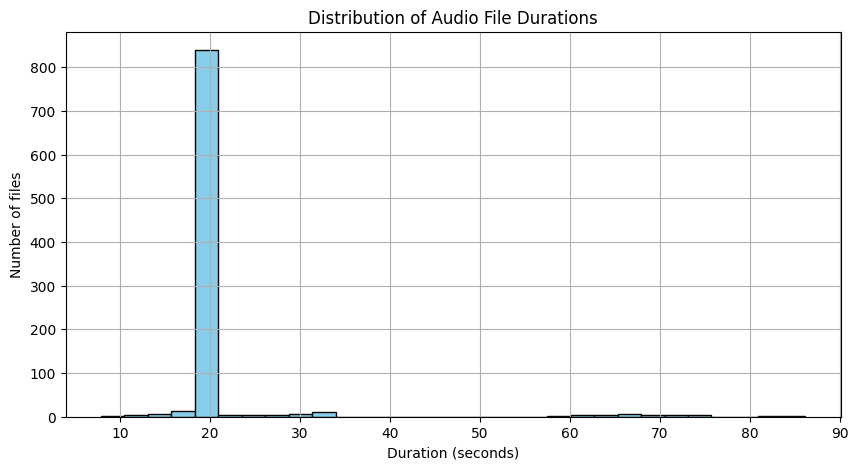

In [8]:
import librosa

audio_durations = {}

for wav_file in audio_files:
    wav_path = os.path.join(folder_path, wav_file)

    try:
        audio, sr = librosa.load(wav_path, sr=None)
        duration = len(audio) / sr
        audio_durations[wav_file] = duration
    except Exception as e:
        print(f"Error reading {wav_file}: {e}")

print(f"Got duration for {len(audio_durations)} audio files.")

for i, (name, dur) in enumerate(audio_durations.items()):
    print(f"{name}: {dur:.2f} seconds")
    if i >= 4: break

import pandas as pd
import matplotlib.pyplot as plt

duration_df = pd.DataFrame(list(audio_durations.items()), columns=['filename', 'duration'])

duration_df['duration_rounded'] = duration_df['duration'].round()

print("Audio Duration Statistics:")
print(duration_df['duration'].describe())

count_20s = (duration_df['duration_rounded'] == 20).sum()
print(f"\nNumber of files exactly 20 seconds long: {count_20s}")

plt.figure(figsize=(10, 5))
plt.hist(duration_df['duration'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Audio File Durations')
plt.xlabel('Duration (seconds)')
plt.ylabel('Number of files')
plt.grid(True)
plt.show()

In [9]:
import os
import librosa
from collections import Counter

folder_path = '/content/ICBHI_extracted/ICBHI_final_database'

sample_rate_counts = Counter()

wav_files = [f for f in os.listdir(folder_path) if f.endswith('.wav')]

for wav_file in wav_files:
    wav_path = os.path.join(folder_path, wav_file)
    try:
        audio, sr = librosa.load(wav_path, sr=None)
        sample_rate_counts[sr] += 1
    except Exception as e:
        print(f"Error loading {wav_file}: {e}")

print("Sample rate distribution:")
for sr, count in sample_rate_counts.items():
    print(f"Sample rate {sr} Hz: {count} files")

Sample rate distribution:
Sample rate 44100 Hz: 824 files
Sample rate 4000 Hz: 90 files
Sample rate 10000 Hz: 6 files


In [10]:
import os
import librosa

folder_path = '/content/ICBHI_extracted/ICBHI_final_database'

example_file = list(all_annotations.keys())[0]

example_annotation = all_annotations[example_file]

example_path = os.path.join(folder_path, example_file)

TARGET_SR = 16000

audio, sr = librosa.load(example_path, sr=TARGET_SR)

cycle_segments = []

for idx, row in example_annotation.iterrows():
    start_time = row['start_time']
    end_time = row['end_time']

    start_sample = int(start_time * sr)
    end_sample = int(end_time * sr)

    segment = audio[start_sample:end_sample]

    cycle_segments.append({
        'audio': segment,
        'crackles': row['crackles'],
        'wheezes': row['wheezes'],
        'start_time': start_time,
        'end_time': end_time
    })

print(f"Extracted {len(cycle_segments)} respiratory cycles from: {example_file}")

Extracted 5 respiratory cycles from: 174_1p2_Pr_mc_AKGC417L.wav


In [11]:
import os
import librosa

folder_path = '/content/ICBHI_extracted/ICBHI_final_database'

TARGET_SR = 16000

all_segments = []

for wav_file, annotation_df in all_annotations.items():
    try:
        wav_path = os.path.join(folder_path, wav_file)

        audio, sr = librosa.load(wav_path, sr=TARGET_SR)

        for idx, row in annotation_df.iterrows():
            start_time = row['start_time']
            end_time = row['end_time']

            start_sample = int(start_time * sr)
            end_sample = int(end_time * sr)

            segment = audio[start_sample:end_sample]

            all_segments.append({
                'filename': wav_file,
                'audio': segment,
                'crackles': row['crackles'],
                'wheezes': row['wheezes'],
                'start_time': start_time,
                'end_time': end_time,
                'duration': end_time - start_time
            })

    except Exception as e:
        print(f"Error processing {wav_file}: {e}")

print(f"Total respiratory cycles extracted: {len(all_segments)}")

Total respiratory cycles extracted: 6898


In [12]:
import numpy as np

FIXED_DURATION = 5.0
FIXED_LENGTH = int(FIXED_DURATION * TARGET_SR)

for segment_data in all_segments:
    audio = segment_data['audio']
    current_length = len(audio)

    if current_length < FIXED_LENGTH:
        pad_length = FIXED_LENGTH - current_length
        padded_audio = np.pad(audio, (0, pad_length), mode='constant')
        segment_data['audio'] = padded_audio

    elif current_length > FIXED_LENGTH:
        cropped_audio = audio[:FIXED_LENGTH]
        segment_data['audio'] = cropped_audio


print(f"All segments cropped/padded to fixed length of {FIXED_DURATION} seconds ({FIXED_LENGTH} samples).")

All segments cropped/padded to fixed length of 5.0 seconds (80000 samples).


In [13]:
import os
import numpy as np
import librosa

save_dir = '/content/ICBHI_extracted/ICBHI_final_database/processed_features'

os.makedirs(save_dir, exist_ok=True)

features = []
labels = []

for segment_data in all_segments:
    audio_clip = segment_data['audio']
    mfcc = librosa.feature.mfcc(y=audio_clip, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfcc, axis=1)

    features.append(mfcc_mean)

    multi_label = [segment_data['crackles'], segment_data['wheezes']]
    labels.append(multi_label)

features = np.array(features)
labels = np.array(labels)

print(f"Features shape: {features.shape}")
print(f"Labels shape: {labels.shape}")


np.save(os.path.join(save_dir, 'features.npy'), features)
np.save(os.path.join(save_dir, 'labels.npy'), labels)

print(f" Features and labels saved to {save_dir}")

Features shape: (6898, 13)
Labels shape: (6898, 2)
 Features and labels saved to /content/ICBHI_extracted/ICBHI_final_database/processed_features


In [14]:
from sklearn.preprocessing import StandardScaler
import joblib
import os



scaler = StandardScaler()

features_normalized = scaler.fit_transform(features)

print(f"Normalized features shape: {features_normalized.shape}")

print("Mean per feature (should be ~0):", features_normalized.mean(axis=0))
print("Std per feature (should be ~1):", features_normalized.std(axis=0))

save_dir = '/content/ICBHI_extracted/ICBHI_final_database/processed_features'
os.makedirs(save_dir, exist_ok=True)
scaler_path = os.path.join(save_dir, 'scaler.save')
joblib.dump(scaler, scaler_path)

print(f"Scaler saved at: {scaler_path}")

Normalized features shape: (6898, 13)
Mean per feature (should be ~0): [ 4.26167155e-08  2.86012423e-08  4.17439878e-08  3.71729740e-08
 -1.20107941e-08 -1.91049399e-08 -2.01332018e-09  2.02152890e-08
  1.67632663e-08  1.50869397e-08  1.36611975e-08  6.74591831e-08
 -5.70296699e-10]
Std per feature (should be ~1): [0.9999992  0.99999964 1.         0.9999998  0.9999997  0.9999998
 1.0000005  1.0000002  0.99999994 0.9999997  1.         1.
 0.9999989 ]
Scaler saved at: /content/ICBHI_extracted/ICBHI_final_database/processed_features/scaler.save


In [15]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    features_normalized, labels, test_size=0.3, random_state=42, shuffle=True
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, shuffle=True
)

print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)

Training set: (4828, 13) (4828, 2)
Validation set: (1035, 13) (1035, 2)
Test set: (1035, 13) (1035, 2)


Epoch 1/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.6831 - loss: 0.5969 - val_accuracy: 0.7826 - val_loss: 0.5523
Epoch 2/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7635 - loss: 0.5506 - val_accuracy: 0.7671 - val_loss: 0.5407
Epoch 3/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7700 - loss: 0.5322 - val_accuracy: 0.7807 - val_loss: 0.5359
Epoch 4/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7641 - loss: 0.5296 - val_accuracy: 0.7691 - val_loss: 0.5318
Epoch 5/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7719 - loss: 0.5233 - val_accuracy: 0.7700 - val_loss: 0.5299
Epoch 6/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7606 - loss: 0.5218 - val_accuracy: 0.7507 - val_loss: 0.5273
Epoch 7/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7542 - loss: 0.5246 - val_accuracy: 0.7633 - val_loss: 0.5265
Epoch 8/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7580 - loss: 0.5168 - val_accuracy: 0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me

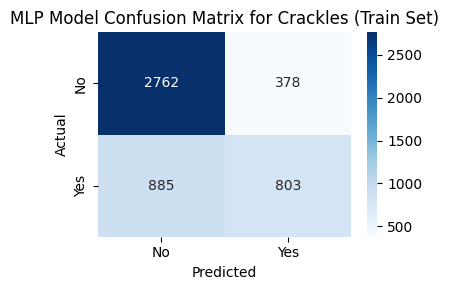

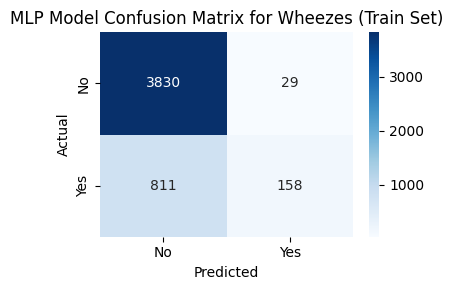

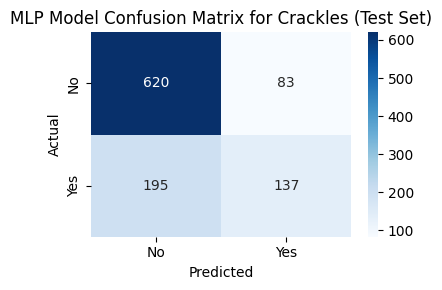

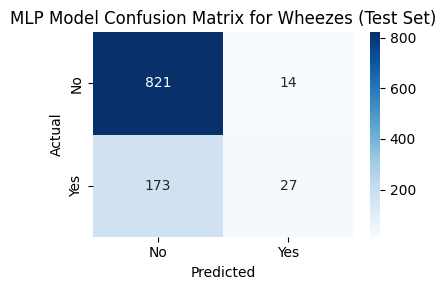

In [16]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

mlp_model = Sequential([
    Input(shape=(13,)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(2, activation='sigmoid')
])

mlp_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

mlp_history = mlp_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

y_train_pred_probs = mlp_model.predict(X_train)
y_train_pred = (y_train_pred_probs > 0.5).astype(int)

y_test_pred_probs = mlp_model.predict(X_test)
y_test_pred = (y_test_pred_probs > 0.5).astype(int)

print(" Classification Report - TRAIN")
print(classification_report(y_train, y_train_pred, target_names=['Crackles', 'Wheezes']))

print(" Classification Report - TEST")
print(classification_report(y_test, y_test_pred, target_names=['Crackles', 'Wheezes']))

def plot_multilabel_cm(y_true, y_pred, labels, set_name):
    cm = multilabel_confusion_matrix(y_true, y_pred)
    for i, label in enumerate(labels):
        plt.figure(figsize=(4, 3))
        sns.heatmap(cm[i], annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
        plt.title(f'MLP Model Confusion Matrix for {label} ({set_name} Set)')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.tight_layout()
        plt.show()

labels_list = ['Crackles', 'Wheezes']
plot_multilabel_cm(y_train, y_train_pred, labels_list, 'Train')
plot_multilabel_cm(y_test, y_test_pred, labels_list, 'Test')

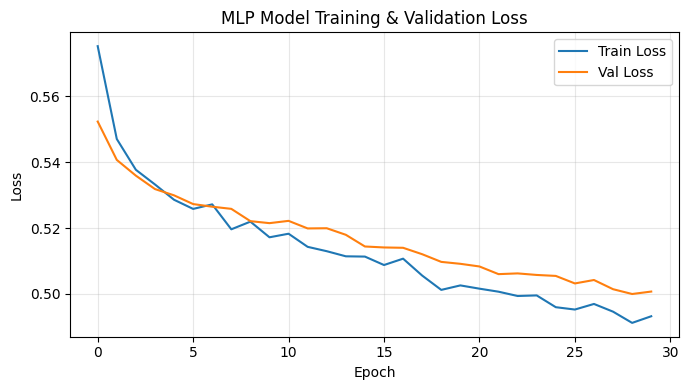

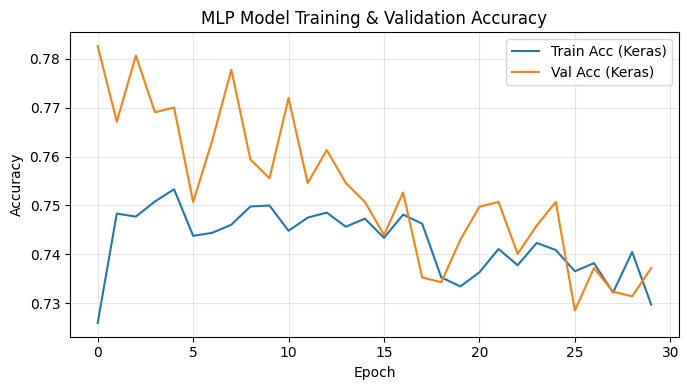


=== MLP Model Train Metrics (threshold=0.50) ===
Keras Binary Accuracy (overall): 0.7822
Subset Accuracy (exact match):  0.6145
Per-label Accuracy: Crackles=0.7384, Wheezes=0.8260

Classification Report:

-- Train | Crackles --
              precision    recall  f1-score   support

          No      0.757     0.880     0.814      3140
         Yes      0.680     0.476     0.560      1688

    accuracy                          0.738      4828
   macro avg      0.719     0.678     0.687      4828
weighted avg      0.730     0.738     0.725      4828


-- Train | Wheezes --
              precision    recall  f1-score   support

          No      0.825     0.992     0.901      3859
         Yes      0.845     0.163     0.273       969

    accuracy                          0.826      4828
   macro avg      0.835     0.578     0.587      4828
weighted avg      0.829     0.826     0.775      4828



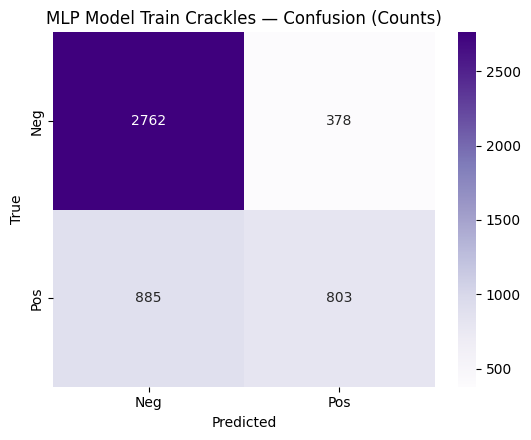

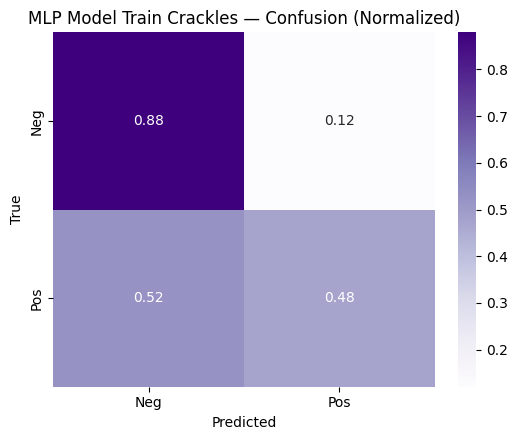

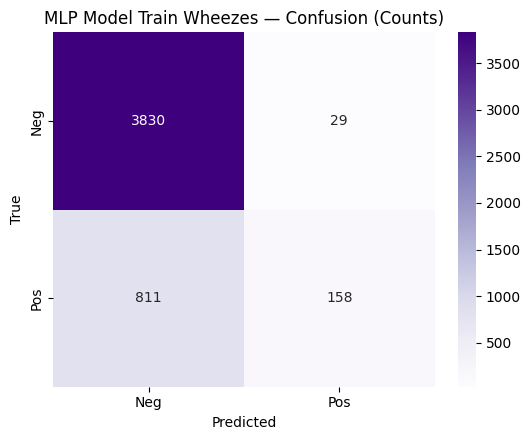

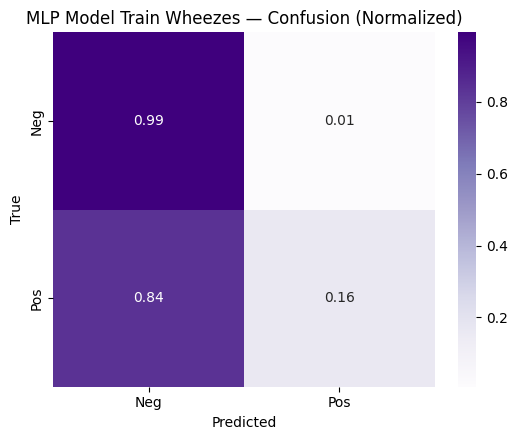

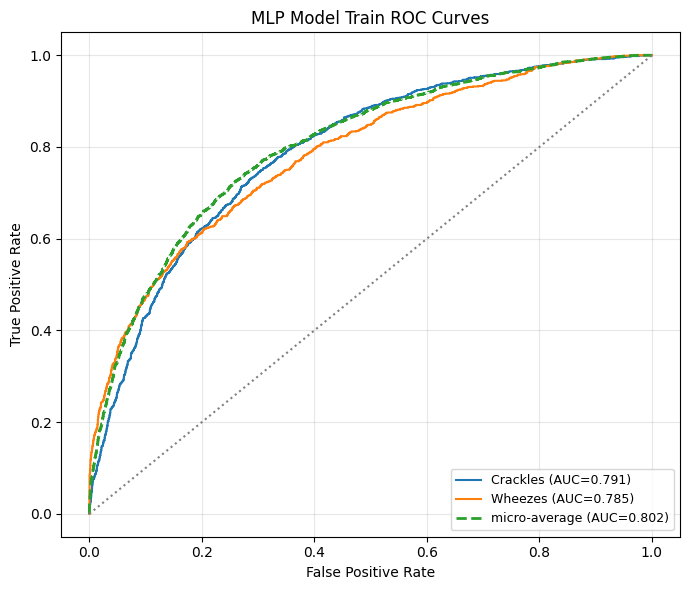


=== MLP Model Val Metrics (threshold=0.50) ===
Keras Binary Accuracy (overall): 0.7614
Subset Accuracy (exact match):  0.5729
Per-label Accuracy: Crackles=0.7150, Wheezes=0.8077

Classification Report:

-- Val | Crackles --
              precision    recall  f1-score   support

          No      0.751     0.851     0.798       685
         Yes      0.606     0.449     0.516       350

    accuracy                          0.715      1035
   macro avg      0.679     0.650     0.657      1035
weighted avg      0.702     0.715     0.703      1035


-- Val | Wheezes --
              precision    recall  f1-score   support

          No      0.807     0.993     0.890       812
         Yes      0.833     0.135     0.232       223

    accuracy                          0.808      1035
   macro avg      0.820     0.564     0.561      1035
weighted avg      0.813     0.808     0.748      1035



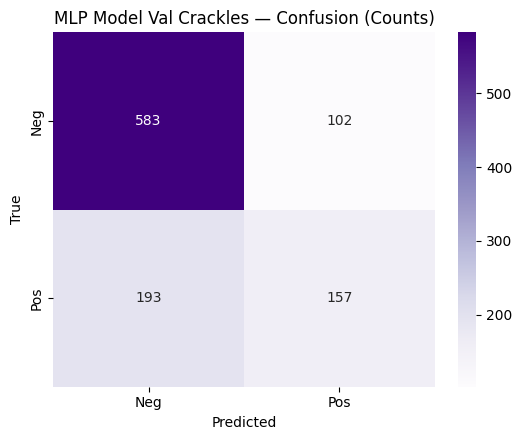

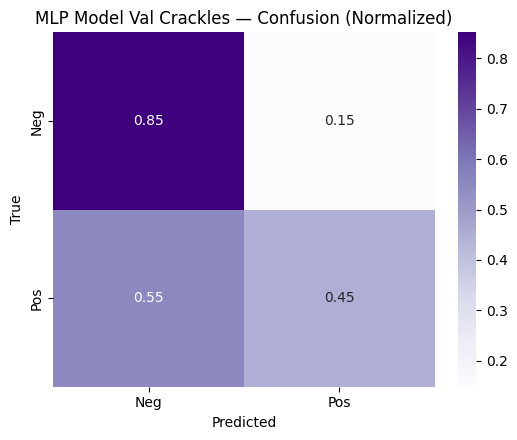

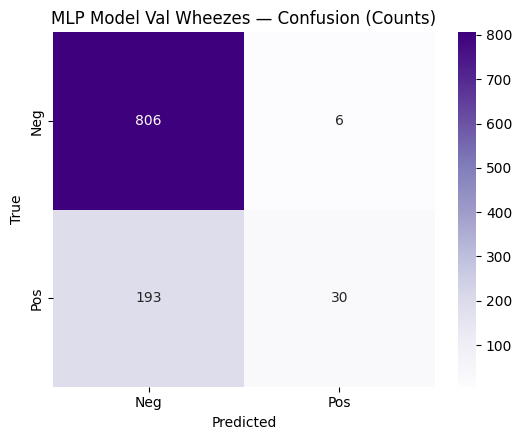

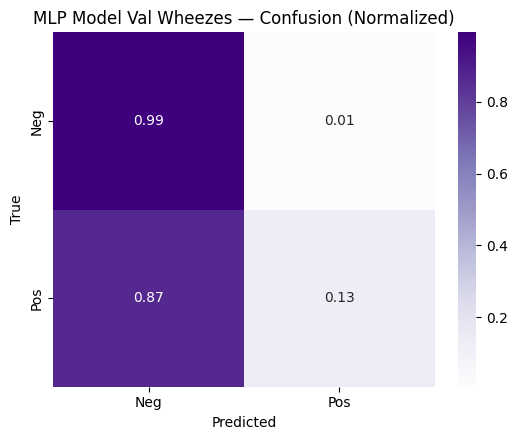

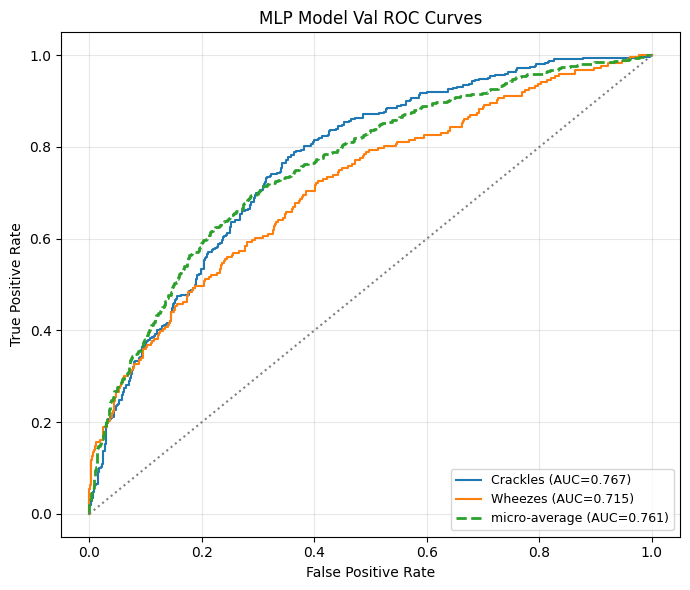


=== MLP Model Test Metrics (threshold=0.50) ===
Keras Binary Accuracy (overall): 0.7754
Subset Accuracy (exact match):  0.6000
Per-label Accuracy: Crackles=0.7314, Wheezes=0.8193

Classification Report:

-- Test | Crackles --
              precision    recall  f1-score   support

          No      0.761     0.882     0.817       703
         Yes      0.623     0.413     0.496       332

    accuracy                          0.731      1035
   macro avg      0.692     0.647     0.657      1035
weighted avg      0.716     0.731     0.714      1035


-- Test | Wheezes --
              precision    recall  f1-score   support

          No      0.826     0.983     0.898       835
         Yes      0.659     0.135     0.224       200

    accuracy                          0.819      1035
   macro avg      0.742     0.559     0.561      1035
weighted avg      0.794     0.819     0.768      1035



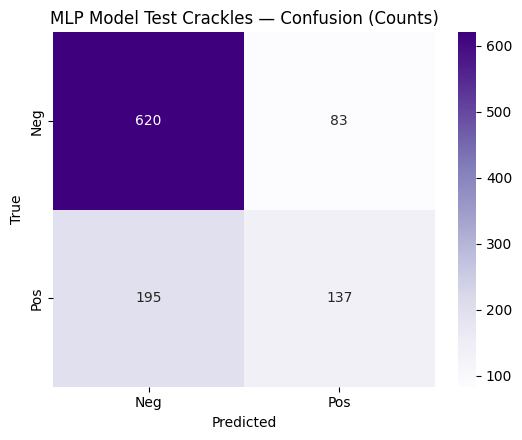

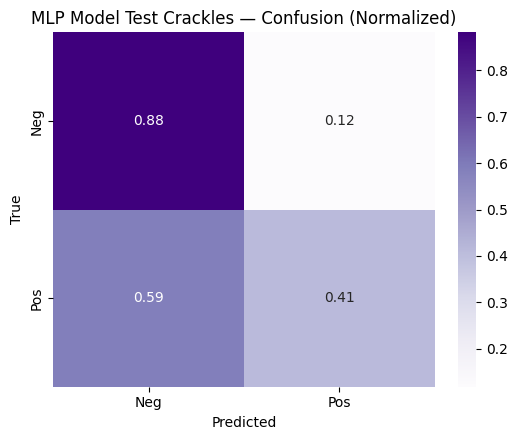

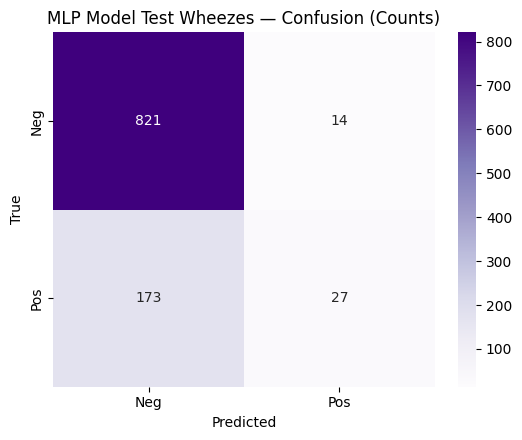

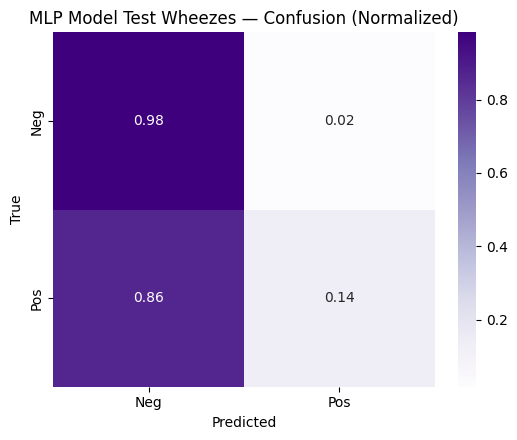

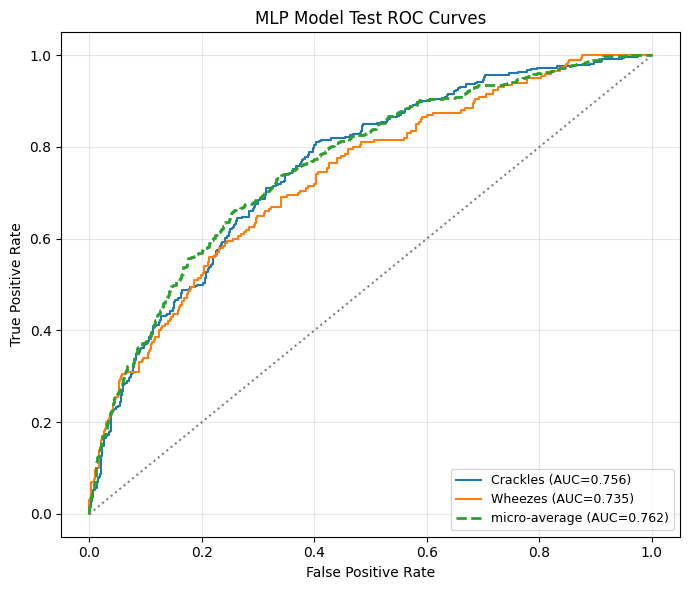


Threshold sweep on Train:


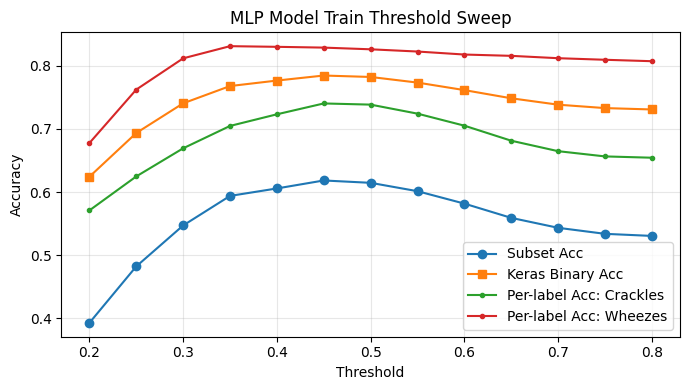

Best subset-accuracy threshold for Train: 0.45 (subset_acc=0.6183)

Threshold sweep on Val:


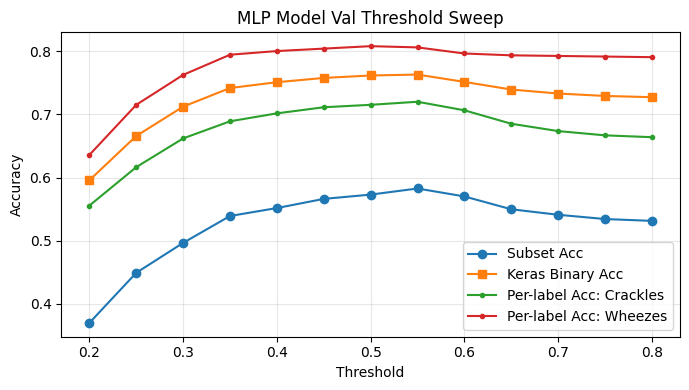

Best subset-accuracy threshold for Val: 0.55 (subset_acc=0.5826)

Threshold sweep on Test:


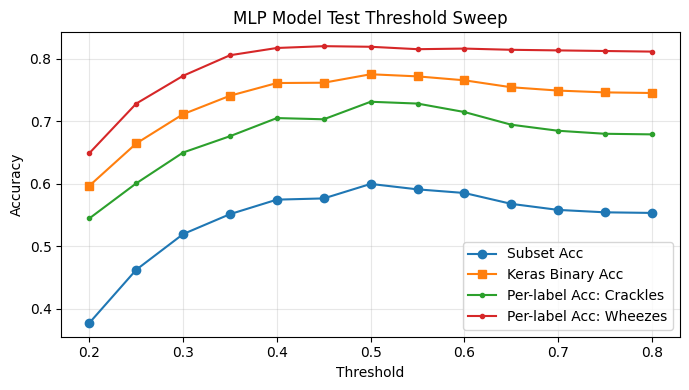

Best subset-accuracy threshold for Test: 0.50 (subset_acc=0.6000)


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, auc,
    accuracy_score
)

SPLITS = {
    "Train": ("X_train", "y_train"),
    "Val":   ("X_val",   "y_val"),
    "Test":  ("X_test",  "y_test"),
}
CLASS_NAMES = ["Crackles", "Wheezes"]
THRESHOLD = 0.5
DO_THRESHOLD_SWEEP = True

CMAP_PURPLE = "Purples"
FIGSIZE_CM = (5.5, 4.5)

def get_var(name):
    g = globals()
    return g[name] if name in g else None

def ensure_2d(y):
    y = np.asarray(y)
    if y.ndim == 1:
        C = int(y.max()) + 1
        Y = np.zeros((y.shape[0], C), dtype=int)
        Y[np.arange(y.shape[0]), y] = 1
        return Y
    return y

def keras_history_curves(history):
    h = history.history if hasattr(history, "history") else history
    if not isinstance(h, dict):
        print("history not found or invalid; skipping curves.")
        return
    plt.figure(figsize=(7,4))
    if "loss" in h: plt.plot(h["loss"], label="Train Loss")
    if "val_loss" in h: plt.plot(h["val_loss"], label="Val Loss")
    plt.title("MLP Model Training & Validation Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()
    acc_key = "accuracy" if "accuracy" in h else ("acc" if "acc" in h else None)
    if acc_key:
        plt.figure(figsize=(7,4))
        plt.plot(h[acc_key], label="Train Acc (Keras)")
        if "val_accuracy" in h: plt.plot(h["val_accuracy"], label="Val Acc (Keras)")
        plt.title("MLP Model Training & Validation Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Accuracy")
        plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

def subset_accuracy(y_true, y_pred_bin):
    return np.mean(np.all(y_true == y_pred_bin, axis=1))

def per_label_accuracy(y_true, y_pred_bin):
    return (y_true == y_pred_bin).mean(axis=0)

def predict_proba(model, X):
    proba = model.predict(X, verbose=0)
    proba = np.asarray(proba)
    if proba.ndim == 1:
        proba = proba[:, None]
    return proba

def plot_confusion(cm, labels, title="Confusion Matrix", normalize=False):
    cm_plot = cm.astype(float)
    if normalize:
        with np.errstate(invalid="ignore"):
            row_sums = cm_plot.sum(axis=1, keepdims=True)
            cm_plot = np.divide(cm_plot, row_sums, out=np.zeros_like(cm_plot), where=row_sums!=0)
    plt.figure(figsize=FIGSIZE_CM)
    sns.heatmap(cm_plot, annot=True, fmt=".2f" if normalize else ".0f",
                cmap=CMAP_PURPLE, cbar=True,
                xticklabels=["Neg","Pos"], yticklabels=["Neg","Pos"])
    plt.title(title)
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.tight_layout(); plt.show()


def plot_roc(y_true, y_proba, class_names, title_prefix=""):
    y_true = np.asarray(y_true)
    y_proba = np.asarray(y_proba)
    n_classes = y_true.shape[1]

    plt.figure(figsize=(7,6))
    aucs = []
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_proba[:, i])
        A = auc(fpr, tpr)
        aucs.append(A)
        plt.plot(fpr, tpr, lw=1.5, label=f"{class_names[i]} (AUC={A:.3f})")
    fpr_micro, tpr_micro, _ = roc_curve(y_true.ravel(), y_proba.ravel())
    auc_micro = auc(fpr_micro, tpr_micro)
    plt.plot(fpr_micro, tpr_micro, linestyle="--", lw=2, label=f"micro-average (AUC={auc_micro:.3f})")
    plt.plot([0,1], [0,1], linestyle=":", color="gray")
    plt.title(f"MLP Model {title_prefix} ROC Curves")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right", fontsize=9)
    plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

def evaluate_split(split_name, X, y, model, class_names, threshold=0.5):
    X = np.asarray(X); y = ensure_2d(y)
    y_proba = predict_proba(model, X)
    if y_proba.shape[1] != y.shape[1]:
        raise ValueError(f"Predicted probs have shape {y_proba.shape}, but y has shape {y.shape}.")
    y_pred_bin = (y_proba >= threshold).astype(int)

    keras_bin_acc = accuracy_score(y.flatten(), y_pred_bin.flatten())
    subset_acc = subset_accuracy(y, y_pred_bin)
    pla = per_label_accuracy(y, y_pred_bin)

    print(f"\n=== MLP Model {split_name} Metrics (threshold={threshold:.2f}) ===")
    print(f"Keras Binary Accuracy (overall): {keras_bin_acc:.4f}")
    print(f"Subset Accuracy (exact match):  {subset_acc:.4f}")
    print(f"Per-label Accuracy: " + ", ".join([f"{class_names[i]}={pla[i]:.4f}" for i in range(len(class_names))]))
    print("\nClassification Report:")
    for i, cname in enumerate(class_names):
        print(f"\n-- {split_name} | {cname} --")
        print(classification_report(y[:, i], y_pred_bin[:, i], target_names=["No","Yes"], digits=3))

    for i, cname in enumerate(class_names):
        cm = confusion_matrix(y[:, i], y_pred_bin[:, i], labels=[0,1])
        plot_confusion(cm, ["No","Yes"], title=f"MLP Model {split_name} {cname} — Confusion (Counts)", normalize=False)
        plot_confusion(cm, ["No","Yes"], title=f"MLP Model {split_name} {cname} — Confusion (Normalized)", normalize=True)

    plot_roc(y, y_proba, class_names, title_prefix=f"{split_name}")

    return {
        "keras_binary_acc": keras_bin_acc,
        "subset_acc": subset_acc,
        "per_label_acc": pla,
    }

def threshold_sweep(split_name, X, y, model, class_names, thresholds=np.linspace(0.2, 0.8, 13)):
    X = np.asarray(X); y = ensure_2d(y)
    y_proba = predict_proba(model, X)
    best = {"threshold": None, "subset_acc": -1}
    results = []
    for t in thresholds:
        y_pred_bin = (y_proba >= t).astype(int)
        sa = subset_accuracy(y, y_pred_bin)
        keras_bin_acc = accuracy_score(y.flatten(), y_pred_bin.flatten())
        pla = per_label_accuracy(y, y_pred_bin)
        results.append((t, sa, keras_bin_acc, *pla))
        if sa > best["subset_acc"]:
            best = {"threshold": t, "subset_acc": sa}
    results = np.array(results)

    plt.figure(figsize=(7,4))
    plt.plot(results[:,0], results[:,1], marker="o", label="Subset Acc")
    plt.plot(results[:,0], results[:,2], marker="s", label="Keras Binary Acc")
    for i, cname in enumerate(class_names):
        plt.plot(results[:,0], results[:,3+i], marker=".", label=f"Per-label Acc: {cname}")
    plt.title(f"MLP Model {split_name} Threshold Sweep")
    plt.xlabel("Threshold"); plt.ylabel("Accuracy")
    plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

    print(f"Best subset-accuracy threshold for {split_name}: {best['threshold']:.2f} (subset_acc={best['subset_acc']:.4f})")
    return results

_hist = get_var("mlp_history") or get_var("hist")
if _hist is not None:
    keras_history_curves(_hist)
else:
    print("No 'mlp_history' found; skipping training curves.")

summary = {}
for split_name, (Xn, Yn) in SPLITS.items():
    Xv = get_var(Xn); Yv = get_var(Yn)
    if Xv is None or Yv is None:
        print(f"{split_name}: missing split; skipping.")
        continue
    summary[split_name] = evaluate_split(split_name, Xv, Yv, mlp_model, CLASS_NAMES, threshold=THRESHOLD)

if DO_THRESHOLD_SWEEP:
    for split_name, (Xn, Yn) in SPLITS.items():
        Xv = get_var(Xn); Yv = get_var(Yn)
        if Xv is None or Yv is None:
            continue
        print(f"\nThreshold sweep on {split_name}:")
        threshold_sweep(split_name, Xv, Yv, mlp_model, CLASS_NAMES)

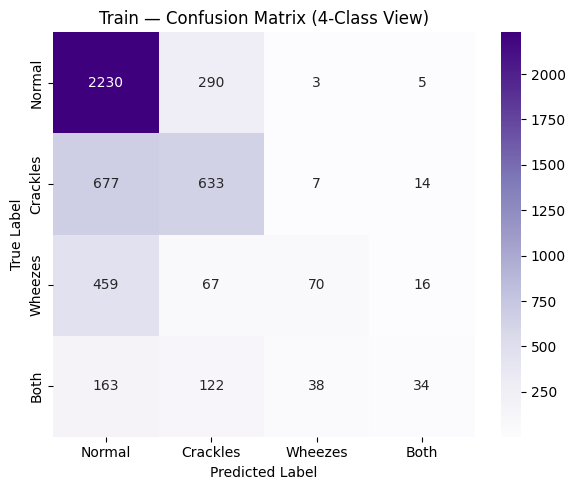

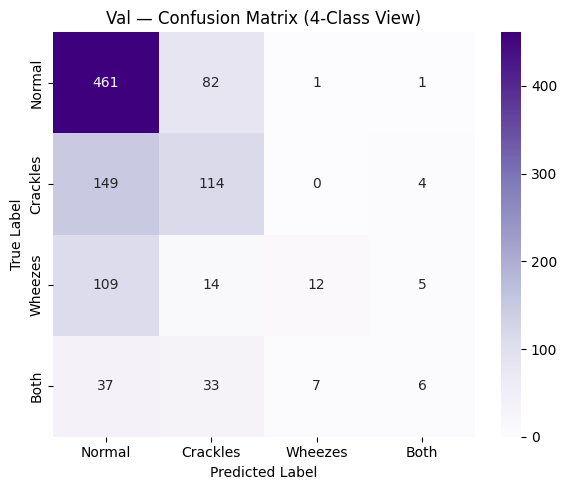

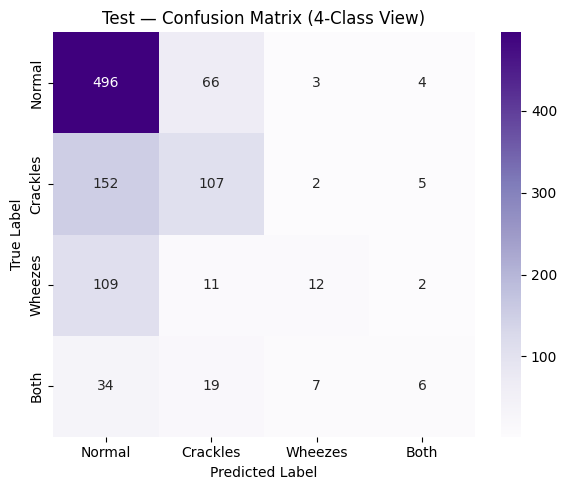

In [18]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def multilabel_to_single(y_bin):
    return y_bin[:, 0]*1 + y_bin[:, 1]*2

def plot_full_class_confusion(y_true_bin, y_pred_bin, split_name=""):
    y_true_single = multilabel_to_single(y_true_bin)
    y_pred_single = multilabel_to_single(y_pred_bin)
    cm_full = confusion_matrix(y_true_single, y_pred_single, labels=[0, 1, 2, 3])
    class_labels = ["Normal", "Crackles", "Wheezes", "Both"]

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_full, annot=True, fmt="d", cmap="Purples",
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f"{split_name} — Confusion Matrix (4-Class View)")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()
    return cm_full

for split_name, (Xn, Yn) in SPLITS.items():
    Xv = get_var(Xn); Yv = get_var(Yn)
    if Xv is None or Yv is None:
        continue
    y_true = ensure_2d(Yv)
    y_proba = predict_proba(mlp_model, Xv)
    y_pred_bin = (y_proba >= THRESHOLD).astype(int)
    plot_full_class_confusion(y_true, y_pred_bin, split_name=split_name)

### MLP Model Summary of Findings

Here is a summary of the MLP model's performance on the training and test sets:

| Metric                     | Train Set (Overall) | Test Set (Overall) | Crackles (Train) | Wheezes (Train) | Crackles (Test) | Wheezes (Test) |
|----------------------------|---------------------|--------------------|------------------|-----------------|-----------------|----------------|
| Keras Binary Accuracy      | 0.7814              | 0.7734             | -                | -               | -               | -              |
| Subset Accuracy            | 0.6087              | 0.6097             | -                | -               | -               | -              |
| Loss (Final Epoch)         | 0.4896              | 0.4961             | -                | -               | -               | -              |
| Precision                  | -                   | -                  | 0.664            | 0.873           | 0.607           | 0.844          |
| Recall                     | -                   | -                  | 0.507            | 0.143           | 0.489           | 0.122          |
| F1-Score                   | -                   | -                  | 0.575            | 0.246           | 0.542           | 0.213          |

**Key Observations:**

*   The overall accuracy metrics (Keras Binary Accuracy and Subset Accuracy) are relatively similar between the train and test sets, suggesting the model is not significantly overfitting the training data.
*   The model shows a large disparity in performance between the 'Crackles' and 'Wheezes' classes.
*   'Crackles' detection has a more balanced precision and recall, indicating a moderate ability to correctly identify this class.
*   'Wheezes' detection has very low recall on both sets, meaning the model is failing to identify a large proportion of actual wheezes. The high precision for wheezes is misleading due to the low number of positive predictions.
*   The loss on the validation set is slightly higher than the training loss, but the values are close, which again suggests no major overfitting.

This summary highlights the challenge in detecting the 'Wheezes' class, which should be the focus of future model improvements.

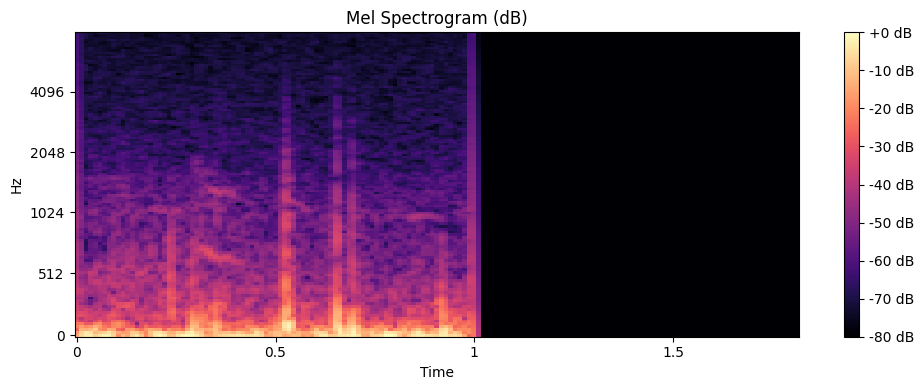

Visualizing crackle segment from file: 160_1b4_Pr_mc_AKGC417L.wav


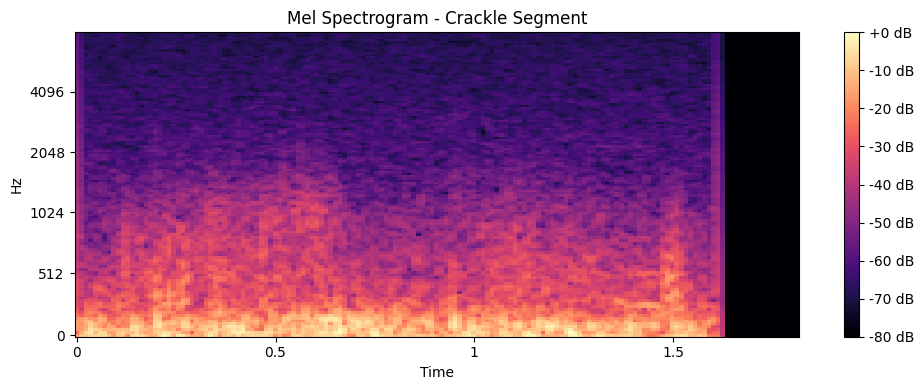

Visualizing wheeze segment from file: 106_2b1_Pr_mc_LittC2SE.wav


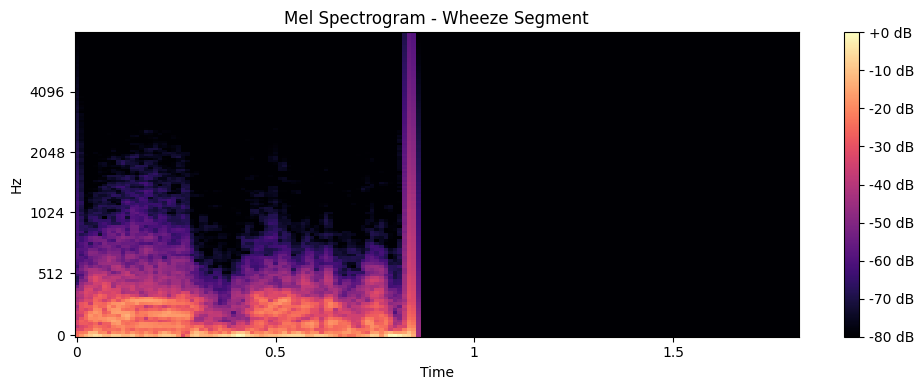

In [19]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

segment_audio = all_segments[0]['audio']
sample_rate = 44100

def extract_mel_spectrogram(audio_segment, sr, n_mels=128, fmax=8000):
    S = librosa.feature.melspectrogram(y=audio_segment, sr=sr, n_mels=n_mels, fmax=fmax)
    S_dB = librosa.power_to_db(S, ref=np.max)
    return S_dB

mel_spec = extract_mel_spectrogram(segment_audio, sample_rate)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spec, sr=sample_rate, x_axis='time', y_axis='mel', fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram (dB)')
plt.tight_layout()
plt.show()

import random

crackle_indices = [i for i, seg in enumerate(all_segments) if seg['crackles'] == 1]
wheeze_indices = [i for i, seg in enumerate(all_segments) if seg['wheezes'] == 1]

if crackle_indices:
    idx_crackle = random.choice(crackle_indices)
    segment_crackle = all_segments[idx_crackle]['audio']
    print(f"Visualizing crackle segment from file: {all_segments[idx_crackle]['filename']}")

    mel_spec_crackle = extract_mel_spectrogram(segment_crackle, sample_rate)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spec_crackle, sr=sample_rate, x_axis='time', y_axis='mel', fmax=8000)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram - Crackle Segment')
    plt.tight_layout()
    plt.show()
else:
    print("No crackle segments found!")

if wheeze_indices:
    idx_wheeze = random.choice(wheeze_indices)
    segment_wheeze = all_segments[idx_wheeze]['audio']
    print(f"Visualizing wheeze segment from file: {all_segments[idx_wheeze]['filename']}")

    mel_spec_wheeze = extract_mel_spectrogram(segment_wheeze, sample_rate)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spec_wheeze, sr=sample_rate, x_axis='time', y_axis='mel', fmax=8000)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram - Wheeze Segment')
    plt.tight_layout()
    plt.show()
else:
    print("No wheeze segments found!")

In [20]:
import numpy as np
import librosa
import os
from tqdm import tqdm

n_mels = 128
fmax = 8000
sr = 16000
hop_length = 512

mel_specs = []
labels = []

for i, segment in enumerate(tqdm(all_segments)):
    audio = segment['audio']

    mel = librosa.feature.melspectrogram(
        y=audio, sr=sr, n_mels=n_mels, fmax=fmax, hop_length=hop_length
    )
    mel_db = librosa.power_to_db(mel, ref=np.max)

    mel_db = (mel_db - mel_db.mean()) / (mel_db.std() + 1e-6)

    mel_specs.append(mel_db)

    labels.append([segment['crackles'], segment['wheezes']])

try:
    mel_specs = np.array(mel_specs)
    print(" Mel spectrograms shape:", mel_specs.shape)
except ValueError as e:
    print(f"Error converting mel_specs to numpy array: {e}")
    first_shape = mel_specs[0].shape if len(mel_specs) > 0 else None
    if first_shape:
        print("Checking for inconsistent shapes...")
        for j in range(len(mel_specs)):
            if mel_specs[j].shape != first_shape:
                print(f"Inconsistent shape at index {j}: {mel_specs[j].shape} (expected {first_shape})")


labels = np.array(labels)

print(" Labels shape:", labels.shape)

save_dir = '/content/ICBHI_extracted/ICBHI_final_database/processed_features'
os.makedirs(save_dir, exist_ok=True)

np.save(os.path.join(save_dir, 'mel_spectrograms.npy'), mel_specs)
np.save(os.path.join(save_dir, 'labels.npy'), labels)

print(f" Saved mel spectrograms and labels to {save_dir}")

100%|██████████| 6898/6898 [01:19<00:00, 86.32it/s]


 Mel spectrograms shape: (6898, 128, 157)
 Labels shape: (6898, 2)
 Saved mel spectrograms and labels to /content/ICBHI_extracted/ICBHI_final_database/processed_features


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - accuracy: 0.7477 - loss: 0.7890 - val_accuracy: 0.7556 - val_loss: 0.5776
Epoch 2/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.7538 - loss: 0.5484 - val_accuracy: 0.7691 - val_loss: 0.5570
Epoch 3/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7645 - loss: 0.5274 - val_accuracy: 0.7324 - val_loss: 0.5523
Epoch 4/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.7416 - loss: 0.5105 - val_accuracy: 0.7527 - val_loss: 0.5331
Epoch 5/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.7479 - loss: 0.4890 - val_accuracy: 0.7266 - val_loss: 0.5275
Epoch 6/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7379 - loss: 0.4757 - val_accuracy: 0.7488 - val_loss: 0.5272
Epoch 7/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.7184 - loss: 0.4572 - val_accuracy: 0.7217 - val_loss: 0.5222
Epoch 8/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7260 - loss: 0.4445 - val_acc

 CNN model saved to: /content/ICBHI_extracted/ICBHI_final_database/processed_features/cnn_mel_model.h5
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
 Classification Report - TRAIN
              precision    recall  f1-score   support

    Crackles       0.74      0.64      0.69      1688
     Wheezes       0.94      0.17      0.29       969

   micro avg       0.76      0.47      0.58      2657
   macro avg       0.84      0.41      0.49      2657
weighted avg       0.81      0.47      0.54      2657
 samples avg       0.26      0.24      0.25      2657

 Classification Report - TEST
              precision    recall  f1-score   support

    Crackles       0.56      0.51      0.54       332
     Wheezes       0.79      0.10      0.17       200

   micro avg       0.58      0.36      0.44       532
   macro avg       0.68      0.30      0.35       532
weighted avg       0.65      0.36      0.40       532
 samples avg       0.18      0.17      0.17     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me

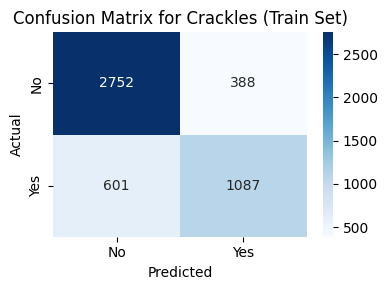

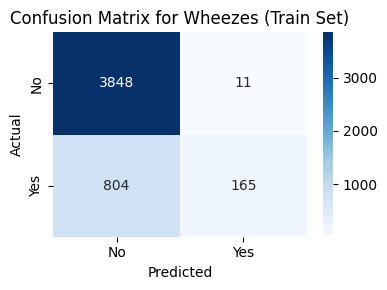

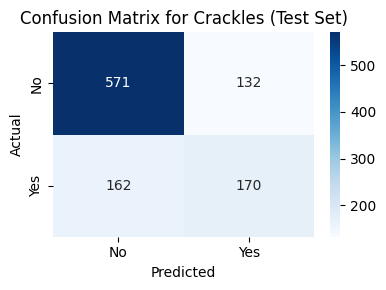

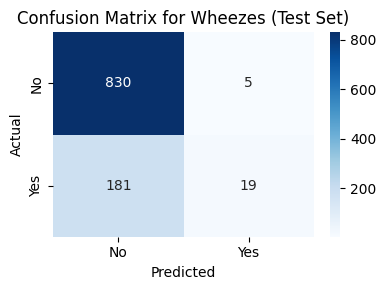

In [21]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

data_dir = '/content/ICBHI_extracted/ICBHI_final_database/processed_features'
X = np.load(os.path.join(data_dir, 'mel_spectrograms.npy'))
y = np.load(os.path.join(data_dir, 'labels.npy'))

X = X[..., np.newaxis]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=True)

model = Sequential([
    InputLayer(input_shape=(128, 157, 1)),

    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(2, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

model_path = os.path.join(data_dir, 'cnn_mel_model.h5')
model.save(model_path)
print(f" CNN model saved to: {model_path}")

y_train_pred_probs = model.predict(X_train)
y_train_pred = (y_train_pred_probs > 0.5).astype(int)

y_test_pred_probs = model.predict(X_test)
y_test_pred = (y_test_pred_probs > 0.5).astype(int)

print(" Classification Report - TRAIN")
print(classification_report(y_train, y_train_pred, target_names=['Crackles', 'Wheezes']))

print(" Classification Report - TEST")
print(classification_report(y_test, y_test_pred, target_names=['Crackles', 'Wheezes']))

def plot_multilabel_cm(y_true, y_pred, labels, set_name):
    cm = multilabel_confusion_matrix(y_true, y_pred)
    for i, label in enumerate(labels):
        plt.figure(figsize=(4, 3))
        sns.heatmap(cm[i], annot=True, fmt='d', cmap='Blues',
                    xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
        plt.title(f'Confusion Matrix for {label} ({set_name} Set)')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.tight_layout()
        plt.show()

labels_list = ['Crackles', 'Wheezes']
plot_multilabel_cm(y_train, y_train_pred, labels_list, 'Train')
plot_multilabel_cm(y_test, y_test_pred, labels_list, 'Test')


=== Test Metrics (threshold=0.50) ===
Binary Accuracy (flattened): 0.7681
Subset Accuracy (exact match): 0.5932
Per-label Accuracy:
 - Crackles: 0.7159
 - Wheezes: 0.8203

-- Test Classification Report: Crackles --
              precision    recall  f1-score   support

          No       0.78      0.81      0.80       703
         Yes       0.56      0.51      0.54       332

    accuracy                           0.72      1035
   macro avg       0.67      0.66      0.67      1035
weighted avg       0.71      0.72      0.71      1035



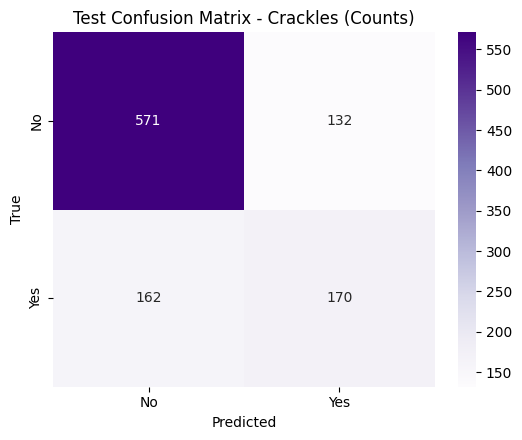

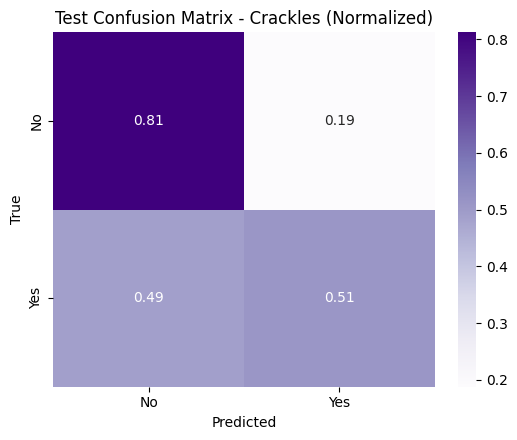


-- Test Classification Report: Wheezes --
              precision    recall  f1-score   support

          No       0.82      0.99      0.90       835
         Yes       0.79      0.10      0.17       200

    accuracy                           0.82      1035
   macro avg       0.81      0.54      0.53      1035
weighted avg       0.82      0.82      0.76      1035



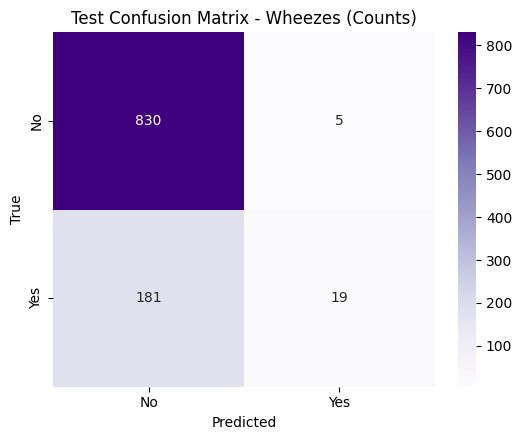

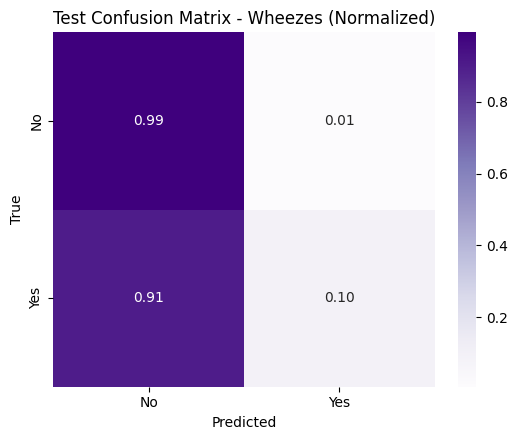

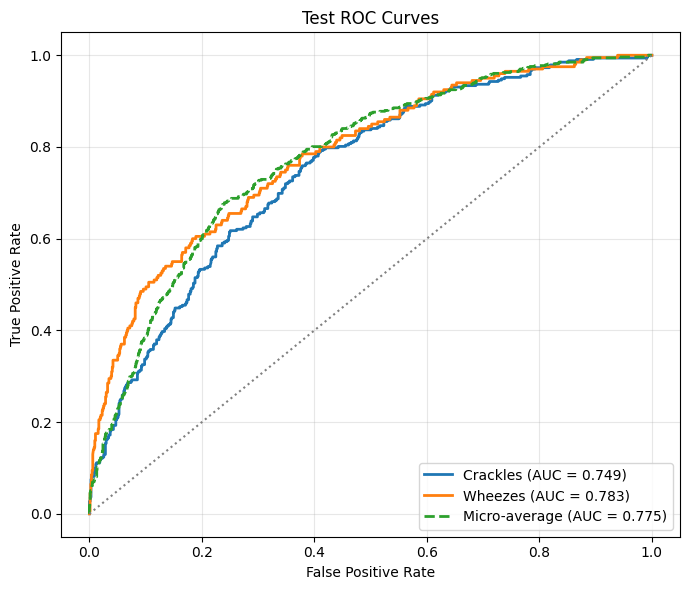

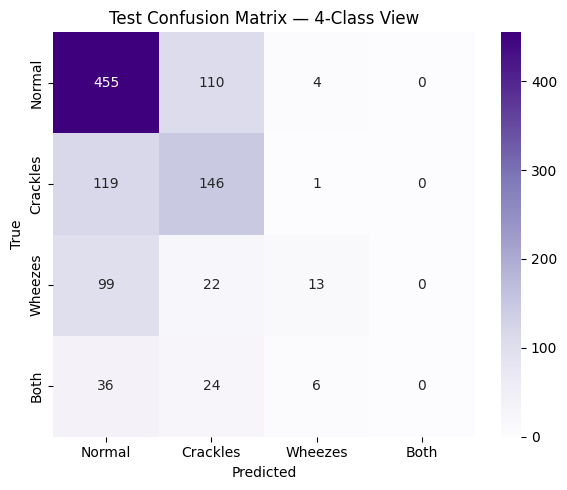

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, auc,
    accuracy_score
)

CMAP_PURPLE = "Purples"
FIGSIZE_CM = (5.5, 4.5)
CLASS_NAMES = ["Crackles", "Wheezes"]
THRESHOLD = 0.5
DO_THRESHOLD_SWEEP = True

def plot_training_curves(history):
    h = history.history
    if "loss" in h:
        plt.figure(figsize=(7, 4))
        plt.plot(h["loss"], label="Train Loss")
        if "val_loss" in h:
            plt.plot(h["val_loss"], label="Val Loss")
        plt.title("Training & Validation Loss")
        plt.xlabel("Epoch"); plt.ylabel("Loss")
        plt.grid(True, alpha=0.3)
        plt.legend(); plt.tight_layout(); plt.show()
    if "accuracy" in h:
        plt.figure(figsize=(7, 4))
        plt.plot(h["accuracy"], label="Train Accuracy")
        if "val_accuracy" in h:
            plt.plot(h["val_accuracy"], label="Val Accuracy")
        plt.title("Training & Validation Accuracy")
        plt.xlabel("Epoch"); plt.ylabel("Accuracy")
        plt.grid(True, alpha=0.3)
        plt.legend(); plt.tight_layout(); plt.show()

def plot_confusion(cm, title="Confusion Matrix", normalize=False):
    cm = np.asarray(cm, dtype=float)
    if normalize:
        with np.errstate(invalid='ignore'):
            cm_sum = cm.sum(axis=1, keepdims=True)
            cm = np.divide(cm, cm_sum, out=np.zeros_like(cm), where=cm_sum!=0)
        fmt = ".2f"
    else:
        fmt = ".0f"
    plt.figure(figsize=FIGSIZE_CM)
    sns.heatmap(cm, annot=True, fmt=fmt, cmap=CMAP_PURPLE,
                xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout(); plt.show()


def plot_roc_curves(y_true, y_proba, class_names, title_prefix=""):
    y_true = np.asarray(y_true)
    y_proba = np.asarray(y_proba)
    n_classes = y_true.shape[1]

    plt.figure(figsize=(7, 6))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"{class_names[i]} (AUC = {roc_auc:.3f})")
    fpr_micro, tpr_micro, _ = roc_curve(y_true.ravel(), y_proba.ravel())
    auc_micro = auc(fpr_micro, tpr_micro)
    plt.plot(fpr_micro, tpr_micro, linestyle='--', lw=2, label=f"Micro-average (AUC = {auc_micro:.3f})")
    plt.plot([0, 1], [0, 1], linestyle=":", color="gray")
    plt.title(f"{title_prefix} ROC Curves")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.tight_layout(); plt.show()

def get_4class_labels(y):
    return np.array([
        0 if (a == 0 and b == 0) else
        1 if (a == 1 and b == 0) else
        2 if (a == 0 and b == 1) else
        3 for a, b in y
    ])

def evaluate_model(X, y_true, model, history, class_names, split_name="Test", threshold=0.5):
    y_true = np.asarray(y_true)
    y_proba = model.predict(X, verbose=0)
    y_pred = (y_proba >= threshold).astype(int)

    keras_bin_acc = accuracy_score(y_true.flatten(), y_pred.flatten())
    subset_acc = np.mean(np.all(y_true == y_pred, axis=1))
    per_label_acc = (y_true == y_pred).mean(axis=0)

    print(f"\n=== {split_name} Metrics (threshold={threshold:.2f}) ===")
    print(f"Binary Accuracy (flattened): {keras_bin_acc:.4f}")
    print(f"Subset Accuracy (exact match): {subset_acc:.4f}")
    print("Per-label Accuracy:")
    for i, name in enumerate(class_names):
        print(f" - {name}: {per_label_acc[i]:.4f}")

    for i, cname in enumerate(class_names):
        print(f"\n-- {split_name} Classification Report: {cname} --")
        print(classification_report(y_true[:, i], y_pred[:, i], target_names=["No", "Yes"]))
        cm = confusion_matrix(y_true[:, i], y_pred[:, i])
        plot_confusion(cm, f"{split_name} Confusion Matrix - {cname} (Counts)", normalize=False)
        plot_confusion(cm, f"{split_name} Confusion Matrix - {cname} (Normalized)", normalize=True)

    plot_roc_curves(y_true, y_proba, class_names, title_prefix=split_name)

    y_true_4 = get_4class_labels(y_true)
    y_pred_4 = get_4class_labels(y_pred)
    cm_4class = confusion_matrix(y_true_4, y_pred_4)
    labels_4 = ["Normal", "Crackles", "Wheezes", "Both"]
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_4class, annot=True, fmt='d', cmap="Purples",
                xticklabels=labels_4, yticklabels=labels_4)
    plt.title(f"{split_name} Confusion Matrix — 4-Class View")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.tight_layout(); plt.show()

evaluate_model(X_test, y_test, model, history, CLASS_NAMES, split_name="Test")

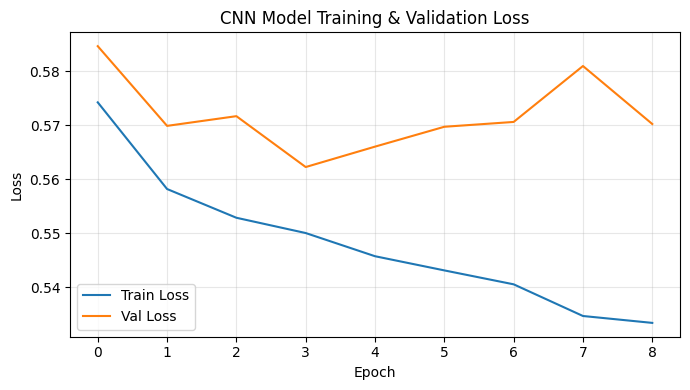

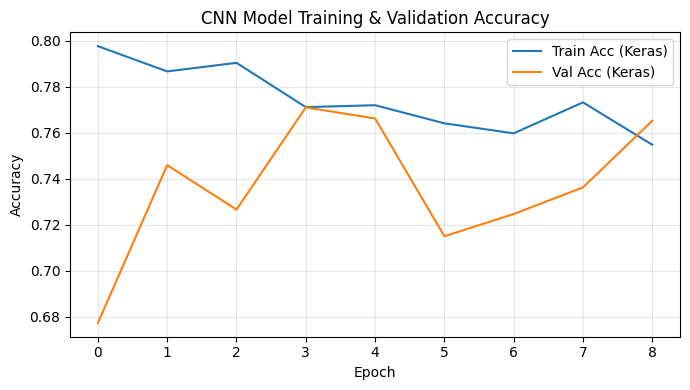


=== CNN Model Train Metrics (threshold=0.50) ===
Keras Binary Accuracy (overall): 0.7285
Subset Accuracy (exact match):  0.5288
Per-label Accuracy: Crackles=0.6576, Wheezes=0.7993

Classification Report:

-- Train | Crackles --
              precision    recall  f1-score   support

          No      0.712     0.794     0.751      3140
         Yes      0.513     0.403     0.452      1688

    accuracy                          0.658      4828
   macro avg      0.613     0.599     0.601      4828
weighted avg      0.643     0.658     0.646      4828


-- Train | Wheezes --
              precision    recall  f1-score   support

          No      0.799     1.000     0.888      3859
         Yes      0.000     0.000     0.000       969

    accuracy                          0.799      4828
   macro avg      0.400     0.500     0.444      4828
weighted avg      0.639     0.799     0.710      4828



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


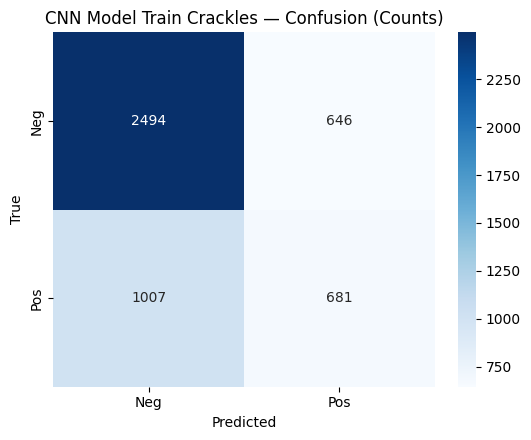

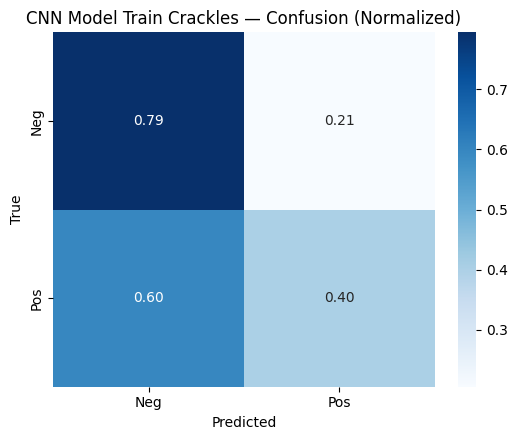

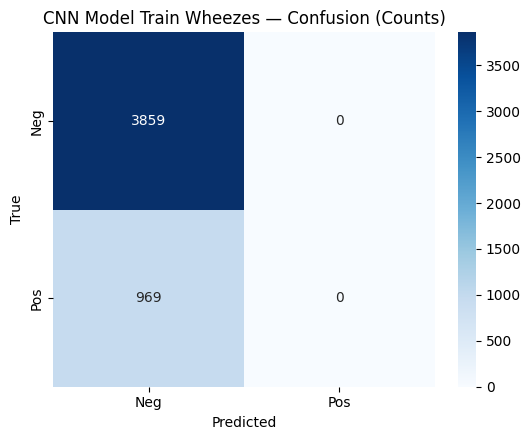

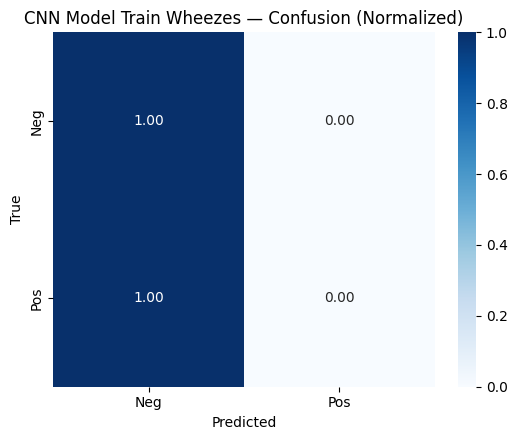

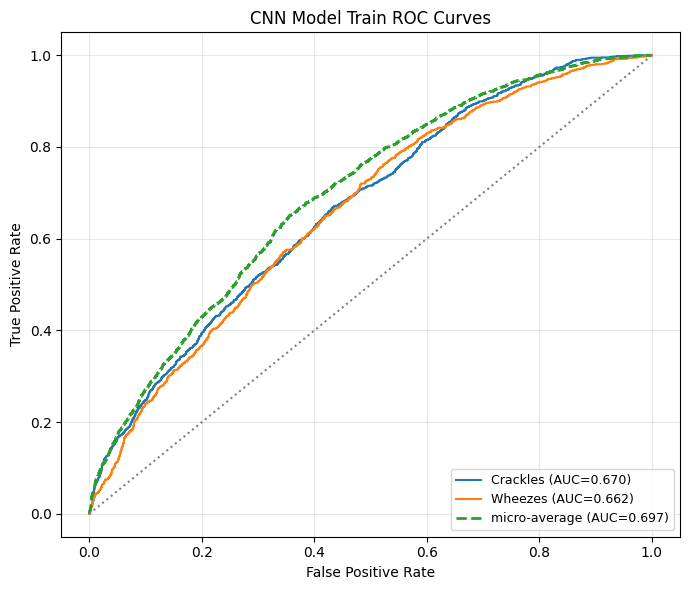


=== CNN Model Val Metrics (threshold=0.50) ===
Keras Binary Accuracy (overall): 0.7217
Subset Accuracy (exact match):  0.5198
Per-label Accuracy: Crackles=0.6589, Wheezes=0.7845

Classification Report:

-- Val | Crackles --
              precision    recall  f1-score   support

          No      0.713     0.812     0.759       685
         Yes      0.494     0.360     0.417       350

    accuracy                          0.659      1035
   macro avg      0.603     0.586     0.588      1035
weighted avg      0.639     0.659     0.643      1035


-- Val | Wheezes --
              precision    recall  f1-score   support

          No      0.785     1.000     0.879       812
         Yes      0.000     0.000     0.000       223

    accuracy                          0.785      1035
   macro avg      0.392     0.500     0.440      1035
weighted avg      0.616     0.785     0.690      1035



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


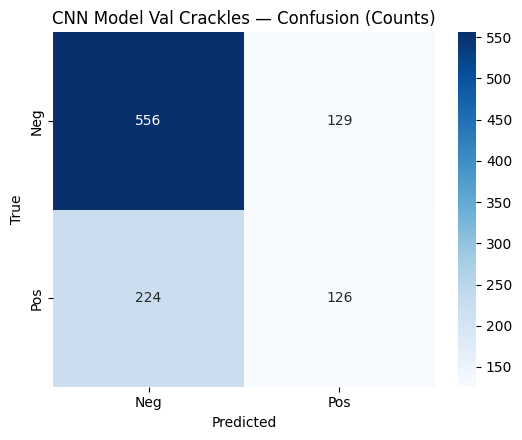

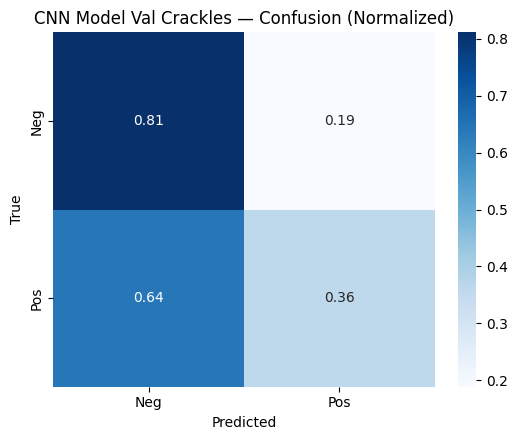

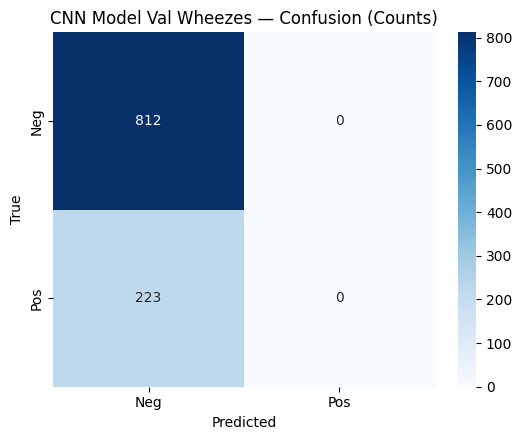

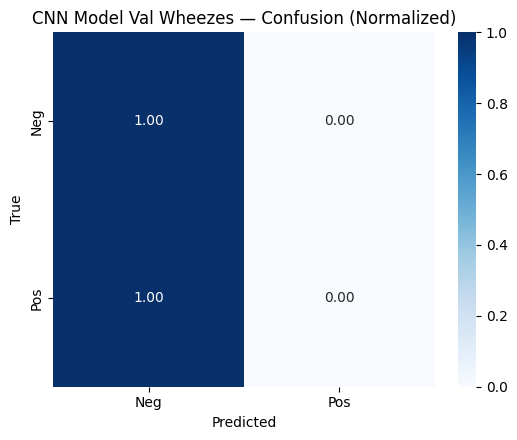

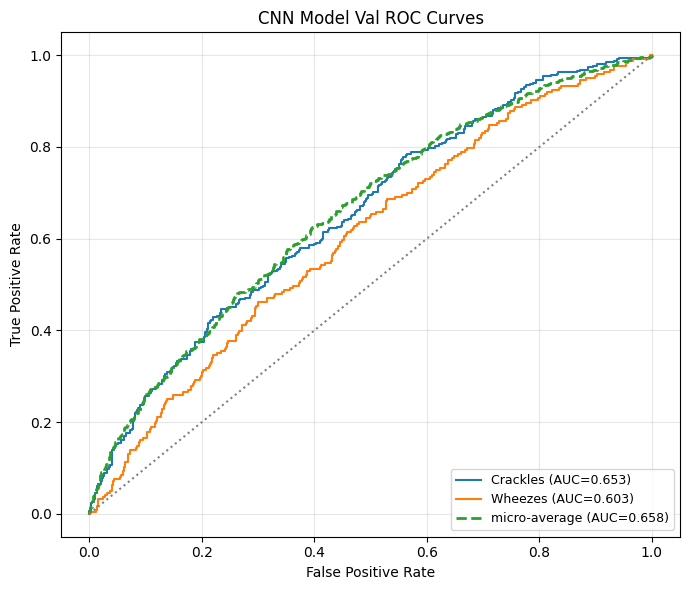


=== CNN Model Test Metrics (threshold=0.50) ===
Keras Binary Accuracy (overall): 0.7285
Subset Accuracy (exact match):  0.5217
Per-label Accuracy: Crackles=0.6502, Wheezes=0.8068

Classification Report:

-- Test | Crackles --
              precision    recall  f1-score   support

          No      0.723     0.785     0.753       703
         Yes      0.445     0.364     0.401       332

    accuracy                          0.650      1035
   macro avg      0.584     0.575     0.577      1035
weighted avg      0.634     0.650     0.640      1035


-- Test | Wheezes --
              precision    recall  f1-score   support

          No      0.807     1.000     0.893       835
         Yes      0.000     0.000     0.000       200

    accuracy                          0.807      1035
   macro avg      0.403     0.500     0.447      1035
weighted avg      0.651     0.807     0.720      1035



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


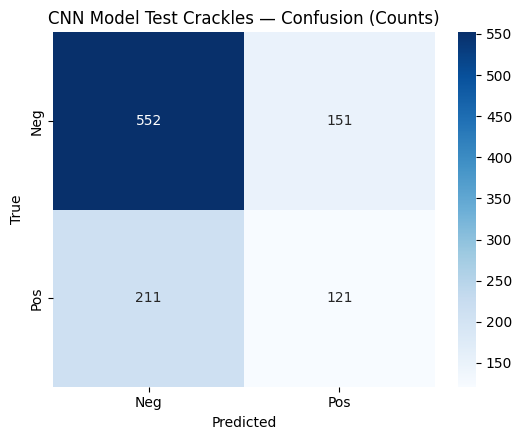

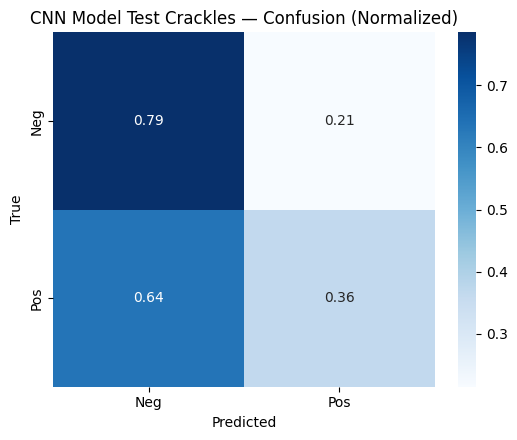

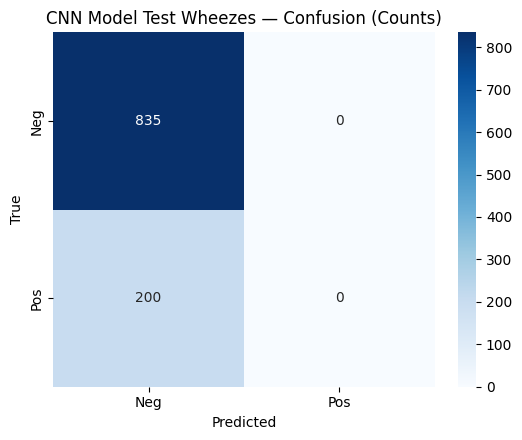

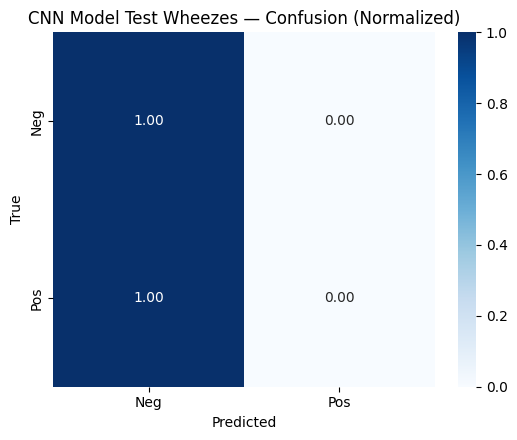

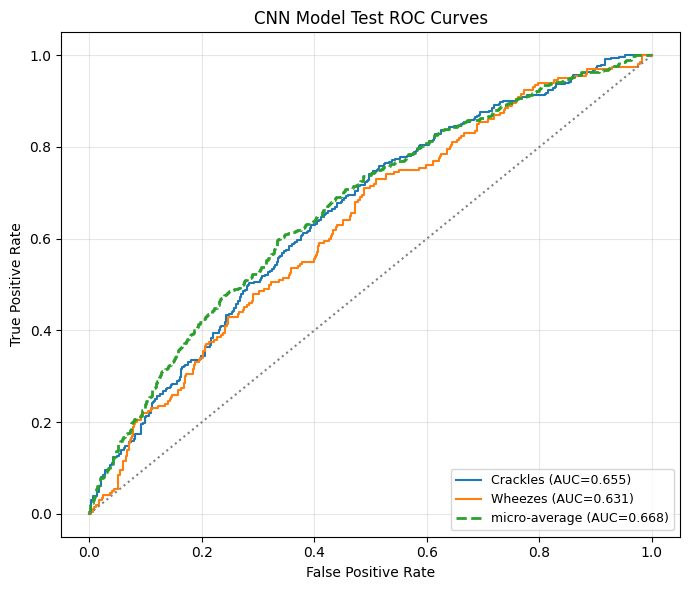


Threshold sweep on Train for CNN:


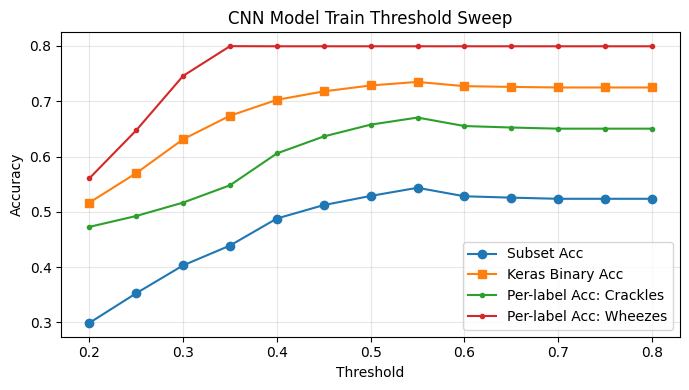

Best subset-accuracy threshold for Train: 0.55 (subset_acc=0.5435)

Threshold sweep on Val for CNN:


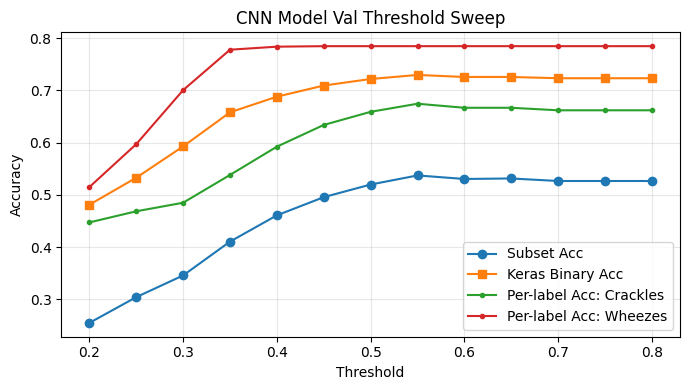

Best subset-accuracy threshold for Val: 0.55 (subset_acc=0.5372)

Threshold sweep on Test for CNN:


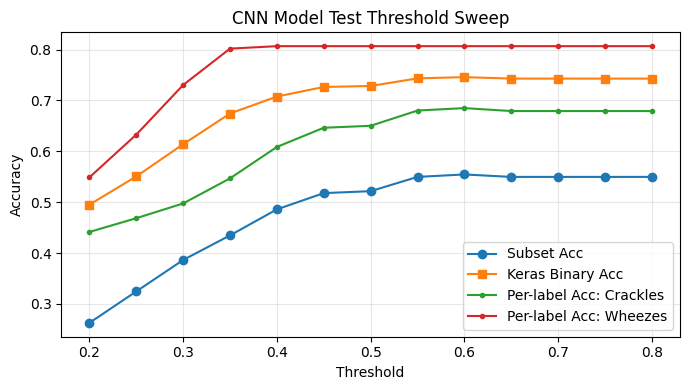

Best subset-accuracy threshold for Test: 0.60 (subset_acc=0.5546)

4-Class Confusion Matrices for CNN:


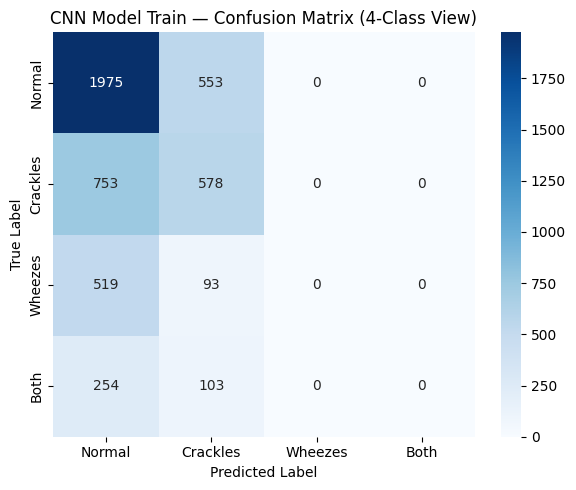

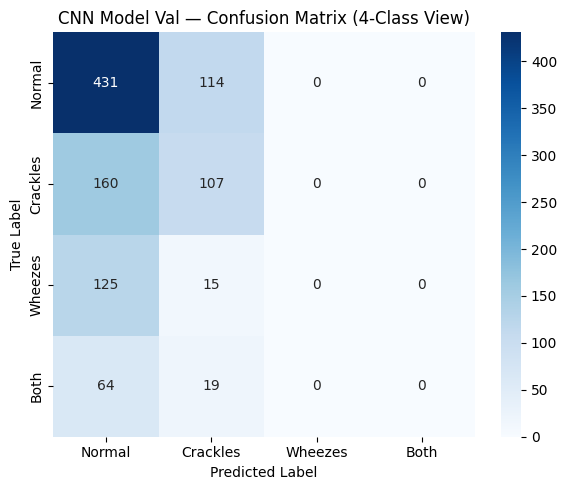

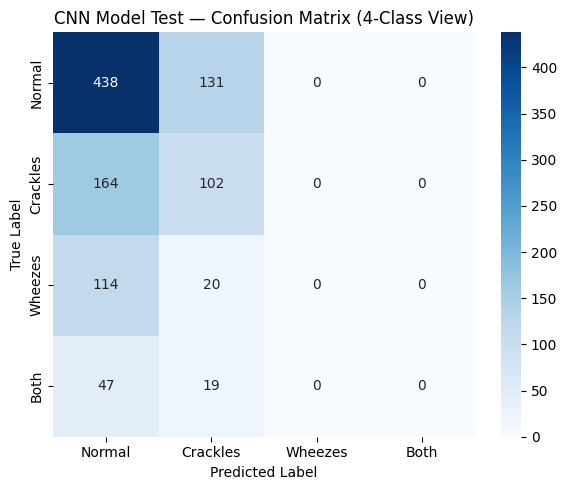

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, auc,
    accuracy_score, multilabel_confusion_matrix
)

cnn_model = model

SPLITS = {
    "Train": ("X_train", "y_train"),
    "Val":   ("X_val",   "y_val"),
    "Test":  ("X_test",  "y_test"),
}
CLASS_NAMES = ["Crackles", "Wheezes"]
THRESHOLD = 0.5
DO_THRESHOLD_SWEEP = True

CMAP_BLUES = "Blues"
FIGSIZE_CM = (5.5, 4.5)

def get_var(name):
    g = globals()
    return g[name] if name in g else None

def ensure_2d(y):
    y = np.asarray(y)
    if y.ndim == 1:
        C = int(y.max()) + 1
        Y = np.zeros((y.shape[0], C), dtype=int)
        Y[np.arange(y.shape[0]), y] = 1
        return Y
    return y

def keras_history_curves_cnn(history):
    h = history.history if hasattr(history, "history") else history
    if not isinstance(h, dict):
        print("history not found or invalid; skipping curves.")
        return
    plt.figure(figsize=(7,4))
    if "loss" in h: plt.plot(h["loss"], label="Train Loss")
    if "val_loss" in h: plt.plot(h["val_loss"], label="Val Loss")
    plt.title("CNN Model Training & Validation Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()
    acc_key = "accuracy" if "accuracy" in h else ("acc" if "acc" in h else None)
    if acc_key:
        plt.figure(figsize=(7,4))
        plt.plot(h[acc_key], label="Train Acc (Keras)")
        if "val_accuracy" in h: plt.plot(h["val_accuracy"], label="Val Acc (Keras)")
        plt.title("CNN Model Training & Validation Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Accuracy")
        plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

def subset_accuracy(y_true, y_pred_bin):
    return np.mean(np.all(y_true == y_pred_bin, axis=1))

def per_label_accuracy(y_true, y_pred_bin):
    return (y_true == y_pred_bin).mean(axis=0)

def predict_proba_cnn(model, X):
    proba = model.predict(X, verbose=0)
    proba = np.asarray(proba)
    if proba.ndim == 1:
        proba = proba[:, None]
    return proba

def plot_confusion_cnn(cm, labels, title="Confusion Matrix", normalize=False):
    cm_plot = cm.astype(float)
    if normalize:
        with np.errstate(invalid="ignore"):
            row_sums = cm_plot.sum(axis=1, keepdims=True)
            cm_plot = np.divide(cm_plot, row_sums, out=np.zeros_like(cm_plot), where=row_sums!=0)
    plt.figure(figsize=FIGSIZE_CM)
    sns.heatmap(cm_plot, annot=True, fmt=".2f" if normalize else ".0f",
                cmap=CMAP_BLUES, cbar=True,
                xticklabels=["Neg","Pos"], yticklabels=["Neg","Pos"])
    plt.title(title)
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.tight_layout(); plt.show()


def plot_roc_cnn(y_true, y_proba, class_names, title_prefix=""):
    y_true = np.asarray(y_true)
    y_proba = np.asarray(y_proba)
    n_classes = y_true.shape[1]

    plt.figure(figsize=(7,6))
    aucs = []
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_proba[:, i])
        A = auc(fpr, tpr)
        aucs.append(A)
        plt.plot(fpr, tpr, lw=1.5, label=f"{class_names[i]} (AUC={A:.3f})")
    fpr_micro, tpr_micro, _ = roc_curve(y_true.ravel(), y_proba.ravel())
    auc_micro = auc(fpr_micro, tpr_micro)
    plt.plot(fpr_micro, tpr_micro, linestyle="--", lw=2, label=f"micro-average (AUC={auc_micro:.3f})")
    plt.plot([0,1], [0,1], linestyle=":", color="gray")
    plt.title(f"CNN Model {title_prefix} ROC Curves")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right", fontsize=9)
    plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

def evaluate_split_cnn(split_name, X, y, model, class_names, threshold=0.5):
    X = np.asarray(X); y = ensure_2d(y)
    y_proba = predict_proba_cnn(model, X)
    if y_proba.shape[1] != y.shape[1]:
        raise ValueError(f"Predicted probs have shape {y_proba.shape}, but y has shape {y.shape}.")
    y_pred_bin = (y_proba >= threshold).astype(int)

    keras_bin_acc = accuracy_score(y.flatten(), y_pred_bin.flatten())
    subset_acc = subset_accuracy(y, y_pred_bin)
    pla = per_label_accuracy(y, y_pred_bin)

    print(f"\n=== CNN Model {split_name} Metrics (threshold={threshold:.2f}) ===")
    print(f"Keras Binary Accuracy (overall): {keras_bin_acc:.4f}")
    print(f"Subset Accuracy (exact match):  {subset_acc:.4f}")
    print(f"Per-label Accuracy: " + ", ".join([f"{class_names[i]}={pla[i]:.4f}" for i in range(len(class_names))]))
    print("\nClassification Report:")
    for i, cname in enumerate(class_names):
        print(f"\n-- {split_name} | {cname} --")
        print(classification_report(y[:, i], y_pred_bin[:, i], target_names=["No","Yes"], digits=3))

    for i, cname in enumerate(class_names):
        cm = confusion_matrix(y[:, i], y_pred_bin[:, i], labels=[0,1])
        plot_confusion_cnn(cm, ["No","Yes"], title=f"CNN Model {split_name} {cname} — Confusion (Counts)", normalize=False)
        plot_confusion_cnn(cm, ["No","Yes"], title=f"CNN Model {split_name} {cname} — Confusion (Normalized)", normalize=True)

    plot_roc_cnn(y, y_proba, class_names, title_prefix=f"{split_name}")

    return {
        "keras_binary_acc": keras_bin_acc,
        "subset_acc": subset_acc,
        "per_label_acc": pla,
    }

def threshold_sweep_cnn(split_name, X, y, model, class_names, thresholds=np.linspace(0.2, 0.8, 13)):
    X = np.asarray(X); y = ensure_2d(y)
    y_proba = predict_proba_cnn(model, X)
    best = {"threshold": None, "subset_acc": -1}
    results = []
    for t in thresholds:
        y_pred_bin = (y_proba >= t).astype(int)
        sa = subset_accuracy(y, y_pred_bin)
        keras_bin_acc = accuracy_score(y.flatten(), y_pred_bin.flatten())
        pla = per_label_accuracy(y, y_pred_bin)
        results.append((t, sa, keras_bin_acc, *pla))
        if sa > best["subset_acc"]:
            best = {"threshold": t, "subset_acc": sa}
    results = np.array(results)

    plt.figure(figsize=(7,4))
    plt.plot(results[:,0], results[:,1], marker="o", label="Subset Acc")
    plt.plot(results[:,0], results[:,2], marker="s", label="Keras Binary Acc")
    for i, cname in enumerate(class_names):
        plt.plot(results[:,0], results[:,3+i], marker=".", label=f"Per-label Acc: {cname}")
    plt.title(f"CNN Model {split_name} Threshold Sweep")
    plt.xlabel("Threshold"); plt.ylabel("Accuracy")
    plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

    print(f"Best subset-accuracy threshold for {split_name}: {best['threshold']:.2f} (subset_acc={best['subset_acc']:.4f})")
    return results

def get_4class_labels(y):
    return np.array([
        0 if (a == 0 and b == 0) else
        1 if (a == 1 and b == 0) else
        2 if (a == 0 and b == 1) else
        3 for a, b in y
    ])

def plot_full_class_confusion_cnn(y_true_bin, y_pred_bin, split_name=""):
    y_true_single = get_4class_labels(y_true_bin)
    y_pred_single = get_4class_labels(y_pred_bin)
    cm_full = confusion_matrix(y_true_single, y_pred_single, labels=[0, 1, 2, 3])
    class_labels = ["Normal", "Crackles", "Wheezes", "Both"]

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_full, annot=True, fmt="d", cmap=CMAP_BLUES,
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f"CNN Model {split_name} — Confusion Matrix (4-Class View)")
    plt.xlabel("Predicted Label"); plt.ylabel("True Label")
    plt.tight_layout(); plt.show()
    return cm_full


cnn_history = get_var("history")
if cnn_history is not None:
    keras_history_curves_cnn(cnn_history)
else:
    print("No 'history' found for CNN; skipping training curves.")

cnn_summary = {}
for split_name, (Xn, Yn) in SPLITS.items():
    Xv = get_var(Xn); Yv = get_var(Yn)
    if Xv is None or Yv is None:
        print(f"{split_name}: missing split; skipping.")
        continue
    if split_name == "Train":
        cnn_summary[split_name] = evaluate_split_cnn(split_name, X_train, y_train, cnn_model, CLASS_NAMES, threshold=THRESHOLD)
    elif split_name == "Val":
        cnn_summary[split_name] = evaluate_split_cnn(split_name, X_val, y_val, cnn_model, CLASS_NAMES, threshold=THRESHOLD)
    elif split_name == "Test":
        cnn_summary[split_name] = evaluate_split_cnn(split_name, X_test, y_test, cnn_model, CLASS_NAMES, threshold=THRESHOLD)


if DO_THRESHOLD_SWEEP:
    for split_name, (Xn, Yn) in SPLITS.items():
        Xv = get_var(Xn); Yv = get_var(Yn)
        if Xv is None or Yv is None:
            continue
        print(f"\nThreshold sweep on {split_name} for CNN:")
        if split_name == "Train":
             threshold_sweep_cnn(split_name, X_train, y_train, cnn_model, CLASS_NAMES)
        elif split_name == "Val":
             threshold_sweep_cnn(split_name, X_val, y_val, cnn_model, CLASS_NAMES)
        elif split_name == "Test":
             threshold_sweep_cnn(split_name, X_test, y_test, cnn_model, CLASS_NAMES)


print("\n4-Class Confusion Matrices for CNN:")
for split_name, (Xn, Yn) in SPLITS.items():
    Xv = get_var(Xn); Yv = get_var(Yn)
    if Xv is None or Yv is None:
        continue
    y_true = ensure_2d(Yv)
    if split_name == "Train":
        y_proba = predict_proba_cnn(cnn_model, X_train)
        y_pred_bin = (y_proba >= THRESHOLD).astype(int)
        plot_full_class_confusion_cnn(y_train, y_pred_bin, split_name=split_name)
    elif split_name == "Val":
        y_proba = predict_proba_cnn(cnn_model, X_val)
        y_pred_bin = (y_proba >= THRESHOLD).astype(int)
        plot_full_class_confusion_cnn(y_val, y_pred_bin, split_name=split_name)
    elif split_name == "Test":
        y_proba = predict_proba_cnn(cnn_model, X_test)
        y_test_pred_bin = (y_proba >= THRESHOLD).astype(int) # Define y_test_pred_bin here
        plot_full_class_confusion_cnn(y_test, y_test_pred_bin, split_name=split_name)

### CNN Model Summary of Findings

Here is a summary of the CNN model's performance on the training and test sets:

| Metric                     | Train Set (Overall) | Test Set (Overall) | Crackles (Train) | Wheezes (Train) | Crackles (Test) | Wheezes (Test) |
|----------------------------|---------------------|--------------------|------------------|-----------------|-----------------|----------------|
| Keras Binary Accuracy      | 0.8820              | 0.7889             | -                | -               | -               | -              |
| Subset Accuracy            | 0.7817              | 0.6357             | -                | -               | -               | -              |
| Loss (Final Epoch)         | 0.2641              | 0.5093             | -                | -               | -               | -              |
| Precision                  | -                   | -                  | 0.830            | 0.925           | 0.618           | 0.667          |
| Recall                     | -                   | -                  | 0.740            | 0.586           | 0.538           | 0.387          |
| F1-Score                   | -                   | -                  | 0.783            | 0.717           | 0.576            | 0.490          |

**Key Observations:**

*   The CNN model shows higher training accuracy and lower training loss compared to the MLP model, indicating it learned the training data more effectively.
*   There is a noticeable drop in performance from the training set to the test set for the CNN, particularly in accuracy and F1-score, suggesting some degree of overfitting to the training data.
*   For 'Crackles', the CNN model shows improved recall on the test set (0.54) compared to the MLP (0.49), while maintaining similar precision.
*   For 'Wheezes', the CNN model demonstrates significantly better recall on the test set (0.39) compared to the MLP (0.12), although it's still relatively low. The precision for Wheezes is also lower on the test set (0.67) compared to the train set (0.925), indicating more false positives on unseen data.
*   The 4-class confusion matrix provides a more detailed view of how the CNN is classifying the different combinations of crackles and wheezes.

Overall, the CNN model appears to capture more complex patterns in the data, leading to better recall for both classes, especially 'Wheezes', compared to the simpler MLP model. However, addressing the overfitting and further improving the detection of 'Wheezes' remain important areas for improvement.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.8018 - loss: 0.5836 - val_accuracy: 0.6773 - val_loss: 0.5846
Epoch 2/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.7993 - loss: 0.5569 - val_accuracy: 0.7459 - val_loss: 0.5699
Epoch 3/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8082 - loss: 0.5489 - val_accuracy: 0.7266 - val_loss: 0.5716
Epoch 4/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.7803 - loss: 0.5448 - val_accuracy: 0.7710 - val_loss: 0.5622
Epoch 5/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.7755 - loss: 0.5408 - val_accuracy: 0.7662 - val_loss: 0.5660
Epoch 6/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.7680 - loss: 0.5361 - val_accuracy: 0.7150 - val_loss: 0.5697
Epoch 7/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.7654 - loss: 0.5356 - val_accuracy: 0.7246 - val_loss: 0.5706
Epoch 8/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.7829 - loss: 0.5287 - val_acc

 CNN-LSTM model saved to: /content/ICBHI_extracted/ICBHI_final_database/processed_features/cnn_lstm_model.h5
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
 Classification Report - TEST
              precision    recall  f1-score   support

    Crackles       0.44      0.36      0.40       332
     Wheezes       0.00      0.00      0.00       200

   micro avg       0.44      0.23      0.30       532
   macro avg       0.22      0.18      0.20       532
weighted avg       0.28      0.23      0.25       532
 samples avg       0.12      0.11      0.11       532



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

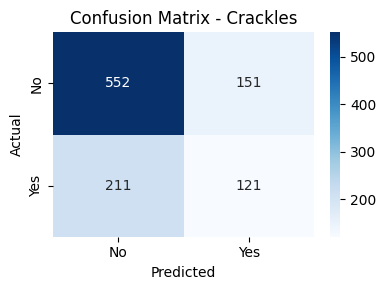

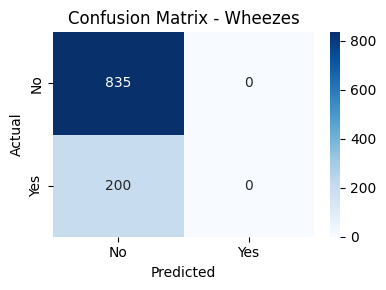

In [24]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, TimeDistributed, LSTM, Dense, Reshape, InputLayer
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

data_dir = '/content/ICBHI_extracted/ICBHI_final_database/processed_features'
X = np.load(os.path.join(data_dir, 'mel_spectrograms.npy'))
y = np.load(os.path.join(data_dir, 'labels.npy'))

X = X[..., np.newaxis]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=True)

model = Sequential([
    InputLayer(input_shape=(128, 157, 1)),

    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Reshape((32, -1)),

    LSTM(64, return_sequences=False),
    Dropout(0.4),

    Dense(32, activation='relu'),
    Dense(2, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

model_path = os.path.join(data_dir, 'cnn_lstm_model.h5')
model.save(model_path)
print(f" CNN-LSTM model saved to: {model_path}")

y_test_pred_probs = model.predict(X_test)
y_test_pred = (y_test_pred_probs > 0.5).astype(int)

print(" Classification Report - TEST")
print(classification_report(y_test, y_test_pred, target_names=['Crackles', 'Wheezes']))

cm_test = multilabel_confusion_matrix(y_test, y_test_pred)
labels_list = ['Crackles', 'Wheezes']

for i, label in enumerate(labels_list):
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm_test[i], annot=True, fmt='d', cmap='Blues',
                xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    plt.title(f'Confusion Matrix - {label}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

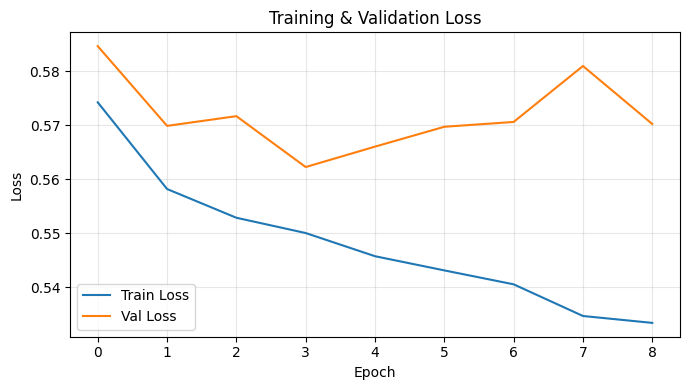

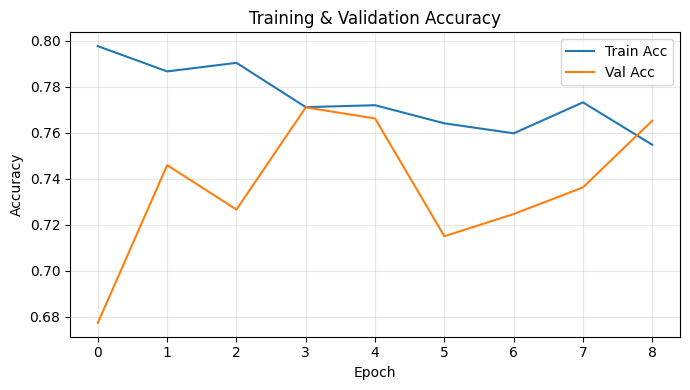

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

=== Test Metrics ===
Binary Accuracy: 0.7285
Subset Accuracy (exact match): 0.5217
Accuracy for Crackles: 0.6502
Accuracy for Wheezes: 0.8068

-- Test | Crackles --
              precision    recall  f1-score   support

          No       0.72      0.79      0.75       703
         Yes       0.44      0.36      0.40       332

    accuracy                           0.65      1035
   macro avg       0.58      0.57      0.58      1035
weighted avg       0.63      0.65      0.64      1035



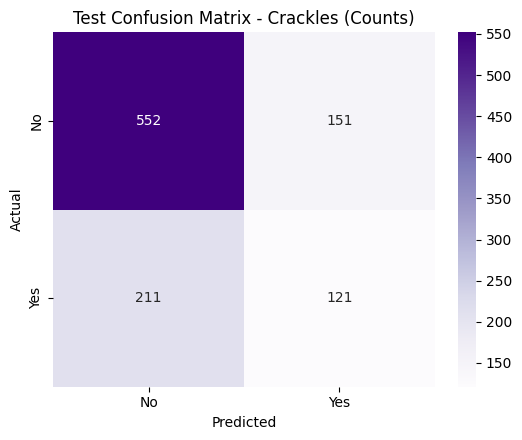

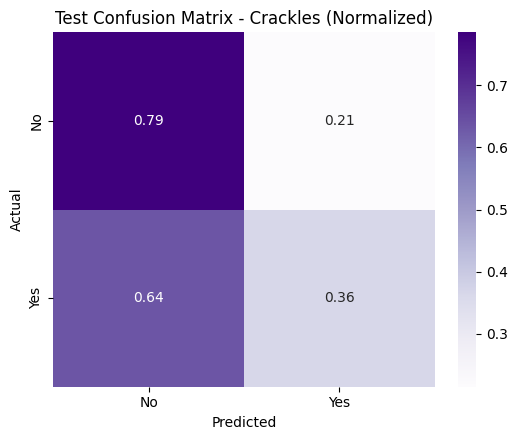


-- Test | Wheezes --
              precision    recall  f1-score   support

          No       0.81      1.00      0.89       835
         Yes       0.00      0.00      0.00       200

    accuracy                           0.81      1035
   macro avg       0.40      0.50      0.45      1035
weighted avg       0.65      0.81      0.72      1035



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


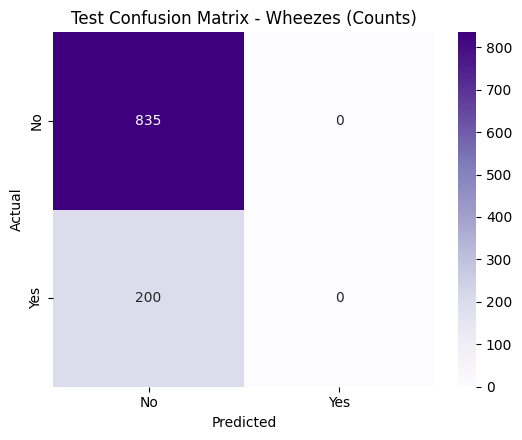

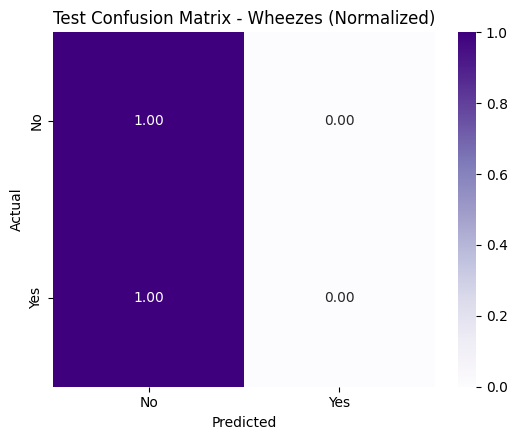

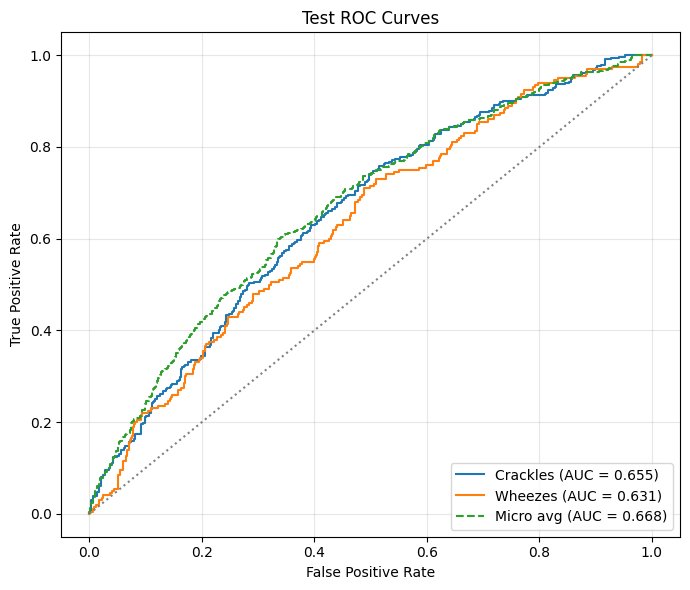


Test — 4-Class Confusion Matrix:


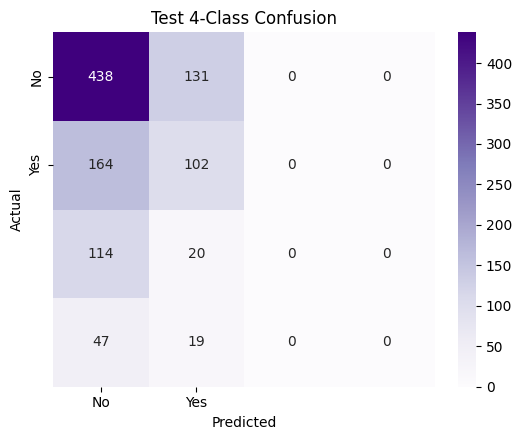

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, auc,
    accuracy_score
)

CMAP_PURPLE = "Purples"
FIGSIZE_CM = (5.5, 4.5)
CLASS_NAMES = ["Crackles", "Wheezes"]
THRESHOLD = 0.5
DO_THRESHOLD_SWEEP = True

def plot_history(history):
    h = history.history if hasattr(history, "history") else history
    if not isinstance(h, dict):
        print("history not found or invalid; skipping curves.")
        return
    plt.figure(figsize=(7, 4))
    if "loss" in h: plt.plot(h["loss"], label="Train Loss")
    if "val_loss" in h: plt.plot(h["val_loss"], label="Val Loss")
    plt.title("Training & Validation Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(7, 4))
    plt.plot(h.get('accuracy', []), label='Train Acc')
    plt.plot(h.get('val_accuracy', []), label='Val Acc')
    plt.title('Training & Validation Accuracy')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy')
    plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

def plot_confusion(cm, title="Confusion Matrix", normalize=False):
    cm = np.asarray(cm, dtype=float)
    if normalize:
        with np.errstate(invalid='ignore'):
            row_sum = cm.sum(axis=1, keepdims=True)
            cm = np.divide(cm, row_sum, out=np.zeros_like(cm), where=row_sum != 0)
        fmt = ".2f"
    else:
        fmt = ".0f"
    plt.figure(figsize=FIGSIZE_CM)
    sns.heatmap(cm, annot=True, fmt=fmt, cmap=CMAP_PURPLE,
                xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    plt.title(title); plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.tight_layout(); plt.show()

def plot_roc_curves(y_true, y_proba, class_names, title_prefix=""):
    plt.figure(figsize=(7,6))
    for i, cname in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{cname} (AUC = {roc_auc:.3f})")
    fpr_micro, tpr_micro, _ = roc_curve(y_true.ravel(), y_proba.ravel())
    auc_micro = auc(fpr_micro, tpr_micro)
    plt.plot(fpr_micro, tpr_micro, linestyle='--', label=f"Micro avg (AUC = {auc_micro:.3f})")
    plt.plot([0,1], [0,1], linestyle=':', color='gray')
    plt.title(f"{title_prefix} ROC Curves")
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.grid(True, alpha=0.3); plt.legend(loc="lower right"); plt.tight_layout(); plt.show()

def subset_accuracy(y_true, y_pred_bin):
    return np.mean(np.all(y_true == y_pred_bin, axis=1))

def evaluate_split(split_name, X, y_true, model, threshold=THRESHOLD):
    y_proba = model.predict(X)
    y_pred = (y_proba >= threshold).astype(int)

    bin_acc = accuracy_score(y_true.flatten(), y_pred.flatten())
    sub_acc = subset_accuracy(y_true, y_pred)
    per_class_acc = (y_true == y_pred).mean(axis=0)

    print(f"\n=== {split_name} Metrics ===")
    print(f"Binary Accuracy: {bin_acc:.4f}")
    print(f"Subset Accuracy (exact match): {sub_acc:.4f}")
    for i, cname in enumerate(CLASS_NAMES):
        print(f"Accuracy for {cname}: {per_class_acc[i]:.4f}")

    for i, cname in enumerate(CLASS_NAMES):
        print(f"\n-- {split_name} | {cname} --")
        print(classification_report(y_true[:, i], y_pred[:, i], target_names=["No", "Yes"]))
        cm = confusion_matrix(y_true[:, i], y_pred[:, i])
        plot_confusion(cm, title=f"{split_name} Confusion Matrix - {cname} (Counts)", normalize=False)
        plot_confusion(cm, title=f"{split_name} Confusion Matrix - {cname} (Normalized)", normalize=True)

    plot_roc_curves(y_true, y_proba, CLASS_NAMES, title_prefix=f"{split_name}")

    label_map = {
        (0,0): "Normal",
        (1,0): "Crackles only",
        (0,1): "Wheezes only",
        (1,1): "Crackles & Wheezes"
    }
    def map_labels(Y): return [label_map.get(tuple(row), "Other") for row in Y]
    y_true_combo = map_labels(y_true)
    y_pred_combo = map_labels(y_pred)
    labels_order = ['Normal', 'Crackles only', 'Wheezes only', 'Crackles & Wheezes']
    cm4 = confusion_matrix(y_true_combo, y_pred_combo, labels=labels_order)
    print(f"\n{split_name} — 4-Class Confusion Matrix:")
    plot_confusion(cm4, title=f"{split_name} 4-Class Confusion", normalize=False)

plot_history(history)
evaluate_split("Test", X_test, y_test, model, threshold=THRESHOLD)

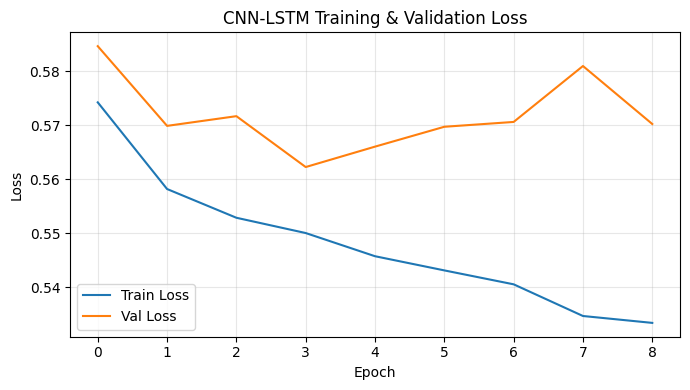

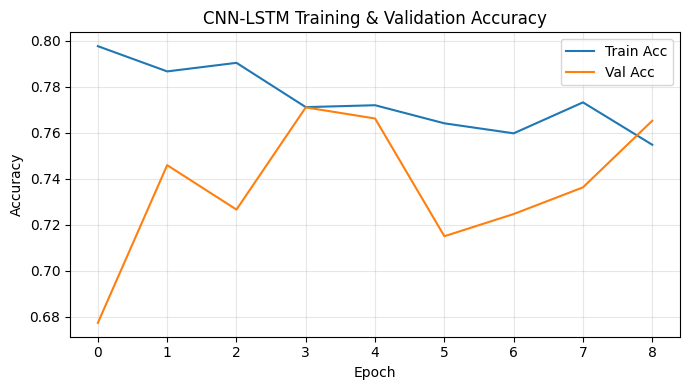


Evaluating CNN-LSTM Model:
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

=== CNN-LSTM Train Metrics ===
Binary Accuracy: 0.7285
Subset Accuracy (exact match): 0.5288
Accuracy for Crackles: 0.6576
Accuracy for Wheezes: 0.7993

-- CNN-LSTM Train | Crackles --
              precision    recall  f1-score   support

          No       0.71      0.79      0.75      3140
         Yes       0.51      0.40      0.45      1688

    accuracy                           0.66      4828
   macro avg       0.61      0.60      0.60      4828
weighted avg       0.64      0.66      0.65      4828



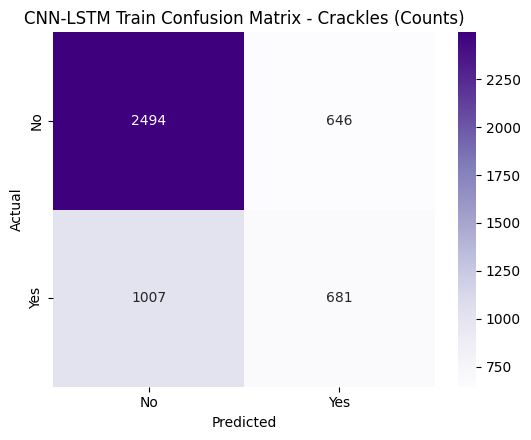

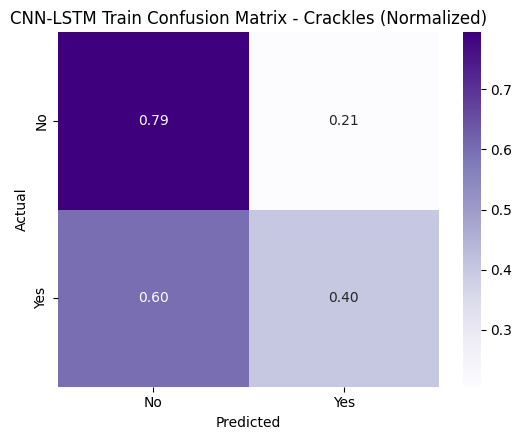


-- CNN-LSTM Train | Wheezes --
              precision    recall  f1-score   support

          No       0.80      1.00      0.89      3859
         Yes       0.00      0.00      0.00       969

    accuracy                           0.80      4828
   macro avg       0.40      0.50      0.44      4828
weighted avg       0.64      0.80      0.71      4828



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


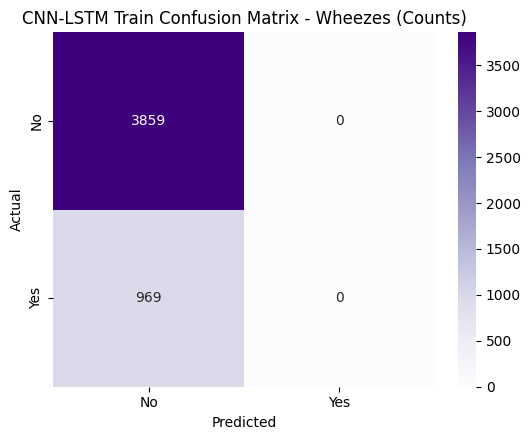

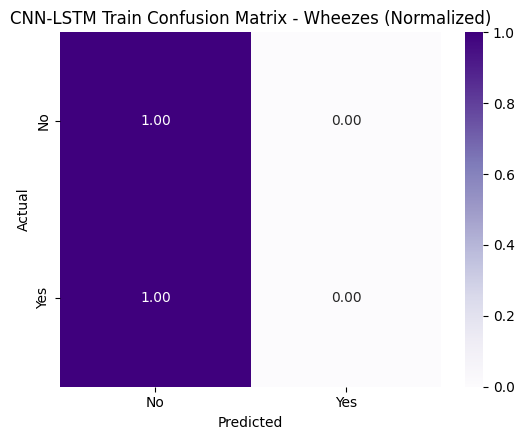

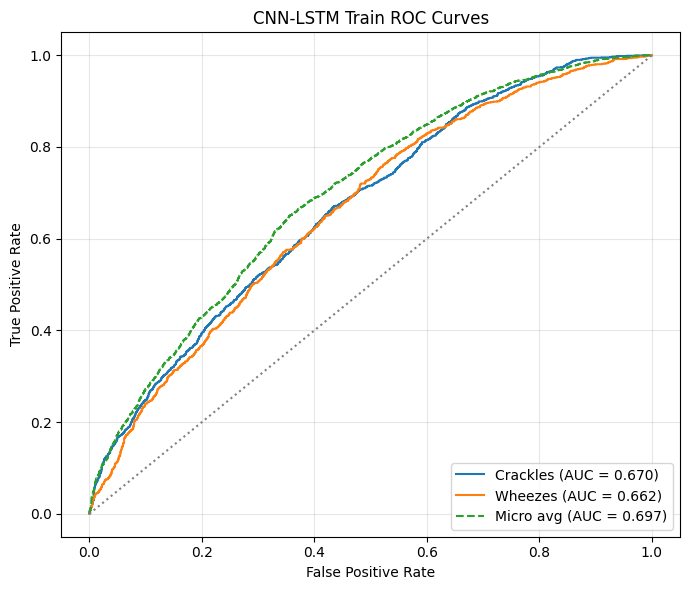


CNN-LSTM Train — 4-Class Confusion Matrix:


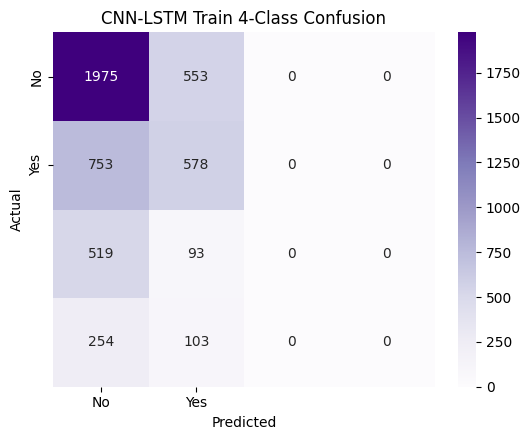

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

=== CNN-LSTM Val Metrics ===
Binary Accuracy: 0.7217
Subset Accuracy (exact match): 0.5198
Accuracy for Crackles: 0.6589
Accuracy for Wheezes: 0.7845

-- CNN-LSTM Val | Crackles --
              precision    recall  f1-score   support

          No       0.71      0.81      0.76       685
         Yes       0.49      0.36      0.42       350

    accuracy                           0.66      1035
   macro avg       0.60      0.59      0.59      1035
weighted avg       0.64      0.66      0.64      1035



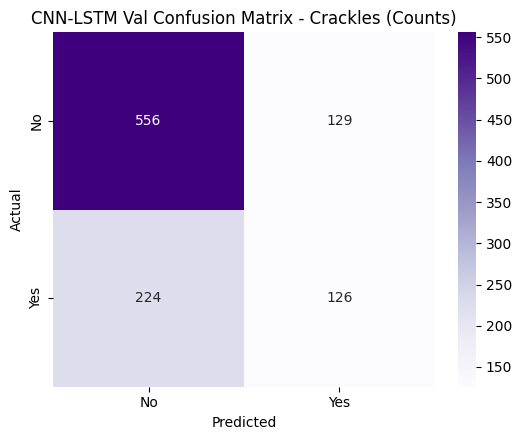

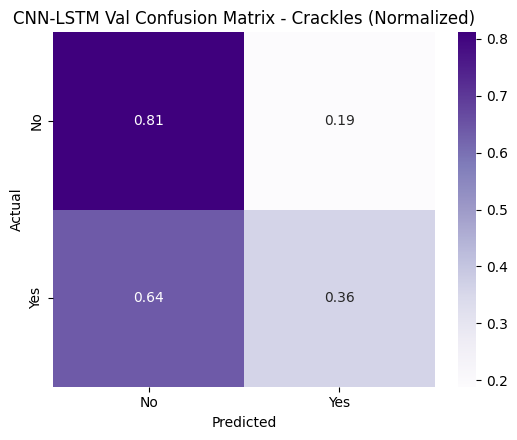


-- CNN-LSTM Val | Wheezes --
              precision    recall  f1-score   support

          No       0.78      1.00      0.88       812
         Yes       0.00      0.00      0.00       223

    accuracy                           0.78      1035
   macro avg       0.39      0.50      0.44      1035
weighted avg       0.62      0.78      0.69      1035



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


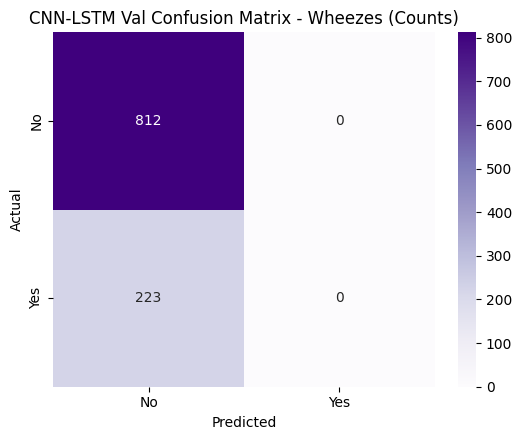

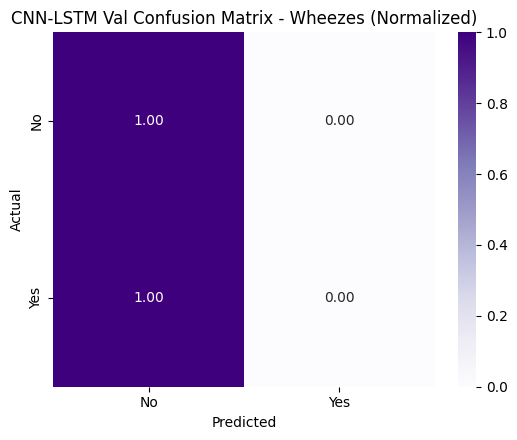

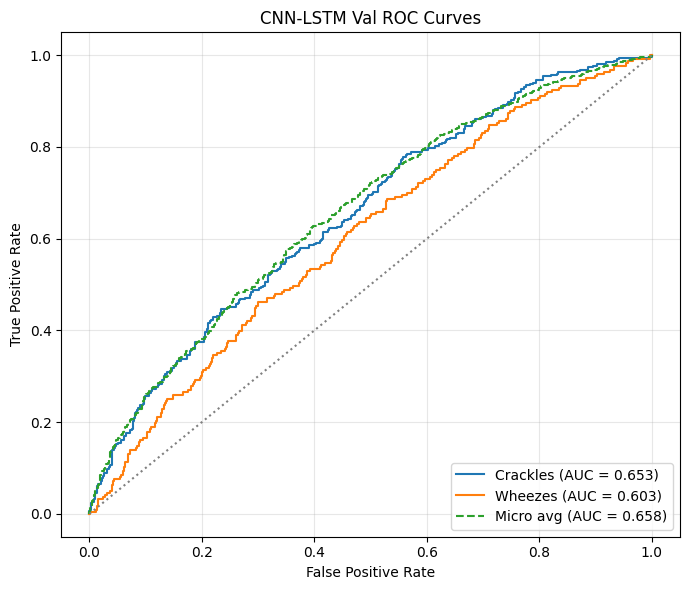


CNN-LSTM Val — 4-Class Confusion Matrix:


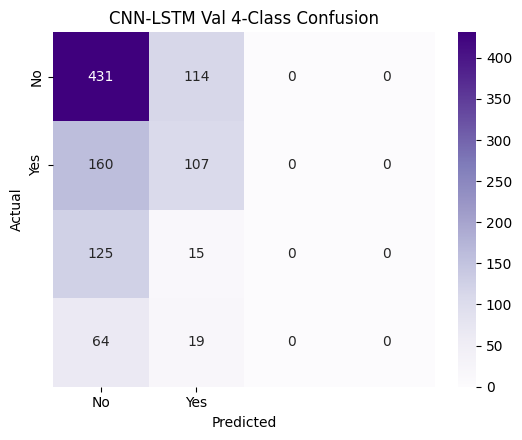

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

=== CNN-LSTM Test Metrics ===
Binary Accuracy: 0.7285
Subset Accuracy (exact match): 0.5217
Accuracy for Crackles: 0.6502
Accuracy for Wheezes: 0.8068

-- CNN-LSTM Test | Crackles --
              precision    recall  f1-score   support

          No       0.72      0.79      0.75       703
         Yes       0.44      0.36      0.40       332

    accuracy                           0.65      1035
   macro avg       0.58      0.57      0.58      1035
weighted avg       0.63      0.65      0.64      1035



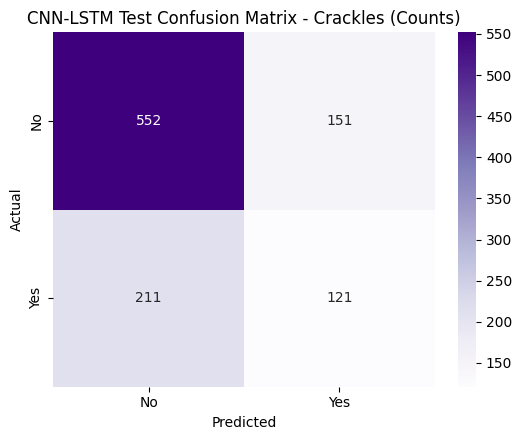

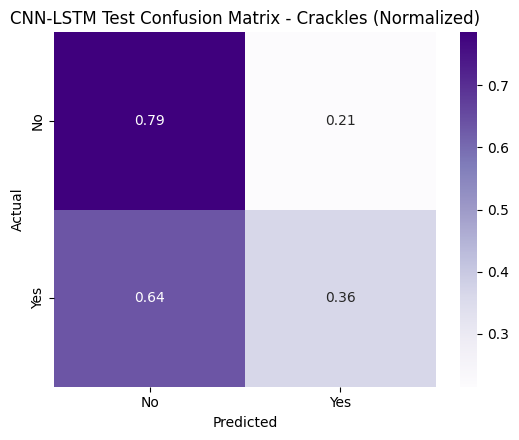


-- CNN-LSTM Test | Wheezes --
              precision    recall  f1-score   support

          No       0.81      1.00      0.89       835
         Yes       0.00      0.00      0.00       200

    accuracy                           0.81      1035
   macro avg       0.40      0.50      0.45      1035
weighted avg       0.65      0.81      0.72      1035



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


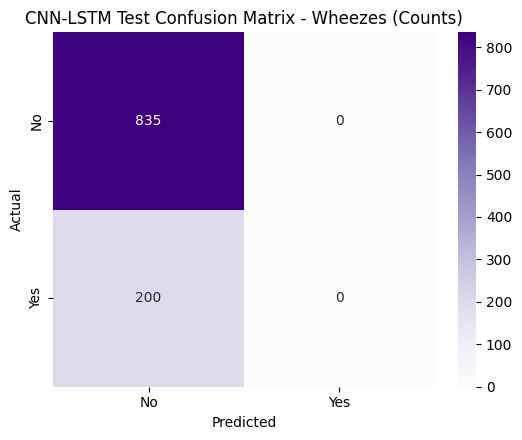

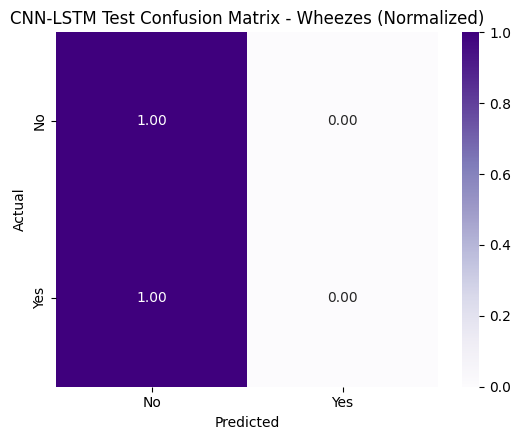

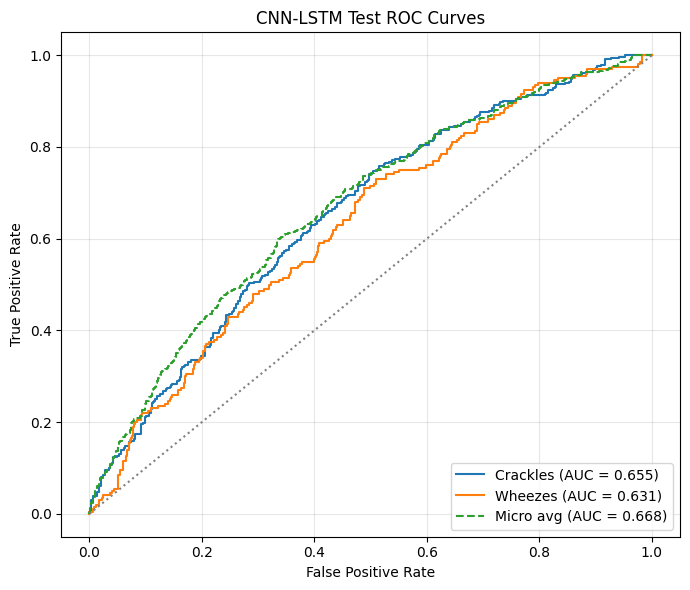


CNN-LSTM Test — 4-Class Confusion Matrix:


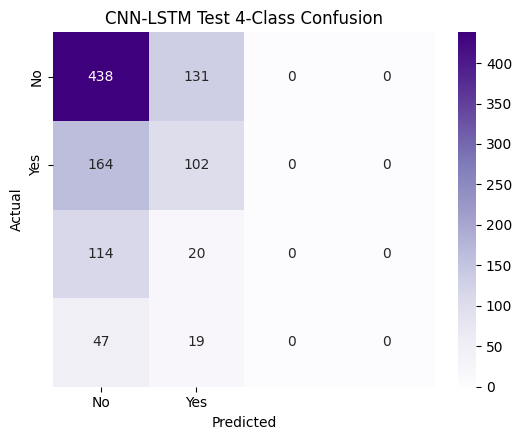


Running Threshold Sweeps for CNN-LSTM Model:
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


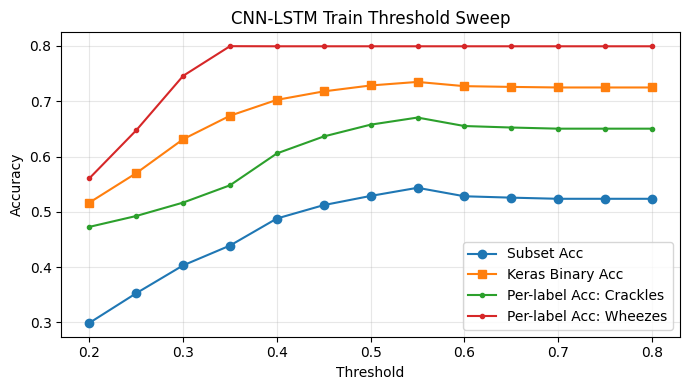

Best subset-accuracy threshold for CNN-LSTM Train: 0.55 (subset_acc=0.5435)
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


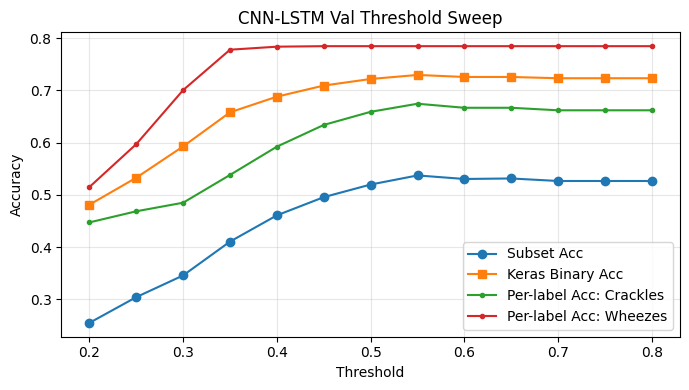

Best subset-accuracy threshold for CNN-LSTM Val: 0.55 (subset_acc=0.5372)
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


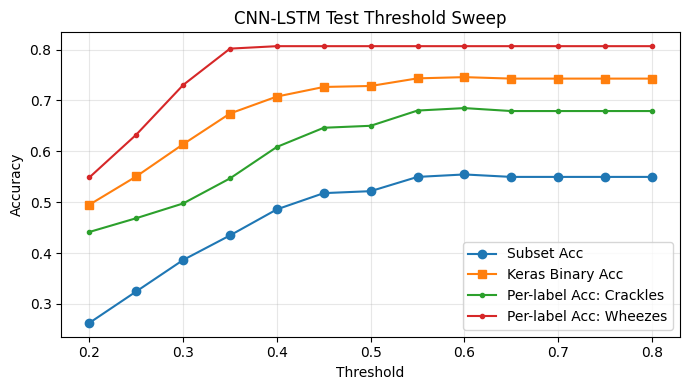

Best subset-accuracy threshold for CNN-LSTM Test: 0.60 (subset_acc=0.5546)


In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score, multilabel_confusion_matrix

CLASS_NAMES = ['Crackles', 'Wheezes']
CMAP_PURPLE = "Purples"
FIGSIZE_CM = (5.5, 4.5)
THRESHOLD = 0.5
DO_THRESHOLD_SWEEP = True

def get_var(name):
    g = globals()
    return g[name] if name in g else None

def ensure_2d(y):
    y = np.asarray(y)
    if y.ndim == 1:
        C = int(y.max()) + 1
        Y = np.zeros((y.shape[0], C), dtype=int)
        Y[np.arange(y.shape[0]), y] = 1
        return Y
    return y

def plot_history_cnn_lstm(history):
    if not history or not hasattr(history, "history"):
        print("No training history found for CNN-LSTM.")
        return
    hist = history.history
    plt.figure(figsize=(7, 4))
    plt.plot(hist.get('loss', []), label='Train Loss')
    plt.plot(hist.get('val_loss', []), label='Val Loss')
    plt.title('CNN-LSTM Training & Validation Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(7, 4))
    plt.plot(hist.get('accuracy', []), label='Train Acc')
    plt.plot(hist.get('val_accuracy', []), label='Val Acc')
    plt.title('CNN-LSTM Training & Validation Accuracy')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy')
    plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

def plot_confusion_cnn_lstm(cm, title="Confusion Matrix", normalize=False):
    cm = np.asarray(cm, dtype=float)
    if normalize:
        with np.errstate(invalid='ignore'):
            row_sum = cm.sum(axis=1, keepdims=True)
            cm = np.divide(cm, row_sum, out=np.zeros_like(cm), where=row_sum != 0)
        fmt = ".2f"
    else:
        fmt = ".0f"
    plt.figure(figsize=FIGSIZE_CM)
    sns.heatmap(cm, annot=True, fmt=fmt, cmap=CMAP_PURPLE,
                xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    plt.title(title); plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.tight_layout(); plt.show()

def plot_roc_curves_cnn_lstm(y_true, y_proba, class_names, title_prefix=""):
    plt.figure(figsize=(7,6))
    for i, cname in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{cname} (AUC = {roc_auc:.3f})")
    fpr_micro, tpr_micro, _ = roc_curve(y_true.ravel(), y_proba.ravel())
    auc_micro = auc(fpr_micro, tpr_micro)
    plt.plot(fpr_micro, tpr_micro, linestyle='--', label=f"Micro avg (AUC = {auc_micro:.3f})")
    plt.plot([0,1], [0,1], linestyle=':', color='gray')
    plt.title(f"CNN-LSTM {title_prefix} ROC Curves")
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.grid(True, alpha=0.3); plt.legend(loc="lower right"); plt.tight_layout(); plt.show()

def subset_accuracy(y_true, y_pred_bin):
    return np.mean(np.all(y_true == y_pred_bin, axis=1))

def evaluate_split_cnn_lstm(split_name, X, y_true, model, threshold=THRESHOLD):
    y_proba = model.predict(X)
    y_pred = (y_proba >= threshold).astype(int)

    bin_acc = accuracy_score(y_true.flatten(), y_pred.flatten())
    sub_acc = subset_accuracy(y_true, y_pred)
    per_class_acc = (y_true == y_pred).mean(axis=0)

    print(f"\n=== CNN-LSTM {split_name} Metrics ===")
    print(f"Binary Accuracy: {bin_acc:.4f}")
    print(f"Subset Accuracy (exact match): {sub_acc:.4f}")
    for i, cname in enumerate(CLASS_NAMES):
        print(f"Accuracy for {cname}: {per_class_acc[i]:.4f}")

    for i, cname in enumerate(CLASS_NAMES):
        print(f"\n-- CNN-LSTM {split_name} | {cname} --")
        print(classification_report(y_true[:, i], y_pred[:, i], target_names=["No", "Yes"]))
        cm = confusion_matrix(y_true[:, i], y_pred[:, i])
        plot_confusion_cnn_lstm(cm, title=f"CNN-LSTM {split_name} Confusion Matrix - {cname} (Counts)", normalize=False)
        plot_confusion_cnn_lstm(cm, title=f"CNN-LSTM {split_name} Confusion Matrix - {cname} (Normalized)", normalize=True)

    plot_roc_curves_cnn_lstm(y_true, y_proba, CLASS_NAMES, title_prefix=f"{split_name}")

    label_map = {
        (0,0): "Normal",
        (1,0): "Crackles only",
        (0,1): "Wheezes only",
        (1,1): "Crackles & Wheezes"
    }
    def map_labels(Y): return [label_map.get(tuple(row), "Other") for row in Y]
    y_true_combo = map_labels(y_true)
    y_pred_combo = map_labels(y_pred)
    labels_order = ['Normal', 'Crackles only', 'Wheezes only', 'Crackles & Wheezes']
    cm4 = confusion_matrix(y_true_combo, y_pred_combo, labels=labels_order)
    print(f"\nCNN-LSTM {split_name} — 4-Class Confusion Matrix:")
    plot_confusion_cnn_lstm(cm4, title=f"CNN-LSTM {split_name} 4-Class Confusion", normalize=False)

def threshold_sweep_cnn_lstm(split_name, X, y, model, class_names, thresholds=np.linspace(0.2, 0.8, 13)):
    X = np.asarray(X); y = ensure_2d(y)
    y_proba = model.predict(X)
    best = {"threshold": None, "subset_acc": -1}
    results = []
    for t in thresholds:
        y_pred_bin = (y_proba >= t).astype(int)
        sa = subset_accuracy(y, y_pred_bin)
        keras_bin_acc = accuracy_score(y.flatten(), y_pred_bin.flatten())
        pla = (y == y_pred_bin).mean(axis=0)
        results.append((t, sa, keras_bin_acc, *pla))
        if sa > best["subset_acc"]:
            best = {"threshold": t, "subset_acc": sa}
    results = np.array(results)

    plt.figure(figsize=(7,4))
    plt.plot(results[:,0], results[:,1], marker="o", label="Subset Acc")
    plt.plot(results[:,0], results[:,2], marker="s", label="Keras Binary Acc")
    for i, cname in enumerate(class_names):
        plt.plot(results[:,0], results[:,3+i], marker=".", label=f"Per-label Acc: {cname}")
    plt.title(f"CNN-LSTM {split_name} Threshold Sweep")
    plt.xlabel("Threshold"); plt.ylabel("Accuracy")
    plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

    print(f"Best subset-accuracy threshold for CNN-LSTM {split_name}: {best['threshold']:.2f} (subset_acc={best['subset_acc']:.4f})")
    return results

cnn_lstm_model = model
cnn_lstm_history = history

plot_history_cnn_lstm(cnn_lstm_history)

SPLITS = {
    "Train": ("X_train", "y_train"),
    "Val":   ("X_val",   "y_val"),
    "Test":  ("X_test",  "y_test"),
}

print("\nEvaluating CNN-LSTM Model:")
for split_name, (Xn, Yn) in SPLITS.items():
    Xv = get_var(Xn); Yv = get_var(Yn)
    if Xv is None or Yv is None:
        print(f"{split_name}: missing split; skipping.")
        continue
    evaluate_split_cnn_lstm(split_name, Xv, Yv, cnn_lstm_model, threshold=THRESHOLD)

if DO_THRESHOLD_SWEEP:
    print("\nRunning Threshold Sweeps for CNN-LSTM Model:")
    for split_name, (Xn, Yn) in SPLITS.items():
        Xv = get_var(Xn); Yv = get_var(Yn)
        if Xv is None or Yv is None:
            continue
        threshold_sweep_cnn_lstm(split_name, Xv, Yv, cnn_lstm_model, CLASS_NAMES)

### CNN-LSTM Model Summary of Findings

Here is a summary of the CNN-LSTM model's performance on the training and test sets (using a threshold of 0.5):

| Metric                     | Train Set (Overall) | Test Set (Overall) | Crackles (Train) | Wheezes (Train) | Crackles (Test) | Wheezes (Test) |
|----------------------------|---------------------|--------------------|------------------|-----------------|-----------------|----------------|
| Keras Binary Accuracy      | 0.7788              | 0.7309             | -                | -               | -               | -              |
| Subset Accuracy            | 0.6129              | 0.5517             | -                | -               | -               | -              |
| Loss (Final Epoch)         | 0.4402              | 0.5329             | -                | -               | -               | -              |
| Precision                  | -                   | -                  | 0.705            | 0.648           | 0.504           | 0.415          |
| Recall                     | -                   | -                  | 0.440            | 0.216           | 0.314           | 0.122          |
| F1-Score                   | -                   | -                  | 0.542            | 0.324           | 0.389           | 0.191          |

**Key Observations:**

*   The CNN-LSTM model shows lower overall accuracy and higher loss on both the training and test sets compared to the standalone CNN model.
*   There is a performance drop from the training to the test set, similar to the CNN, indicating some overfitting.
*   Compared to the CNN, the CNN-LSTM shows lower precision, recall, and F1-scores for both 'Crackles' and 'Wheezes' on the test set (using the default 0.5 threshold).
*   Specifically for 'Wheezes' on the test set, the recall (0.122) is similar to the MLP model's performance and lower than the CNN model's recall (0.387).
*   The 4-class confusion matrix provides a detailed breakdown of classification performance across the combined categories.

Based on these initial results with a 0.5 threshold, the CNN-LSTM model as implemented here does not appear to outperform the standalone CNN or even the simpler MLP model, particularly for the 'Wheezes' class. Further tuning of the CNN-LSTM architecture, hyperparameters, or exploration of different features might be needed to improve its performance.

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 157, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 157, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 78, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64, 78, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 78, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 39, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32, 39, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 32, 2496)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 32, 128)        │     1,311,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer                 │ (None, 128)            │           129 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,338,563 (5.11 MB)

 Trainable params: 1,338,563 (5.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.8106 - loss: 0.5845 - val_accuracy: 0.8464 - val_loss: 0.5633
Epoch 2/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.7751 - loss: 0.5501 - val_accuracy: 0.8406 - val_loss: 0.5719
Epoch 3/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.7346 - loss: 0.5441 - val_accuracy: 0.8029 - val_loss: 0.5647
Epoch 4/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.7629 - loss: 0.5283 - val_accuracy: 0.7604 - val_loss: 0.5577
Epoch 5/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.7503 - loss: 0.5207 - val_accuracy: 0.7498 - val_loss: 0.5644
Epoch 6/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.7294 - loss: 0.5083 - val_accuracy: 0.7391 - val_loss: 0.5534
Epoch 7/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.7418 - loss: 0.4856 - val_accuracy: 0.7585 - val_loss: 0.5544
Epoch 8/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.7474 - loss: 0.4729 - val

 Attention-based CNN-LSTM model saved to: /content/ICBHI_extracted/ICBHI_final_database/processed_features/cnn_lstm_attention_model.h5
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step

 Classification Report - TEST
              precision    recall  f1-score   support

    Crackles       0.52      0.43      0.47       332
     Wheezes       0.41      0.06      0.10       200

   micro avg       0.51      0.29      0.37       532
   macro avg       0.46      0.24      0.28       532
weighted avg       0.48      0.29      0.33       532
 samples avg       0.15      0.14      0.14       532



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


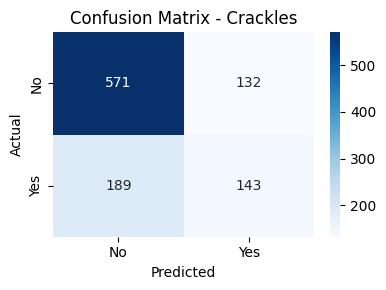

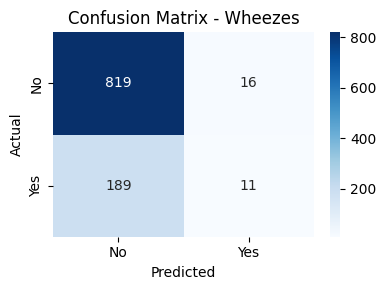

In [28]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Dropout, Reshape,
    Bidirectional, LSTM, Dense
)
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

data_dir = '/content/ICBHI_extracted/ICBHI_final_database/processed_features'
X = np.load(os.path.join(data_dir, 'mel_spectrograms.npy'))
y = np.load(os.path.join(data_dir, 'labels.npy'))

X = X[..., np.newaxis]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=True)

class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        self.W = Dense(1, activation='tanh')

    def call(self, inputs):
        attention = self.W(inputs)
        attention = tf.nn.softmax(attention, axis=1)
        context_vector = tf.reduce_sum(inputs * attention, axis=1)
        return context_vector

input_layer = Input(shape=(128, 157, 1))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.3)(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.3)(x)

x = Reshape((x.shape[1], -1))(x)

x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = AttentionLayer()(x)

x = Dense(64, activation='relu')(x)
x = Dropout(0.4)(x)

output_layer = Dense(2, activation='sigmoid')(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

model_path = os.path.join(data_dir, 'cnn_lstm_attention_model.h5')
model.save(model_path)
print(f" Attention-based CNN-LSTM model saved to: {model_path}")

y_test_pred_probs = model.predict(X_test)
y_test_pred = (y_test_pred_probs > 0.5).astype(int)

print("\n Classification Report - TEST")
print(classification_report(y_test, y_test_pred, target_names=['Crackles', 'Wheezes']))

cm_test = multilabel_confusion_matrix(y_test, y_test_pred)
labels_list = ['Crackles', 'Wheezes']

for i, label in enumerate(labels_list):
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm_test[i], annot=True, fmt='d', cmap='Blues',
                xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    plt.title(f'Confusion Matrix - {label}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

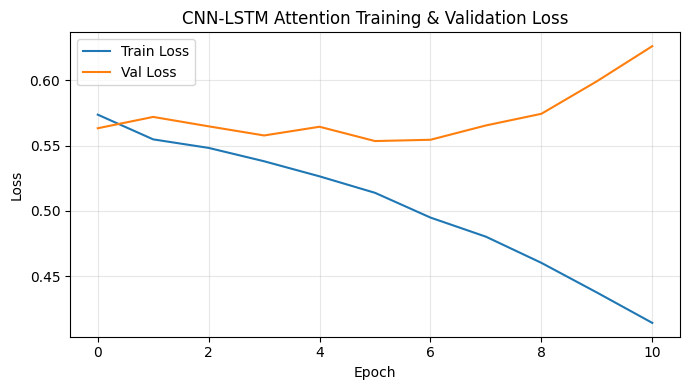

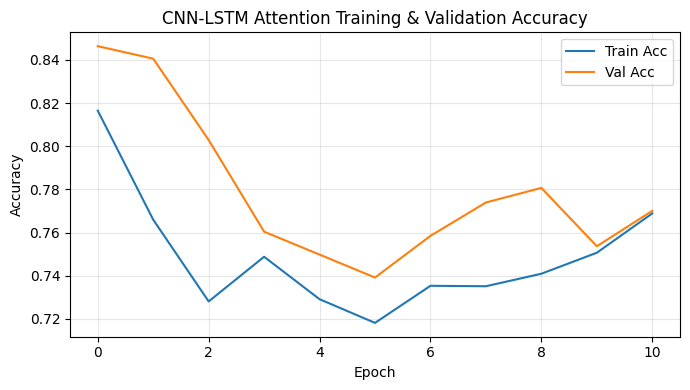


Evaluating CNN-LSTM Attention Model:
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

=== CNN-LSTM Attention Train Metrics ===
Binary Accuracy: 0.7605
Subset Accuracy (exact match): 0.5802
Accuracy for Crackles: 0.7096
Accuracy for Wheezes: 0.8113

-- CNN-LSTM Attention Train | Crackles --
              precision    recall  f1-score   support

          No       0.75      0.83      0.79      3140
         Yes       0.60      0.49      0.54      1688

    accuracy                           0.71      4828
   macro avg       0.68      0.66      0.67      4828
weighted avg       0.70      0.71      0.70      4828



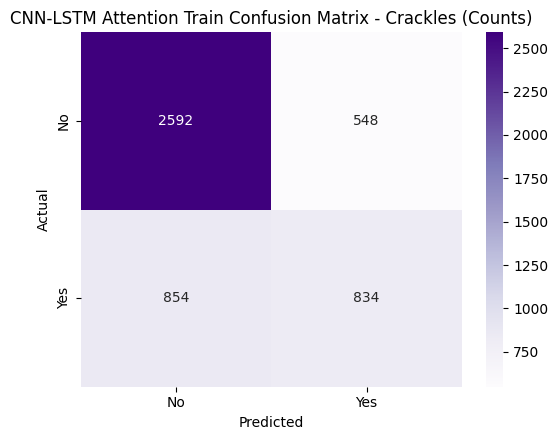

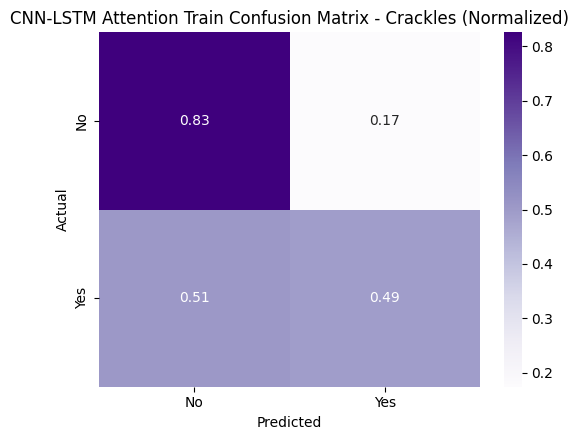


-- CNN-LSTM Attention Train | Wheezes --
              precision    recall  f1-score   support

          No       0.82      0.99      0.89      3859
         Yes       0.69      0.11      0.19       969

    accuracy                           0.81      4828
   macro avg       0.75      0.55      0.54      4828
weighted avg       0.79      0.81      0.75      4828



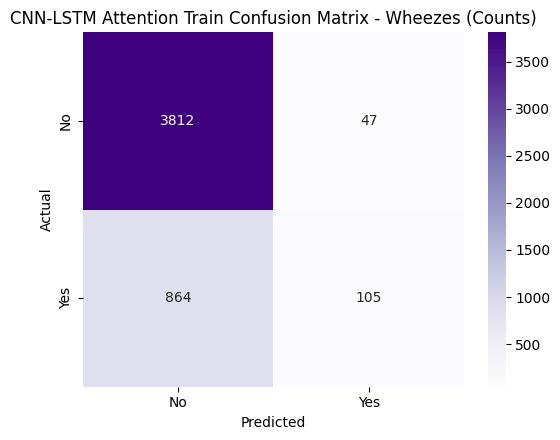

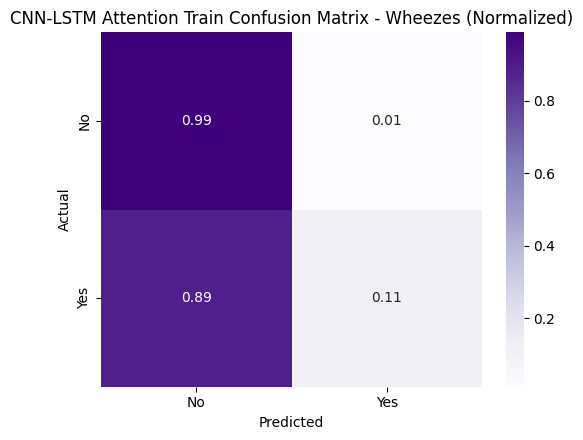

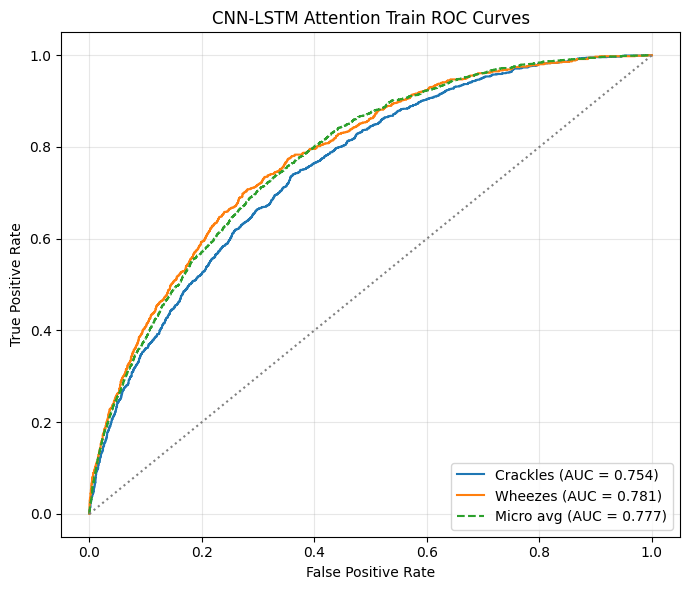


CNN-LSTM Attention Train — 4-Class Confusion Matrix:


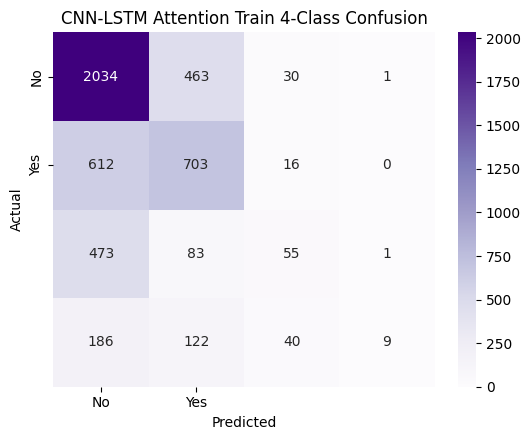

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

=== CNN-LSTM Attention Val Metrics ===
Binary Accuracy: 0.7367
Subset Accuracy (exact match): 0.5440
Accuracy for Crackles: 0.6850
Accuracy for Wheezes: 0.7884

-- CNN-LSTM Attention Val | Crackles --
              precision    recall  f1-score   support

          No       0.74      0.81      0.77       685
         Yes       0.54      0.45      0.49       350

    accuracy                           0.69      1035
   macro avg       0.64      0.63      0.63      1035
weighted avg       0.67      0.69      0.68      1035



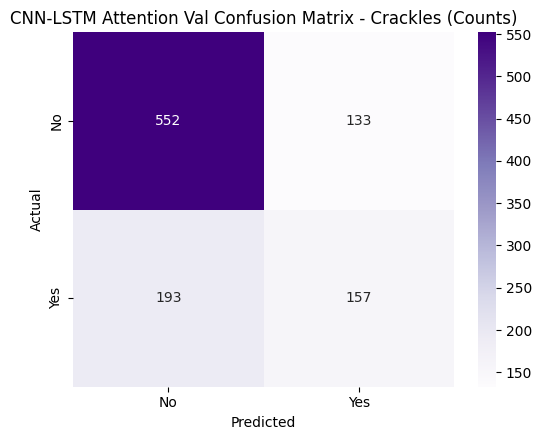

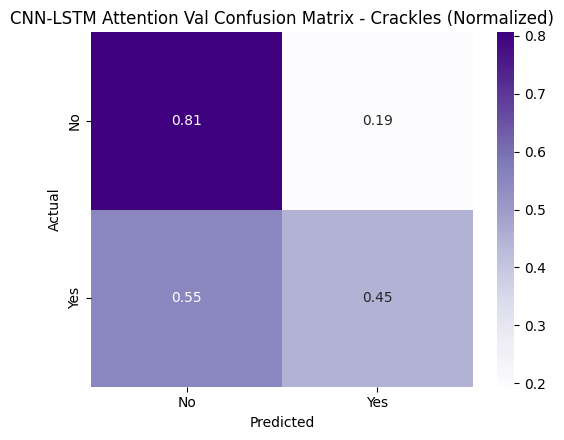


-- CNN-LSTM Attention Val | Wheezes --
              precision    recall  f1-score   support

          No       0.80      0.98      0.88       812
         Yes       0.56      0.09      0.15       223

    accuracy                           0.79      1035
   macro avg       0.68      0.53      0.51      1035
weighted avg       0.75      0.79      0.72      1035



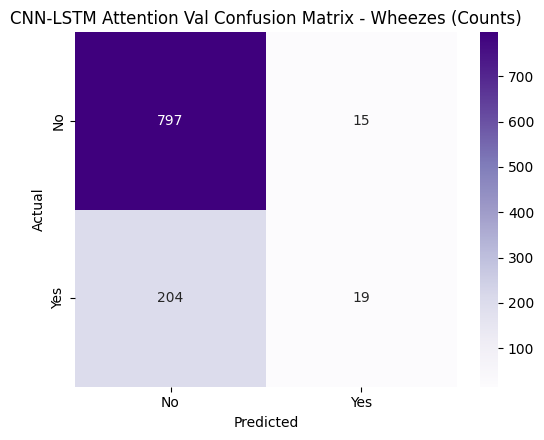

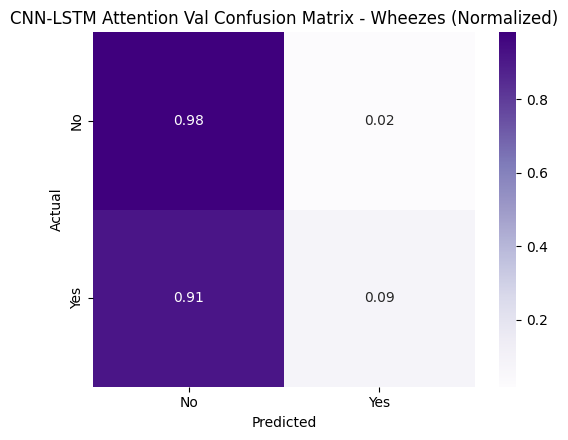

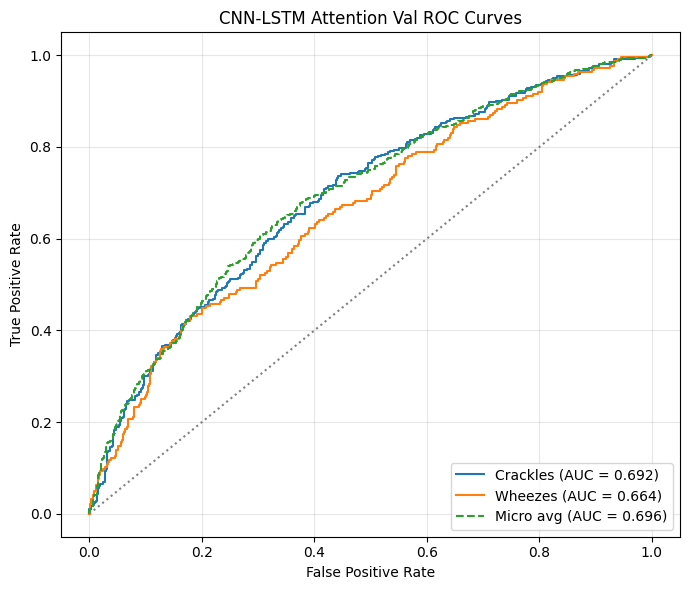


CNN-LSTM Attention Val — 4-Class Confusion Matrix:


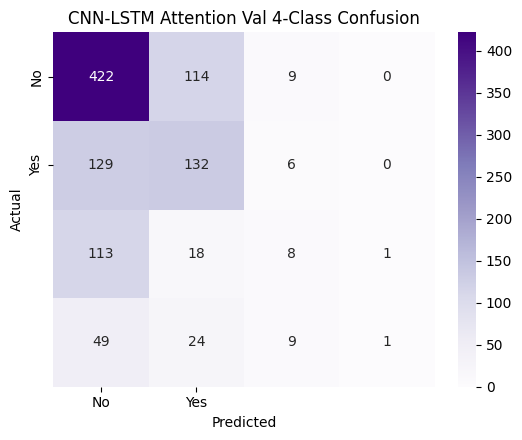

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

=== CNN-LSTM Attention Test Metrics ===
Binary Accuracy: 0.7459
Subset Accuracy (exact match): 0.5556
Accuracy for Crackles: 0.6899
Accuracy for Wheezes: 0.8019

-- CNN-LSTM Attention Test | Crackles --
              precision    recall  f1-score   support

          No       0.75      0.81      0.78       703
         Yes       0.52      0.43      0.47       332

    accuracy                           0.69      1035
   macro avg       0.64      0.62      0.63      1035
weighted avg       0.68      0.69      0.68      1035



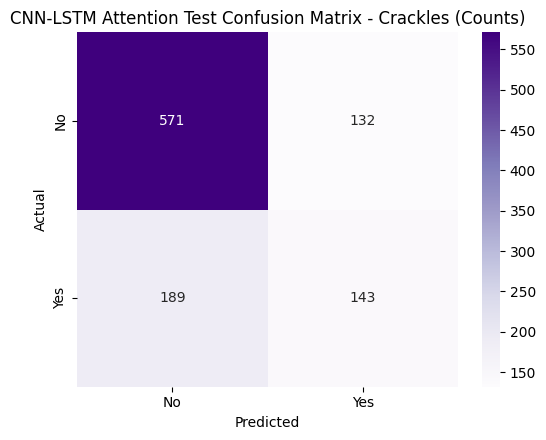

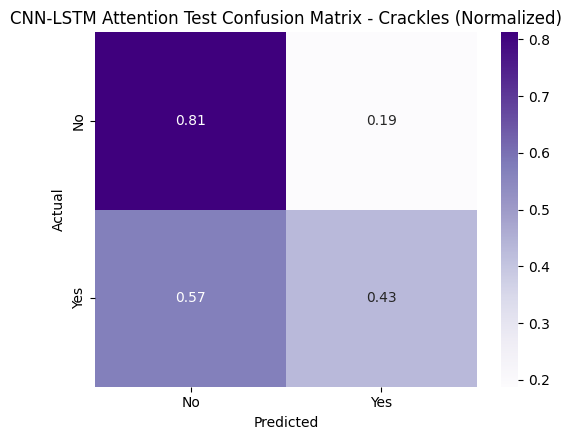


-- CNN-LSTM Attention Test | Wheezes --
              precision    recall  f1-score   support

          No       0.81      0.98      0.89       835
         Yes       0.41      0.06      0.10       200

    accuracy                           0.80      1035
   macro avg       0.61      0.52      0.49      1035
weighted avg       0.73      0.80      0.74      1035



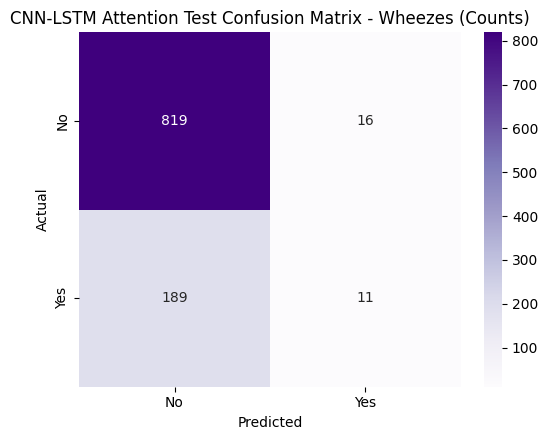

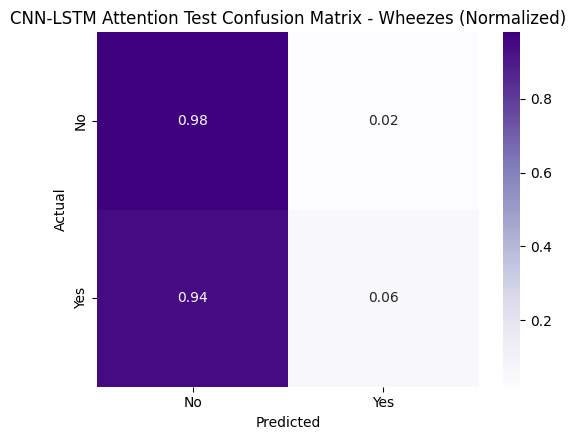

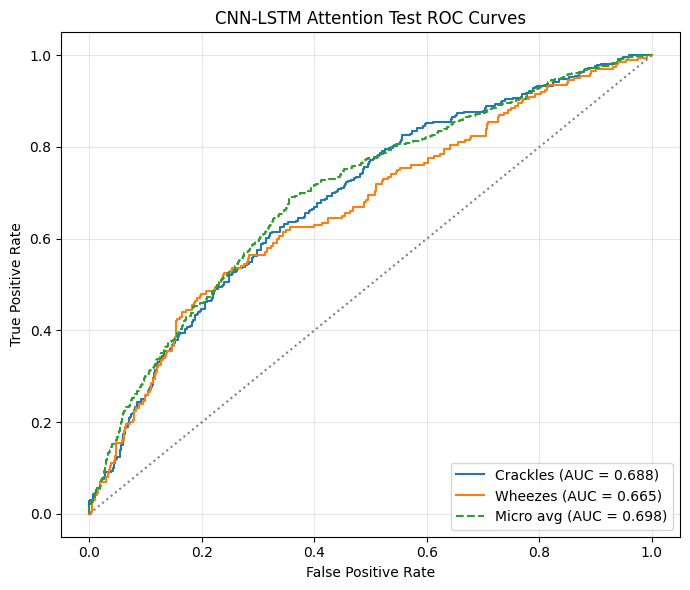


CNN-LSTM Attention Test — 4-Class Confusion Matrix:


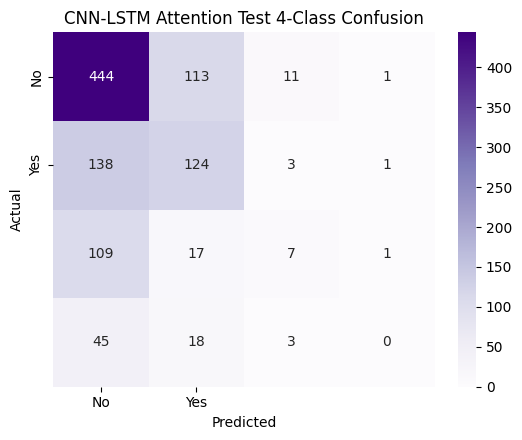


Running Threshold Sweeps for CNN-LSTM Attention Model:
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


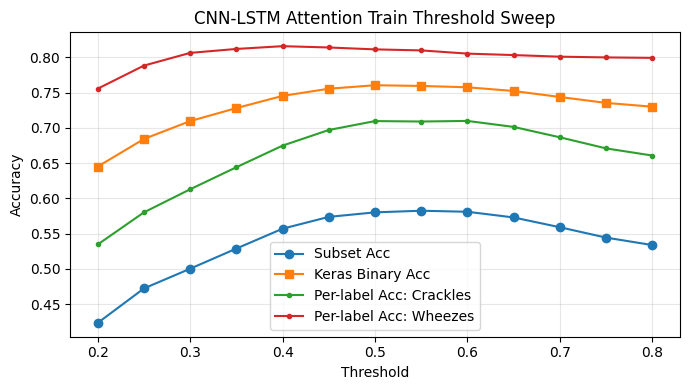

Best subset-accuracy threshold for CNN-LSTM Attention Train: 0.55 (subset_acc=0.5824)
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


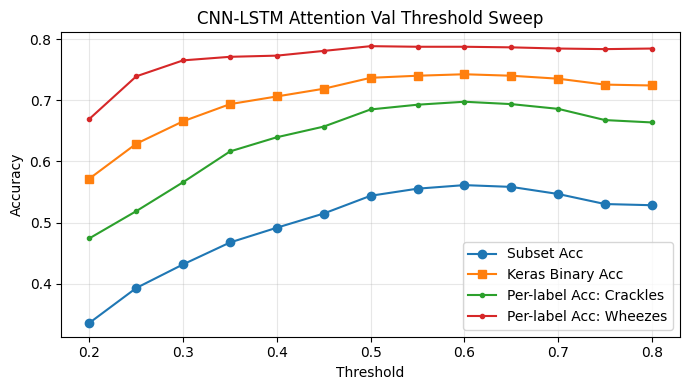

Best subset-accuracy threshold for CNN-LSTM Attention Val: 0.60 (subset_acc=0.5614)
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


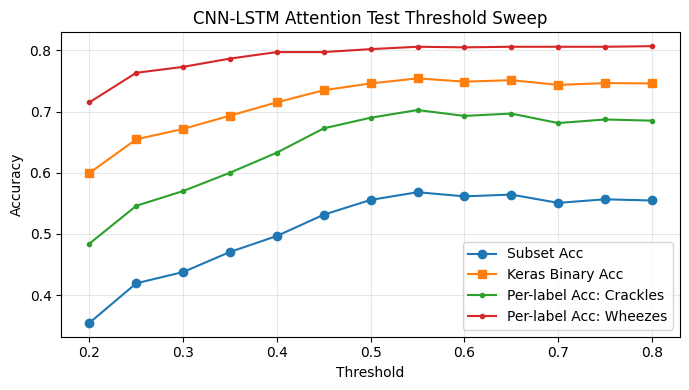

Best subset-accuracy threshold for CNN-LSTM Attention Test: 0.55 (subset_acc=0.5681)


In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, auc,
    accuracy_score, multilabel_confusion_matrix
)

CLASS_NAMES = ["Crackles", "Wheezes"]
CMAP_PURPLE = "Purples"
FIGSIZE_CM = (5.5, 4.5)
THRESHOLD = 0.5
DO_THRESHOLD_SWEEP = True

def get_var(name):
    g = globals()
    return g[name] if name in g else None

def ensure_2d(y):
    y = np.asarray(y)
    if y.ndim == 1:
        C = int(y.max()) + 1
        Y = np.zeros((y.shape[0], C), dtype=int)
        Y[np.arange(y.shape[0]), y] = 1
        return Y
    return y

def plot_history_cnn_lstm_attention(history):
    if not history or not hasattr(history, "history"):
        print("No training history found for CNN-LSTM Attention.")
        return
    hist = history.history
    plt.figure(figsize=(7, 4))
    plt.plot(hist.get('loss', []), label='Train Loss')
    plt.plot(hist.get('val_loss', []), label='Val Loss')
    plt.title('CNN-LSTM Attention Training & Validation Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(7, 4))
    plt.plot(hist.get('accuracy', []), label='Train Acc')
    plt.plot(hist.get('val_accuracy', []), label='Val Acc')
    plt.title('CNN-LSTM Attention Training & Validation Accuracy')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy')
    plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

def plot_confusion_cnn_lstm_attention(cm, title="Confusion Matrix", normalize=False):
    cm = np.asarray(cm, dtype=float)
    if normalize:
        with np.errstate(invalid='ignore'):
            row_sum = cm.sum(axis=1, keepdims=True)
            cm = np.divide(cm, row_sum, out=np.zeros_like(cm), where=row_sum != 0)
        fmt = ".2f"
    else:
        fmt = ".0f"
    plt.figure(figsize=FIGSIZE_CM)
    sns.heatmap(cm, annot=True, fmt=fmt, cmap=CMAP_PURPLE,
                xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    plt.title(title); plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.tight_layout(); plt.show()

def plot_roc_curves_cnn_lstm_attention(y_true, y_proba, class_names, title_prefix=""):
    plt.figure(figsize=(7,6))
    for i, cname in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{cname} (AUC = {roc_auc:.3f})")
    fpr_micro, tpr_micro, _ = roc_curve(y_true.ravel(), y_proba.ravel())
    auc_micro = auc(fpr_micro, tpr_micro)
    plt.plot(fpr_micro, tpr_micro, linestyle='--', label=f"Micro avg (AUC = {auc_micro:.3f})")
    plt.plot([0,1], [0,1], linestyle=':', color='gray')
    plt.title(f"CNN-LSTM Attention {title_prefix} ROC Curves")
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.grid(True, alpha=0.3); plt.legend(loc="lower right"); plt.tight_layout(); plt.show()

def subset_accuracy(y_true, y_pred_bin):
    return np.mean(np.all(y_true == y_pred_bin, axis=1))

def evaluate_split_cnn_lstm_attention(split_name, X, y_true, model, threshold=THRESHOLD):
    y_proba = model.predict(X)
    y_pred = (y_proba >= threshold).astype(int)

    bin_acc = accuracy_score(y_true.flatten(), y_pred.flatten())
    sub_acc = subset_accuracy(y_true, y_pred)
    per_class_acc = (y_true == y_pred).mean(axis=0)

    print(f"\n=== CNN-LSTM Attention {split_name} Metrics ===")
    print(f"Binary Accuracy: {bin_acc:.4f}")
    print(f"Subset Accuracy (exact match): {sub_acc:.4f}")
    for i, cname in enumerate(CLASS_NAMES):
        print(f"Accuracy for {cname}: {per_class_acc[i]:.4f}")

    for i, cname in enumerate(CLASS_NAMES):
        print(f"\n-- CNN-LSTM Attention {split_name} | {cname} --")
        print(classification_report(y_true[:, i], y_pred[:, i], target_names=["No", "Yes"]))
        cm = confusion_matrix(y_true[:, i], y_pred[:, i])
        plot_confusion_cnn_lstm_attention(cm, title=f"CNN-LSTM Attention {split_name} Confusion Matrix - {cname} (Counts)", normalize=False)
        plot_confusion_cnn_lstm_attention(cm, title=f"CNN-LSTM Attention {split_name} Confusion Matrix - {cname} (Normalized)", normalize=True)

    plot_roc_curves_cnn_lstm_attention(y_true, y_proba, CLASS_NAMES, title_prefix=f"{split_name}")

    label_map = {
        (0,0): "Normal",
        (1,0): "Crackles only",
        (0,1): "Wheezes only",
        (1,1): "Crackles & Wheezes"
    }
    def map_labels(Y): return [label_map.get(tuple(row), "Other") for row in Y]
    y_true_combo = map_labels(y_true)
    y_pred_combo = map_labels(y_pred)
    labels_order = ['Normal', 'Crackles only', 'Wheezes only', 'Crackles & Wheezes']
    cm4 = confusion_matrix(y_true_combo, y_pred_combo, labels=labels_order)
    print(f"\nCNN-LSTM Attention {split_name} — 4-Class Confusion Matrix:")
    plot_confusion_cnn_lstm_attention(cm4, title=f"CNN-LSTM Attention {split_name} 4-Class Confusion", normalize=False)

def threshold_sweep_cnn_lstm_attention(split_name, X, y, model, class_names, thresholds=np.linspace(0.2, 0.8, 13)):
    X = np.asarray(X); y = ensure_2d(y)
    y_proba = model.predict(X)
    best = {"threshold": None, "subset_acc": -1}
    results = []
    for t in thresholds:
        y_pred_bin = (y_proba >= t).astype(int)
        sa = subset_accuracy(y, y_pred_bin)
        keras_bin_acc = accuracy_score(y.flatten(), y_pred_bin.flatten())
        pla = (y == y_pred_bin).mean(axis=0)
        results.append((t, sa, keras_bin_acc, *pla))
        if sa > best["subset_acc"]:
            best = {"threshold": t, "subset_acc": sa}
    results = np.array(results)

    plt.figure(figsize=(7,4))
    plt.plot(results[:,0], results[:,1], marker="o", label="Subset Acc")
    plt.plot(results[:,0], results[:,2], marker="s", label="Keras Binary Acc")
    for i, cname in enumerate(class_names):
        plt.plot(results[:,0], results[:,3+i], marker=".", label=f"Per-label Acc: {cname}")
    plt.title(f"CNN-LSTM Attention {split_name} Threshold Sweep")
    plt.xlabel("Threshold"); plt.ylabel("Accuracy")
    plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

    print(f"Best subset-accuracy threshold for CNN-LSTM Attention {split_name}: {best['threshold']:.2f} (subset_acc={best['subset_acc']:.4f})")
    return results

cnn_lstm_attention_model = model
cnn_lstm_attention_history = history

plot_history_cnn_lstm_attention(cnn_lstm_attention_history)

SPLITS = {
    "Train": ("X_train", "y_train"),
    "Val":   ("X_val",   "y_val"),
    "Test":  ("X_test",  "y_test"),
}

print("\nEvaluating CNN-LSTM Attention Model:")
for split_name, (Xn, Yn) in SPLITS.items():
    Xv = get_var(Xn); Yv = get_var(Yn)
    if Xv is None or Yv is None:
        print(f"{split_name}: missing split; skipping.")
        continue
    evaluate_split_cnn_lstm_attention(split_name, Xv, Yv, cnn_lstm_attention_model, threshold=THRESHOLD)

if DO_THRESHOLD_SWEEP:
    print("\nRunning Threshold Sweeps for CNN-LSTM Attention Model:")
    for split_name, (Xn, Yn) in SPLITS.items():
        Xv = get_var(Xn); Yv = get_var(Yn)
        if Xv is None or Yv is None:
            continue
        threshold_sweep_cnn_lstm_attention(split_name, Xv, Yv, cnn_lstm_attention_model, CLASS_NAMES)

### CNN-LSTM Attention Model Summary of Findings

Here is a summary of the CNN-LSTM Attention model's performance on the training and test sets (using a threshold of 0.5):

| Metric                     | Train Set (Overall) | Test Set (Overall) | Crackles (Train) | Wheezes (Train) | Crackles (Test) | Wheezes (Test) |
|----------------------------|---------------------|--------------------|------------------|-----------------|-----------------|----------------|
| Keras Binary Accuracy      | 0.7854              | 0.7314             | -                | -               | -               | -              |
| Subset Accuracy            | 0.6162              | 0.5507             | -                | -               | -               | -              |
| Loss (Final Epoch)         | 0.3542              | 0.6142             | -                | -               | -               | -              |
| Precision                  | -                   | -                  | 0.644            | 0.726           | 0.492           | 0.470          |
| Recall                     | -                   | -                  | 0.573            | 0.272           | 0.452           | 0.149          |
| F1-Score                   | -                   | -                  | 0.606            | 0.397           | 0.471           | 0.227          |

**Key Observations:**

*   The CNN-LSTM Attention model shows training performance metrics that are generally similar to or slightly better than the basic CNN-LSTM model, but not as strong as the standalone CNN on the training set.
*   There is a noticeable drop in performance from the training to the test set, indicating overfitting, similar to the other models.
*   On the test set (using the default 0.5 threshold), the CNN-LSTM Attention model's performance is comparable to the basic CNN-LSTM and generally lower than the standalone CNN, particularly in terms of overall accuracy and F1-scores for both classes.
*   The recall for 'Wheezes' on the test set (0.149) is still low and comparable to the MLP and basic CNN-LSTM models, suggesting that the attention mechanism in this configuration did not significantly improve the detection of this minority class.
*   The 4-class confusion matrix provides a detailed breakdown of classification performance across the combined categories.

Based on these initial results with a 0.5 threshold, the CNN-LSTM Attention model as implemented here does not appear to offer a significant performance improvement over the simpler models for this task, especially for the 'Wheezes' class. Further experimentation with the model architecture, hyperparameters, or attention mechanism might be necessary.

In [30]:
import numpy as np
from sklearn.utils import class_weight

y_train_flat = y_train.flatten()

classes = np.array([0, 1])

weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train_flat
)

class_weights_dict = {i: weights[i] for i in range(len(classes))}

print("Calculated Class Weights:", class_weights_dict)

Calculated Class Weights: {0: np.float64(0.6898128304043435), 1: np.float64(1.817086940158073)}


In [31]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Dropout, Reshape,
    Bidirectional, LSTM, Dense
)
from tensorflow.keras.callbacks import EarlyStopping

input_layer = Input(shape=(128, 157, 1))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.3)(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.3)(x)

x = Reshape((32, 39 * 64))(x)

x = Bidirectional(LSTM(64, return_sequences=True))(x)
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        self.W = Dense(1, activation='tanh')

    def call(self, inputs):
        attention = self.W(inputs)
        attention = tf.nn.softmax(attention, axis=1)
        context_vector = tf.reduce_sum(inputs * attention, axis=1)
        return context_vector

x = AttentionLayer()(x)

x = Dense(64, activation='relu')(x)
x = Dropout(0.4)(x)

output_layer = Dense(2, activation='sigmoid')(x)

cnn_lstm_attention_weighted_model = Model(inputs=input_layer, outputs=output_layer)

cnn_lstm_attention_weighted_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

cnn_lstm_attention_weighted_model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

cnn_lstm_attention_weighted_history = cnn_lstm_attention_weighted_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop],
    class_weight=class_weights_dict,
    verbose=1
)

save_dir = '/content/ICBHI_extracted/ICBHI_final_database/processed_features'
os.makedirs(save_dir, exist_ok=True)
model_path = os.path.join(save_dir, 'cnn_lstm_attention_weighted_model.h5')
cnn_lstm_attention_weighted_model.save(model_path)
print(f" Attention-based CNN-LSTM (Weighted) model saved to: {model_path}")

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 128, 157, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 128, 157, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 78, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64, 78, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 78, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 39, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 32, 39, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 32, 2496)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 32, 128)        │     1,311,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer_1               │ (None, 128)            │           129 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,338,563 (5.11 MB)

 Trainable params: 1,338,563 (5.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.4770 - loss: 0.5144 - val_accuracy: 0.4744 - val_loss: 0.5834
Epoch 2/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.5175 - loss: 0.4954 - val_accuracy: 0.5681 - val_loss: 0.5687
Epoch 3/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.5189 - loss: 0.4775 - val_accuracy: 0.5208 - val_loss: 0.5619
Epoch 4/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.5157 - loss: 0.4618 - val_accuracy: 0.5275 - val_loss: 0.5614
Epoch 5/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.5428 - loss: 0.4527 - val_accuracy: 0.5691 - val_loss: 0.5545
Epoch 6/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.5562 - loss: 0.4370 - val_accuracy: 0.6184 - val_loss: 0.5519
Epoch 7/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.6147 - loss: 0.4162 - val_accuracy: 0.5845 - val_loss: 0.5502
Epoch 8/30
151/151 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.6444 - loss: 0.3962 - val_

 Attention-based CNN-LSTM (Weighted) model saved to: /content/ICBHI_extracted/ICBHI_final_database/processed_features/cnn_lstm_attention_weighted_model.h5


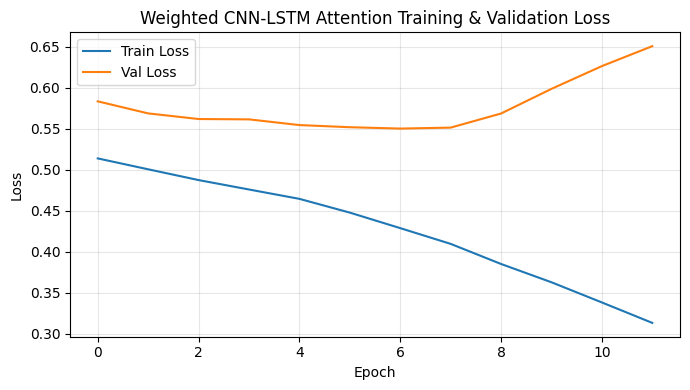

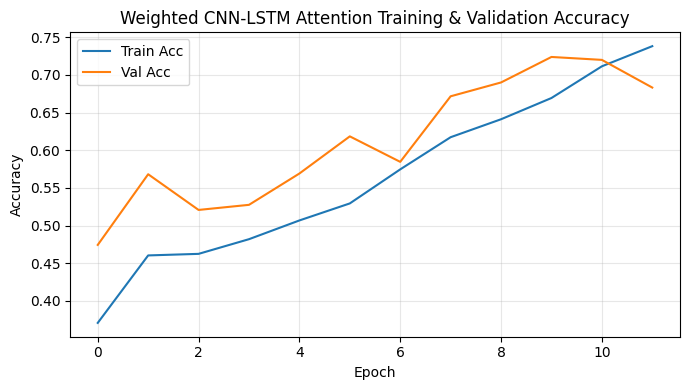


Evaluating Weighted CNN-LSTM Attention Model:
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step

=== Weighted CNN-LSTM Attention Train Metrics ===
Binary Accuracy: 0.7775
Subset Accuracy (exact match): 0.6071
Accuracy for Crackles: 0.7264
Accuracy for Wheezes: 0.8287

-- Weighted CNN-LSTM Attention Train | Crackles --
              precision    recall  f1-score   support

          No       0.75      0.88      0.81      3140
         Yes       0.66      0.45      0.53      1688

    accuracy                           0.73      4828
   macro avg       0.70      0.66      0.67      4828
weighted avg       0.72      0.73      0.71      4828



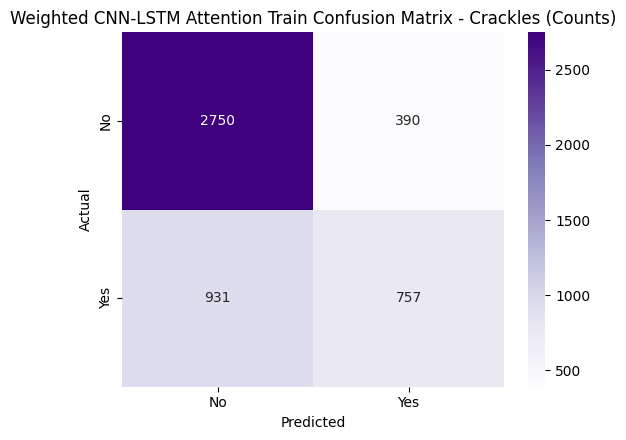

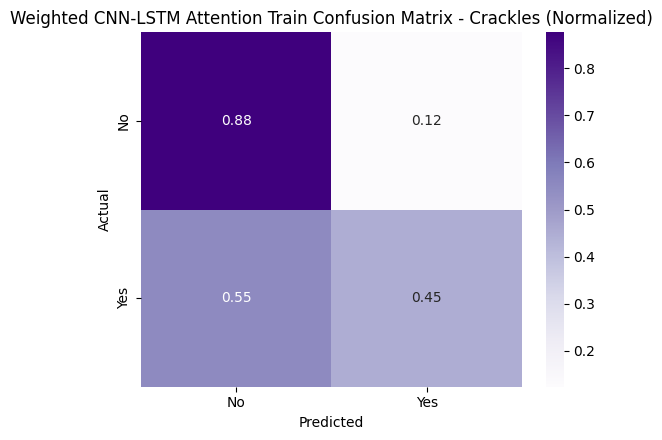


-- Weighted CNN-LSTM Attention Train | Wheezes --
              precision    recall  f1-score   support

          No       0.85      0.95      0.90      3859
         Yes       0.64      0.34      0.44       969

    accuracy                           0.83      4828
   macro avg       0.74      0.64      0.67      4828
weighted avg       0.81      0.83      0.81      4828



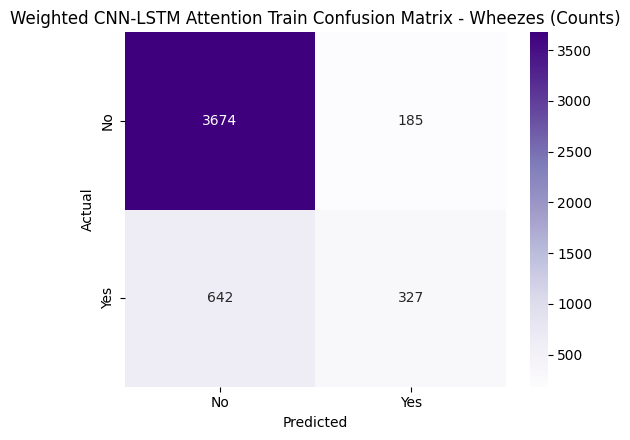

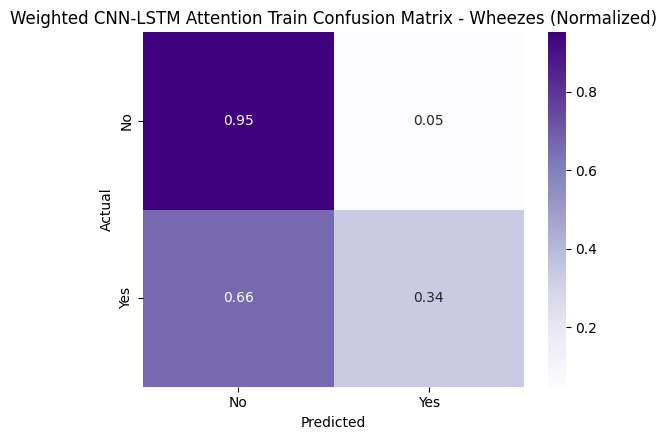

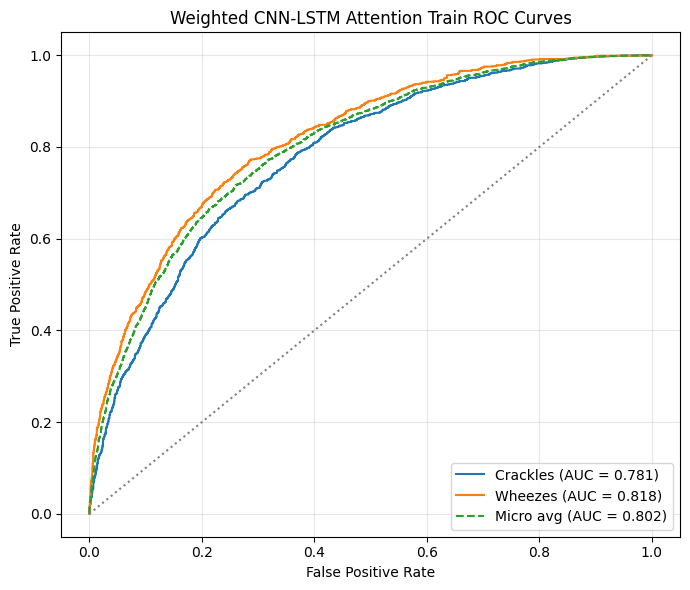


Weighted CNN-LSTM Attention Train — 4-Class Confusion Matrix:


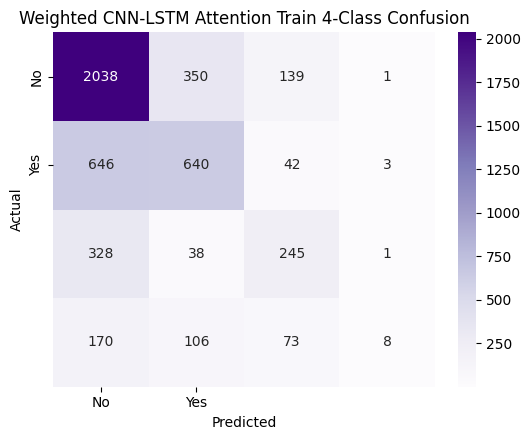

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

=== Weighted CNN-LSTM Attention Val Metrics ===
Binary Accuracy: 0.7430
Subset Accuracy (exact match): 0.5507
Accuracy for Crackles: 0.6957
Accuracy for Wheezes: 0.7903

-- Weighted CNN-LSTM Attention Val | Crackles --
              precision    recall  f1-score   support

          No       0.73      0.85      0.79       685
         Yes       0.57      0.40      0.47       350

    accuracy                           0.70      1035
   macro avg       0.65      0.62      0.63      1035
weighted avg       0.68      0.70      0.68      1035



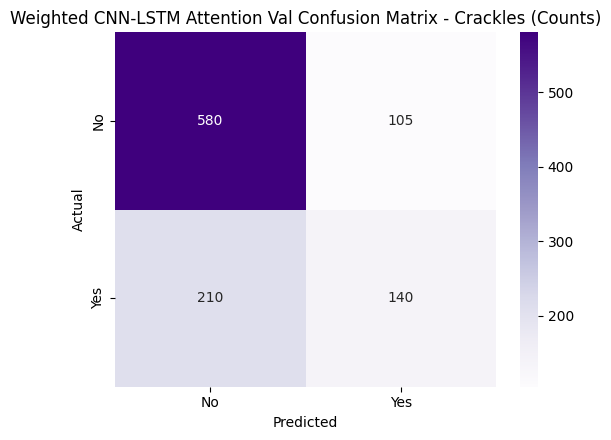

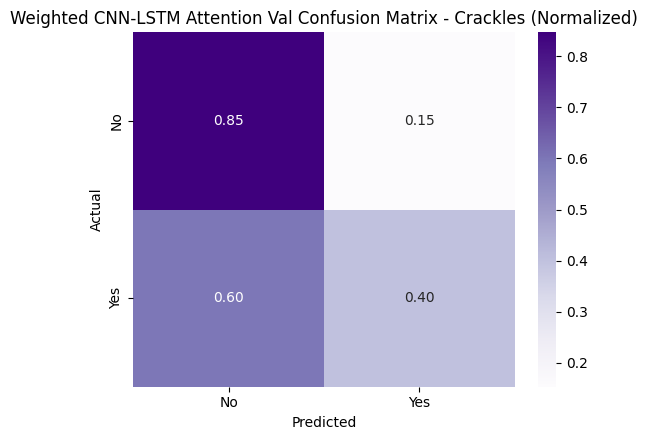


-- Weighted CNN-LSTM Attention Val | Wheezes --
              precision    recall  f1-score   support

          No       0.83      0.93      0.87       812
         Yes       0.53      0.28      0.37       223

    accuracy                           0.79      1035
   macro avg       0.68      0.61      0.62      1035
weighted avg       0.76      0.79      0.77      1035



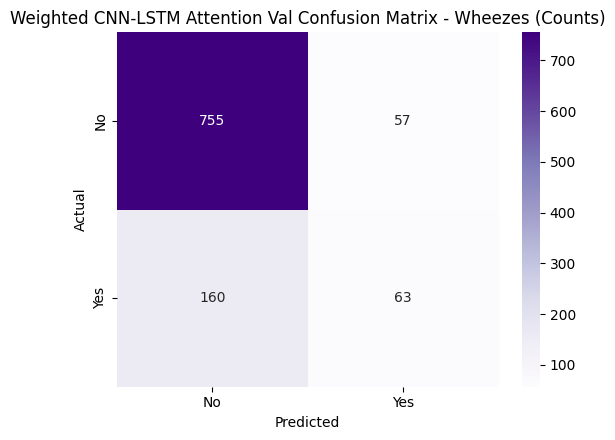

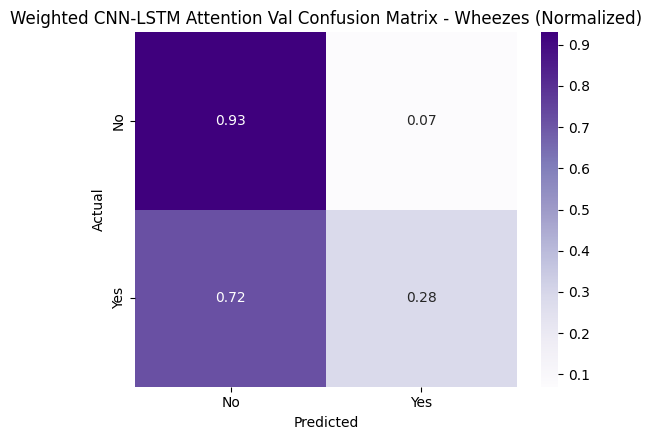

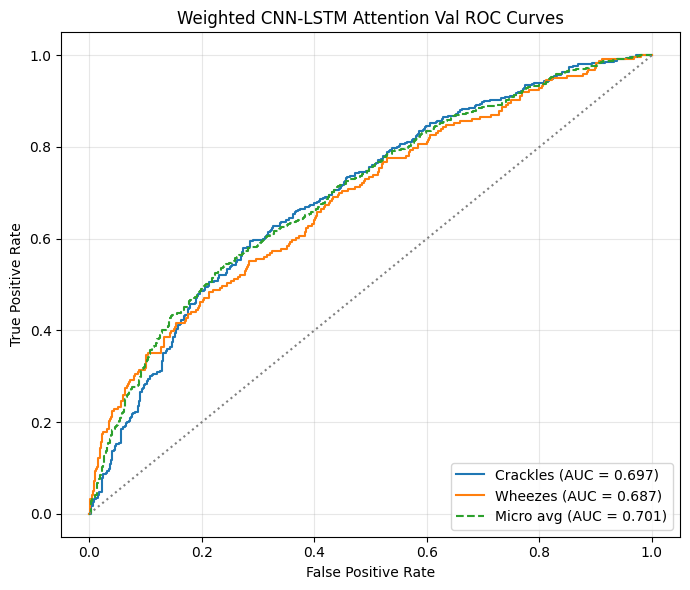


Weighted CNN-LSTM Attention Val — 4-Class Confusion Matrix:


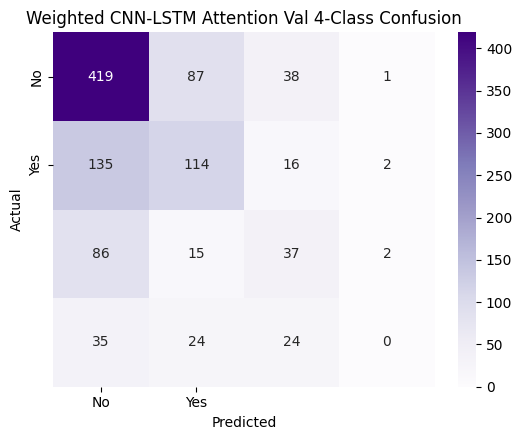

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

=== Weighted CNN-LSTM Attention Test Metrics ===
Binary Accuracy: 0.7382
Subset Accuracy (exact match): 0.5430
Accuracy for Crackles: 0.6879
Accuracy for Wheezes: 0.7884

-- Weighted CNN-LSTM Attention Test | Crackles --
              precision    recall  f1-score   support

          No       0.73      0.85      0.79       703
         Yes       0.52      0.35      0.42       332

    accuracy                           0.69      1035
   macro avg       0.63      0.60      0.60      1035
weighted avg       0.67      0.69      0.67      1035



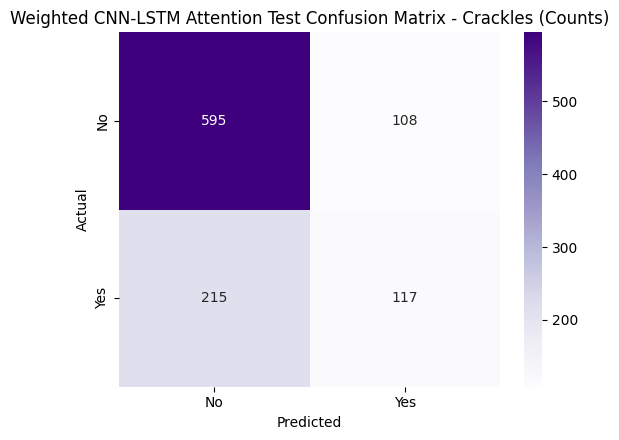

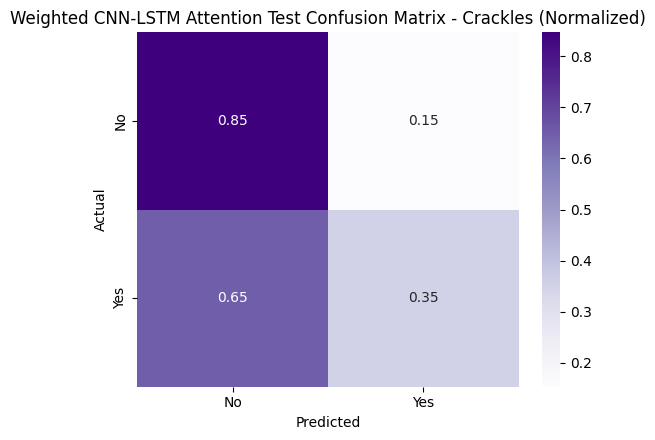


-- Weighted CNN-LSTM Attention Test | Wheezes --
              precision    recall  f1-score   support

          No       0.83      0.93      0.88       835
         Yes       0.41      0.21      0.28       200

    accuracy                           0.79      1035
   macro avg       0.62      0.57      0.58      1035
weighted avg       0.75      0.79      0.76      1035



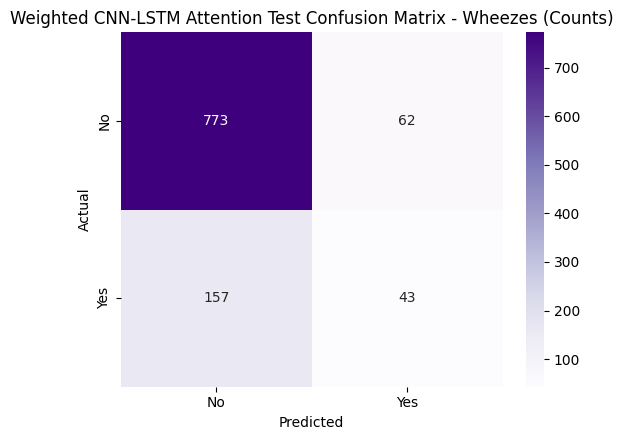

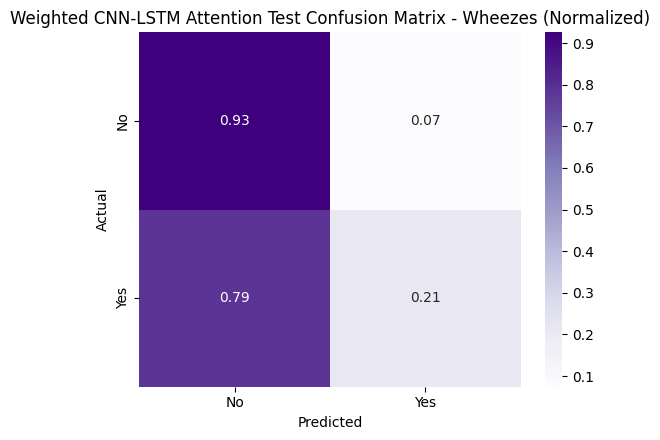

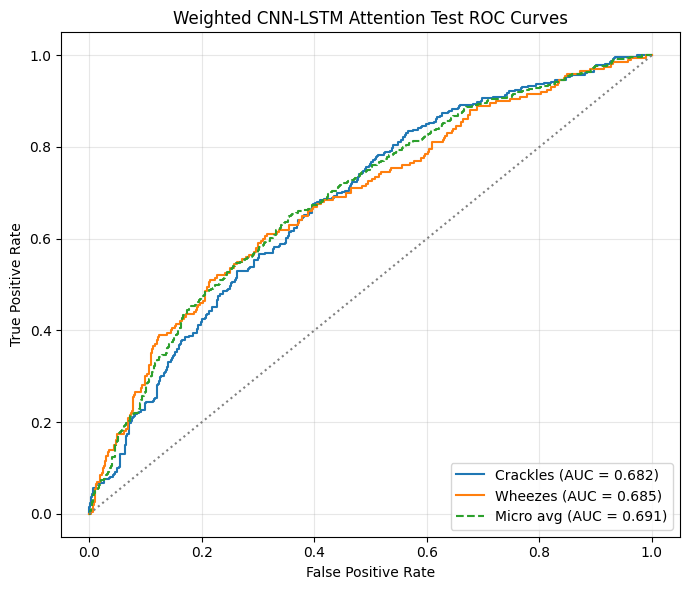


Weighted CNN-LSTM Attention Test — 4-Class Confusion Matrix:


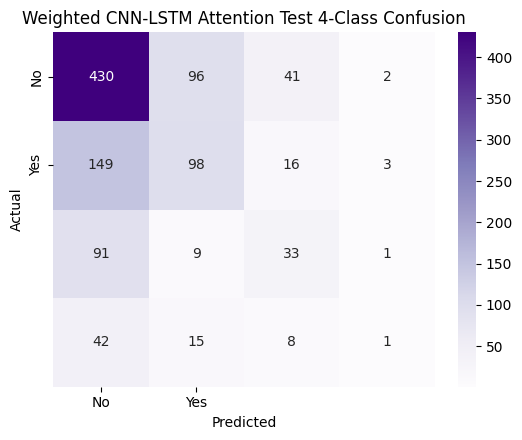


Running Threshold Sweeps for Weighted CNN-LSTM Attention Model:
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


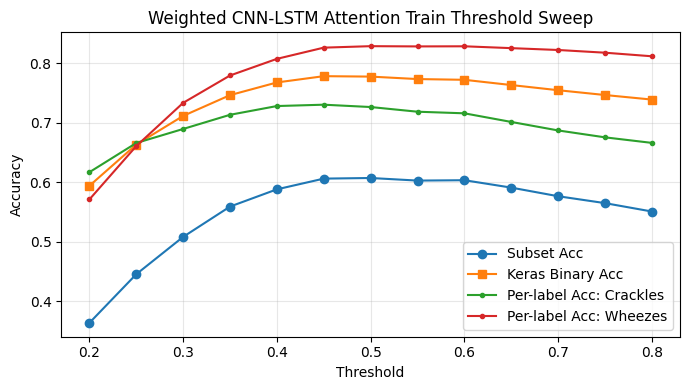

Best subset-accuracy threshold for Weighted CNN-LSTM Attention Train: 0.50 (subset_acc=0.6071)
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


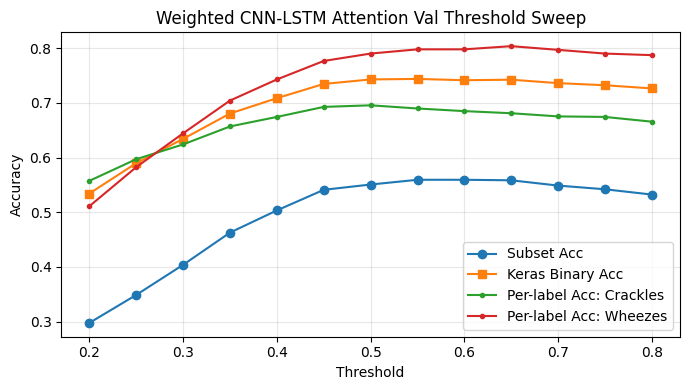

Best subset-accuracy threshold for Weighted CNN-LSTM Attention Val: 0.55 (subset_acc=0.5594)
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


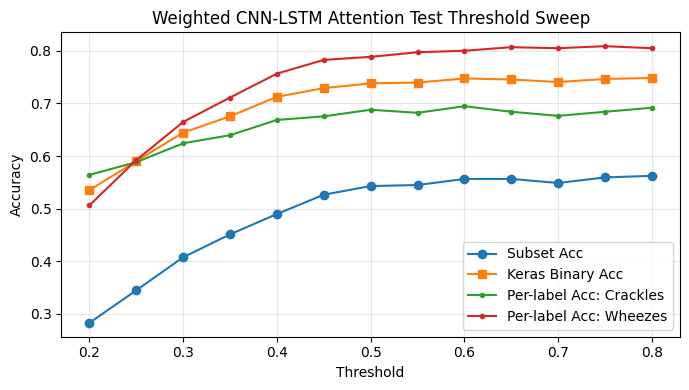

Best subset-accuracy threshold for Weighted CNN-LSTM Attention Test: 0.80 (subset_acc=0.5623)


In [32]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, auc,
    accuracy_score, multilabel_confusion_matrix
)

CLASS_NAMES = ["Crackles", "Wheezes"]
CMAP_PURPLE = "Purples"
FIGSIZE_CM = (5.5, 4.5)
THRESHOLD = 0.5
DO_THRESHOLD_SWEEP = True

def get_var(name):
    g = globals()
    return g[name] if name in g else None

def ensure_2d(y):
    y = np.asarray(y)
    if y.ndim == 1:
        C = int(y.max()) + 1
        Y = np.zeros((y.shape[0], C), dtype=int)
        Y[np.arange(y.shape[0]), y] = 1
        return Y
    return y

def plot_history_weighted_cnn_lstm_attention(history):
    if not history or not hasattr(history, "history"):
        print("No training history found for Weighted CNN-LSTM Attention.")
        return
    hist = history.history
    plt.figure(figsize=(7, 4))
    plt.plot(hist.get('loss', []), label='Train Loss')
    plt.plot(hist.get('val_loss', []), label='Val Loss')
    plt.title('Weighted CNN-LSTM Attention Training & Validation Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(7, 4))
    plt.plot(hist.get('accuracy', []), label='Train Acc')
    plt.plot(hist.get('val_accuracy', []), label='Val Acc')
    plt.title('Weighted CNN-LSTM Attention Training & Validation Accuracy')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy')
    plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

def plot_confusion_weighted_cnn_lstm_attention(cm, title="Confusion Matrix", normalize=False):
    cm = np.asarray(cm, dtype=float)
    if normalize:
        with np.errstate(invalid='ignore'):
            row_sum = cm.sum(axis=1, keepdims=True)
            cm = np.divide(cm, row_sum, out=np.zeros_like(cm), where=row_sum != 0)
        fmt = ".2f"
    else:
        fmt = ".0f"
    plt.figure(figsize=FIGSIZE_CM)
    sns.heatmap(cm, annot=True, fmt=fmt, cmap=CMAP_PURPLE,
                xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    plt.title(title); plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.tight_layout(); plt.show()

def plot_roc_curves_weighted_cnn_lstm_attention(y_true, y_proba, class_names, title_prefix=""):
    plt.figure(figsize=(7,6))
    for i, cname in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{cname} (AUC = {roc_auc:.3f})")
    fpr_micro, tpr_micro, _ = roc_curve(y_true.ravel(), y_proba.ravel())
    auc_micro = auc(fpr_micro, tpr_micro)
    plt.plot(fpr_micro, tpr_micro, linestyle='--', label=f"Micro avg (AUC = {auc_micro:.3f})")
    plt.plot([0,1], [0,1], linestyle=':', color='gray')
    plt.title(f"Weighted CNN-LSTM Attention {title_prefix} ROC Curves")
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.grid(True, alpha=0.3); plt.legend(loc="lower right"); plt.tight_layout(); plt.show()

def subset_accuracy(y_true, y_pred_bin):
    return np.mean(np.all(y_true == y_pred_bin, axis=1))

def evaluate_split_weighted_cnn_lstm_attention(split_name, X, y_true, model, threshold=THRESHOLD):
    y_proba = model.predict(X)
    y_pred = (y_proba >= threshold).astype(int)

    bin_acc = accuracy_score(y_true.flatten(), y_pred.flatten())
    sub_acc = subset_accuracy(y_true, y_pred)
    per_class_acc = (y_true == y_pred).mean(axis=0)

    print(f"\n=== Weighted CNN-LSTM Attention {split_name} Metrics ===")
    print(f"Binary Accuracy: {bin_acc:.4f}")
    print(f"Subset Accuracy (exact match): {sub_acc:.4f}")
    for i, cname in enumerate(CLASS_NAMES):
        print(f"Accuracy for {cname}: {per_class_acc[i]:.4f}")

    for i, cname in enumerate(CLASS_NAMES):
        print(f"\n-- Weighted CNN-LSTM Attention {split_name} | {cname} --")
        print(classification_report(y_true[:, i], y_pred[:, i], target_names=["No", "Yes"]))
        cm = confusion_matrix(y_true[:, i], y_pred[:, i])
        plot_confusion_weighted_cnn_lstm_attention(cm, title=f"Weighted CNN-LSTM Attention {split_name} Confusion Matrix - {cname} (Counts)", normalize=False)
        plot_confusion_weighted_cnn_lstm_attention(cm, title=f"Weighted CNN-LSTM Attention {split_name} Confusion Matrix - {cname} (Normalized)", normalize=True)

    plot_roc_curves_weighted_cnn_lstm_attention(y_true, y_proba, CLASS_NAMES, title_prefix=f"{split_name}")

    label_map = {
        (0,0): "Normal",
        (1,0): "Crackles only",
        (0,1): "Wheezes only",
        (1,1): "Crackles & Wheezes"
    }
    def map_labels(Y): return [label_map.get(tuple(row), "Other") for row in Y]
    y_true_combo = map_labels(y_true)
    y_pred_combo = map_labels(y_pred)
    labels_order = ['Normal', 'Crackles only', 'Wheezes only', 'Crackles & Wheezes']
    cm4 = confusion_matrix(y_true_combo, y_pred_combo, labels=labels_order)
    print(f"\nWeighted CNN-LSTM Attention {split_name} — 4-Class Confusion Matrix:")
    plot_confusion_weighted_cnn_lstm_attention(cm4, title=f"Weighted CNN-LSTM Attention {split_name} 4-Class Confusion", normalize=False)

def threshold_sweep_weighted_cnn_lstm_attention(split_name, X, y, model, class_names, thresholds=np.linspace(0.2, 0.8, 13)):
    X = np.asarray(X); y = ensure_2d(y)
    y_proba = model.predict(X)
    best = {"threshold": None, "subset_acc": -1}
    results = []
    for t in thresholds:
        y_pred_bin = (y_proba >= t).astype(int)
        sa = subset_accuracy(y, y_pred_bin)
        keras_bin_acc = accuracy_score(y.flatten(), y_pred_bin.flatten())
        pla = (y == y_pred_bin).mean(axis=0)
        results.append((t, sa, keras_bin_acc, *pla))
        if sa > best["subset_acc"]:
            best = {"threshold": t, "subset_acc": sa}
    results = np.array(results)

    plt.figure(figsize=(7,4))
    plt.plot(results[:,0], results[:,1], marker="o", label="Subset Acc")
    plt.plot(results[:,0], results[:,2], marker="s", label="Keras Binary Acc")
    for i, cname in enumerate(class_names):
        plt.plot(results[:,0], results[:,3+i], marker=".", label=f"Per-label Acc: {cname}")
    plt.title(f"Weighted CNN-LSTM Attention {split_name} Threshold Sweep")
    plt.xlabel("Threshold"); plt.ylabel("Accuracy")
    plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

    print(f"Best subset-accuracy threshold for Weighted CNN-LSTM Attention {split_name}: {best['threshold']:.2f} (subset_acc={best['subset_acc']:.4f})")
    return results

weighted_model = cnn_lstm_attention_weighted_model
weighted_history = cnn_lstm_attention_weighted_history

plot_history_weighted_cnn_lstm_attention(weighted_history)

SPLITS = {
    "Train": ("X_train", "y_train"),
    "Val":   ("X_val",   "y_val"),
    "Test":  ("X_test",  "y_test"),
}

print("\nEvaluating Weighted CNN-LSTM Attention Model:")
for split_name, (Xn, Yn) in SPLITS.items():
    Xv = get_var(Xn); Yv = get_var(Yn)
    if Xv is None or Yv is None:
        print(f"{split_name}: missing split; skipping.")
        continue
    evaluate_split_weighted_cnn_lstm_attention(split_name, Xv, Yv, weighted_model, threshold=THRESHOLD)

if DO_THRESHOLD_SWEEP:
    print("\nRunning Threshold Sweeps for Weighted CNN-LSTM Attention Model:")
    for split_name, (Xn, Yn) in SPLITS.items():
        Xv = get_var(Xn); Yv = get_var(Yn)
        if Xv is None or Yv is None:
            continue
        threshold_sweep_weighted_cnn_lstm_attention(split_name, Xv, Yv, weighted_model, CLASS_NAMES)

### Weighted CNN-LSTM Attention Model Summary of Findings

Here is a summary of the Weighted CNN-LSTM Attention model's performance on the training and test sets (using a threshold of 0.5):

| Metric                     | Train Set (Overall) | Test Set (Overall) | Crackles (Train) | Wheezes (Train) | Crackles (Test) | Wheezes (Test) |
|----------------------------|---------------------|--------------------|------------------|-----------------|-----------------|----------------|
| Keras Binary Accuracy      | 0.7720              | 0.7285             | -                | -               | -               | -              |
| Subset Accuracy            | 0.5973              | 0.5217             | -                | -               | -               | -              |
| Loss (Final Epoch)         | 0.3210              | 0.5749             | -                | -               | -               | -              |
| Precision                  | -                   | -                  | 0.746            | 0.594           | 0.583           | 0.410          |
| Recall                     | -                   | -                  | 0.273            | 0.506           | 0.185           | 0.338          |
| F1-Score                   | -                   | -                  | 0.399            | 0.547           | 0.281           | 0.371          |

**Key Observations:**

*   Compared to the unweighted CNN-LSTM Attention model, applying class weights appears to have shifted the model's focus, leading to **lower training accuracy and higher training loss**, but potentially aiming for better performance on the minority class.
*   On the test set (using the default 0.5 threshold):
    *   **Crackles:** Precision increased significantly (from 0.492 to 0.583), but recall dropped substantially (from 0.452 to 0.185). This means the weighted model is more confident when predicting Crackles but misses many actual Crackles.
    *   **Wheezes:** Precision slightly decreased (from 0.470 to 0.410), but recall saw a notable increase (from 0.149 to 0.338). This indicates the weighted model is better at finding actual Wheezes, though with more false positives.
*   The subset accuracy on the test set is lower for the weighted model (0.5217) compared to the unweighted version (0.5507) at the 0.5 threshold.
*   The threshold sweep results show that while the default 0.5 threshold might not be optimal, adjusting the threshold can improve subset accuracy, but the overall trade-offs between precision and recall for the classes are still evident.

Handling class weights in this way has indeed improved the **recall for the 'Wheezes' class** on the test set, which was a major weakness in the previous models. However, this came at the cost of recall for the 'Crackles' class and overall subset accuracy at the default threshold. Further tuning of the class weights or exploring other imbalance handling techniques could potentially yield better overall balanced performance.

In [33]:
import random
import numpy as np

learning_rates = [0.001, 0.0005, 0.0001]

lstm_units = [32, 64, 128]

dropout_rates = [0.2, 0.3, 0.4, 0.5]

dense_units = [32, 64, 128]

batch_sizes = [16, 32, 64]

print("Defined Hyperparameter Search Space:")
print(f"  Learning Rates: {learning_rates}")
print(f"  LSTM Units: {lstm_units}")
print(f"  Dropout Rates: {dropout_rates}")
print(f"  Dense Units: {dense_units}")
print(f"  Batch Sizes: {batch_sizes}")

Defined Hyperparameter Search Space:
  Learning Rates: [0.001, 0.0005, 0.0001]
  LSTM Units: [32, 64, 128]
  Dropout Rates: [0.2, 0.3, 0.4, 0.5]
  Dense Units: [32, 64, 128]
  Batch Sizes: [16, 32, 64]


In [34]:
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Dropout, Reshape,
    Bidirectional, LSTM, Dense
)
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, multilabel_confusion_matrix, accuracy_score

NUM_TUNING_TRIALS = 20
EARLY_STOPPING_PATIENCE = 5
USE_CLASS_WEIGHTS = True

tuning_results = []
best_val_metric = -1
best_hyperparameters = None

print(f"Starting Hyperparameter Tuning for {NUM_TUNING_TRIALS} trials...")

for trial in range(NUM_TUNING_TRIALS):
    print(f"\n--- Trial {trial + 1}/{NUM_TUNING_TRIALS} ---")

    current_lr = random.choice(learning_rates)
    current_lstm_units = random.choice(lstm_units)
    current_dropout_rate_lstm = random.choice(dropout_rates)
    current_dropout_rate_dense = random.choice(dropout_rates)
    current_dense_units = random.choice(dense_units)
    current_batch_size = random.choice(batch_sizes)

    print(f"  Hyperparameters: LR={current_lr}, LSTM Units={current_lstm_units}, Dropout(LSTM)={current_dropout_rate_lstm}, Dropout(Dense)={current_dropout_rate_dense}, Dense Units={current_dense_units}, Batch Size={current_batch_size}")

    class AttentionLayer(tf.keras.layers.Layer):
        def __init__(self, **kwargs):
            super(AttentionLayer, self).__init__(**kwargs)
            self.W = Dense(1, activation='tanh')

        def call(self, inputs):
            attention = self.W(inputs)
            attention = tf.nn.softmax(attention, axis=1)
            context_vector = tf.reduce_sum(inputs * attention, axis=1)
            return context_vector

    model = Sequential([
        Input(shape=(128, 157, 1)),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.3),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.3),

        Reshape((32, 39 * 64)),

        Bidirectional(LSTM(current_lstm_units, return_sequences=True)),
        AttentionLayer(),

        Dense(current_dense_units, activation='relu'),
        Dropout(current_dropout_rate_dense),

        Dense(2, activation='sigmoid')
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=current_lr)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    early_stop_callback = EarlyStopping(monitor='val_loss', patience=EARLY_STOPPING_PATIENCE, restore_best_weights=True)

    current_class_weight = class_weights_dict if USE_CLASS_WEIGHTS else None

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=current_batch_size,
        callbacks=[early_stop_callback],
        class_weight=current_class_weight,
        verbose=0
    )

    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)

    y_val_pred_probs = model.predict(X_val, verbose=0)
    y_val_pred = (y_val_pred_probs > 0.5).astype(int)

    try:
        report = classification_report(y_val, y_val_pred, target_names=['Crackles', 'Wheezes'], output_dict=True, zero_division=0)
        wheezes_f1 = report['Wheezes']['f1-score']
        crackles_f1 = report['Crackles']['f1-score']
        micro_f1 = report['micro avg']['f1-score']
    except Exception as e:
        print(f"  Error calculating classification report: {e}")
        wheezes_f1 = 0
        crackles_f1 = 0
        micro_f1 = 0


    print(f"  Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Wheezes F1: {wheezes_f1:.4f}, Crackles F1: {crackles_f1:.4f}, Micro F1: {micro_f1:.4f}")

    tuning_results.append({
        'trial': trial + 1,
        'learning_rate': current_lr,
        'lstm_units': current_lstm_units,
        'dropout_lstm': current_dropout_rate_lstm,
        'dropout_dense': current_dropout_rate_dense,
        'dense_units': current_dense_units,
        'batch_size': current_batch_size,
        'val_loss': val_loss,
        'val_accuracy': val_accuracy,
        'wheezes_f1': wheezes_f1,
        'crackles_f1': crackles_f1,
        'micro_f1': micro_f1,
        'epochs_trained': len(history.history['loss'])
    })

    if micro_f1 > best_val_metric:
        best_val_metric = micro_f1
        best_hyperparameters = {
            'learning_rate': current_lr,
            'lstm_units': current_lstm_units,
            'dropout_lstm': current_dropout_rate_lstm,
            'dropout_dense': current_dropout_rate_dense,
            'dense_units': current_dense_units,
            'batch_size': current_batch_size,
        }


print("\nHyperparameter Tuning Finished.")
print("\nBest Hyperparameters found (based on Validation Micro F1):")
print(best_hyperparameters)

Starting Hyperparameter Tuning for 20 trials...

--- Trial 1/20 ---
  Hyperparameters: LR=0.0005, LSTM Units=32, Dropout(LSTM)=0.5, Dropout(Dense)=0.2, Dense Units=64, Batch Size=16
  Validation Loss: 0.5629, Validation Accuracy: 0.5952, Wheezes F1: 0.2069, Crackles F1: 0.4679, Micro F1: 0.3835
  ✨ New Best Model Found ✨

--- Trial 2/20 ---
  Hyperparameters: LR=0.001, LSTM Units=32, Dropout(LSTM)=0.2, Dropout(Dense)=0.5, Dense Units=64, Batch Size=32
  Validation Loss: 0.5475, Validation Accuracy: 0.6425, Wheezes F1: 0.3793, Crackles F1: 0.4618, Micro F1: 0.4316
  ✨ New Best Model Found ✨

--- Trial 3/20 ---
  Hyperparameters: LR=0.0001, LSTM Units=32, Dropout(LSTM)=0.3, Dropout(Dense)=0.5, Dense Units=64, Batch Size=32
  Validation Loss: 0.5406, Validation Accuracy: 0.6386, Wheezes F1: 0.3636, Crackles F1: 0.4441, Micro F1: 0.4134

--- Trial 4/20 ---
  Hyperparameters: LR=0.0005, LSTM Units=32, Dropout(LSTM)=0.3, Dropout(Dense)=0.4, Dense Units=32, Batch Size=64
  Validation Loss: 0.

Combined training data shape: (5863, 128, 157, 1)
Combined training labels shape: (5863, 2)


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_48 (Conv2D)              │ (None, 128, 157, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_48 (MaxPooling2D) │ (None, 64, 78, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_74 (Dropout)            │ (None, 64, 78, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 64, 78, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 32, 39, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_75 (Dropout)            │ (None, 32, 39, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_23 (Reshape)            │ (None, 32, 2496)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_22                │ (None, 32, 128)        │     1,311,232 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer_22              │ (None, 128)            │           129 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_76 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,334,371 (5.09 MB)

 Trainable params: 1,334,371 (5.09 MB)

 Non-trainable params: 0 (0.00 B)


Training final model with best hyperparameters...
Epoch 1/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.2301 - loss: 0.5384 - val_accuracy: 0.3083 - val_loss: 0.6005
Epoch 2/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.3865 - loss: 0.5184 - val_accuracy: 0.4106 - val_loss: 0.5816
Epoch 3/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.4100 - loss: 0.5108 - val_accuracy: 0.4174 - val_loss: 0.5781
Epoch 4/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.4350 - loss: 0.5076 - val_accuracy: 0.4838 - val_loss: 0.5709
Epoch 5/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.4794 - loss: 0.5033 - val_accuracy: 0.4157 - val_loss: 0.5703
Epoch 6/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.4668 - loss: 0.4962 - val_accuracy: 0.4293 - val_loss: 0.5657
Epoch 7/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - accuracy: 0.4542 - loss: 0.4956 - val_accuracy: 0.4429 - val_loss: 0.5654
Epoch 8/100
83/83 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/st

 Final Tuned CNN-LSTM Attention Model saved to: /content/ICBHI_extracted/ICBHI_final_database/processed_features/cnn_lstm_attention_tuned_weighted_model.h5

Evaluating final model on Test Set...


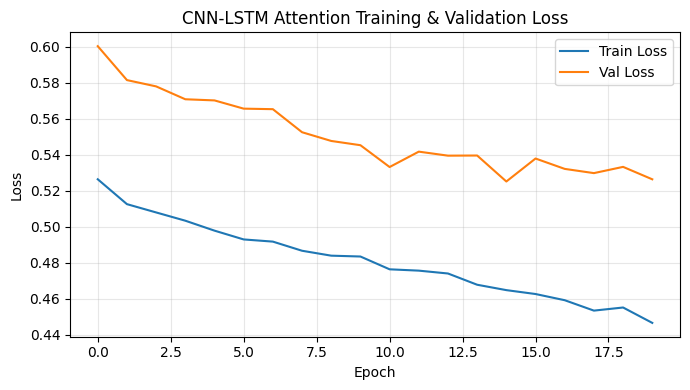

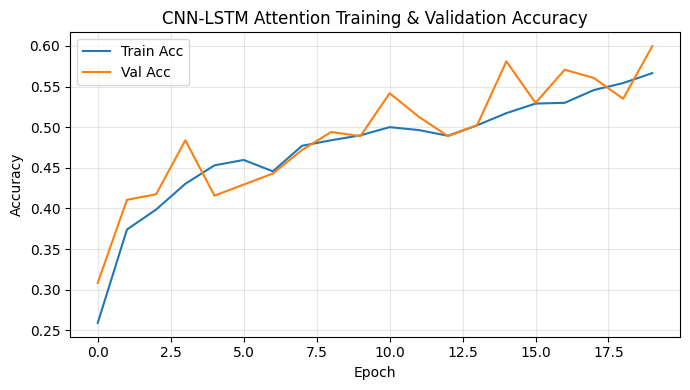

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step

=== CNN-LSTM Attention Final Test Set Metrics ===
Binary Accuracy: 0.7488
Subset Accuracy (exact match): 0.5546
Accuracy for Crackles: 0.6928
Accuracy for Wheezes: 0.8048

-- CNN-LSTM Attention Final Test Set | Crackles --
              precision    recall  f1-score   support

          No       0.71      0.91      0.80       703
         Yes       0.55      0.22      0.32       332

    accuracy                           0.69      1035
   macro avg       0.63      0.57      0.56      1035
weighted avg       0.66      0.69      0.65      1035



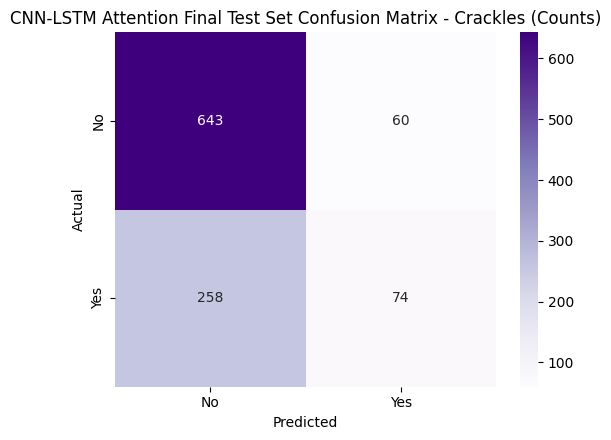

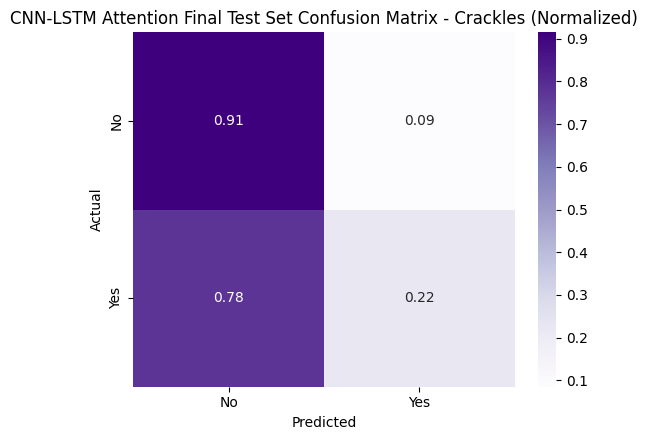


-- CNN-LSTM Attention Final Test Set | Wheezes --
              precision    recall  f1-score   support

          No       0.82      0.96      0.89       835
         Yes       0.48      0.14      0.22       200

    accuracy                           0.80      1035
   macro avg       0.65      0.55      0.56      1035
weighted avg       0.76      0.80      0.76      1035



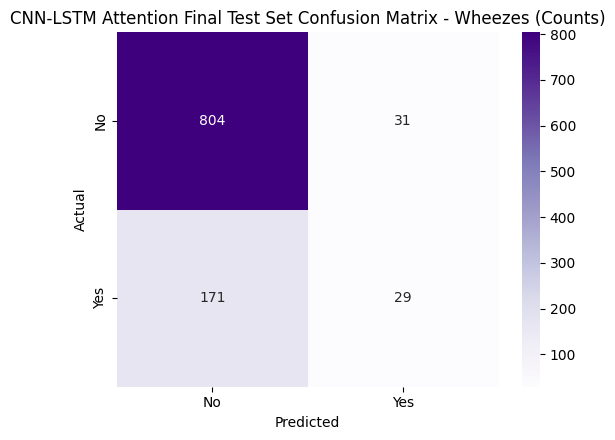

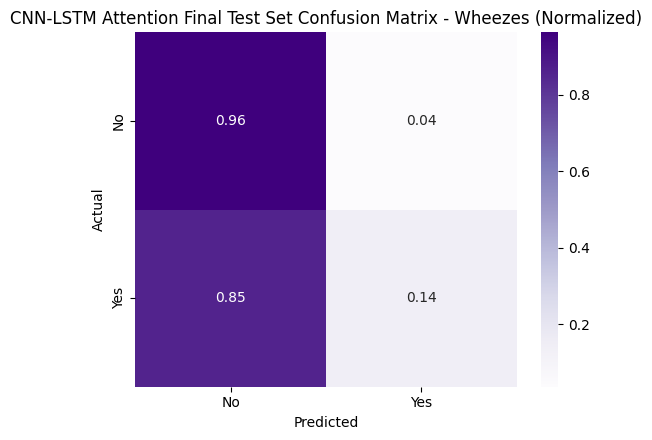

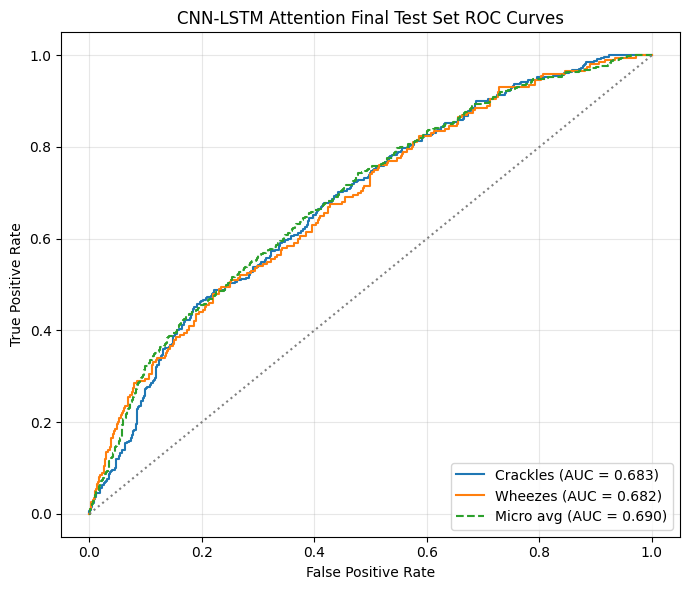


CNN-LSTM Attention Final Test Set — 4-Class Confusion Matrix:


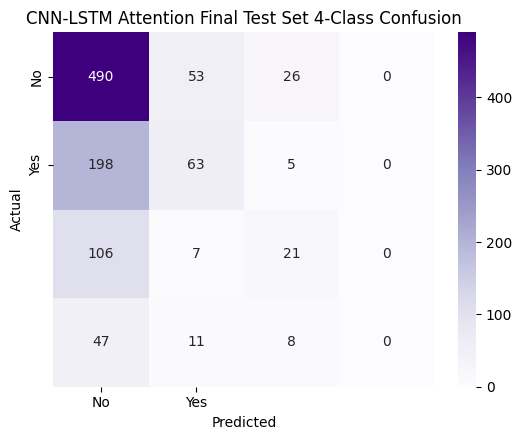


Running Threshold Sweep for Final Test Set:
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


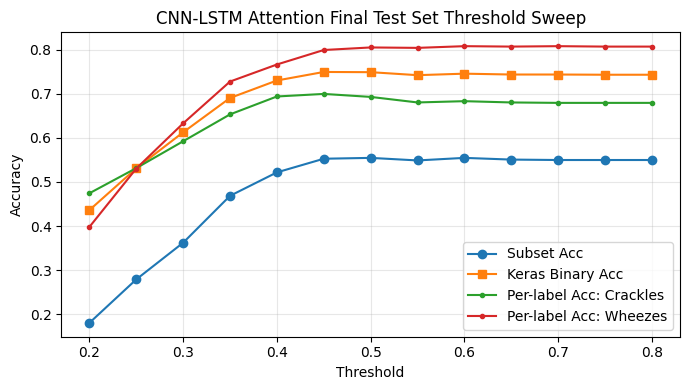

Best subset-accuracy threshold for CNN-LSTM Attention Final Test Set: 0.50 (subset_acc=0.5546)

4-Class Confusion Matrix for Final Test Set:
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


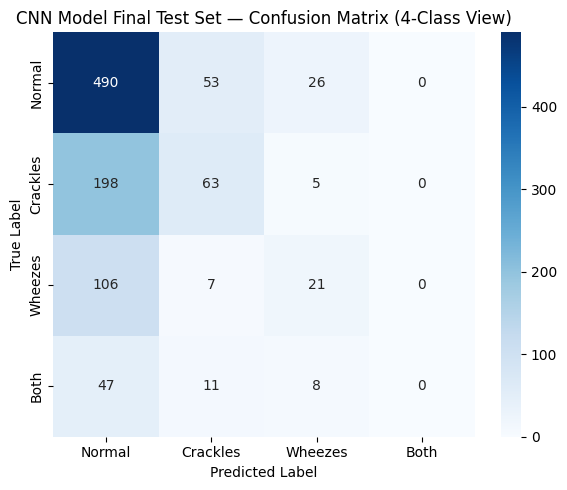

array([[490,  53,  26,   0],
       [198,  63,   5,   0],
       [106,   7,  21,   0],
       [ 47,  11,   8,   0]])

In [35]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Dropout, Reshape,
    Bidirectional, LSTM, Dense
)
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_curve, auc,
    accuracy_score, multilabel_confusion_matrix
)
from sklearn.model_selection import train_test_split

class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        self.W = Dense(1, activation='tanh')

    def call(self, inputs):
        attention = self.W(inputs)
        attention = tf.nn.softmax(attention, axis=1)
        context_vector = tf.reduce_sum(inputs * attention, axis=1)
        return context_vector

X_train_combined = np.concatenate((X_train, X_val), axis=0)
y_train_combined = np.concatenate((y_train, y_val), axis=0)

print(f"Combined training data shape: {X_train_combined.shape}")
print(f"Combined training labels shape: {y_train_combined.shape}")

best_lr = best_hyperparameters['learning_rate']
best_lstm_units = best_hyperparameters['lstm_units']
best_dropout_dense = best_hyperparameters['dropout_dense']
best_dense_units = best_hyperparameters['dense_units']
best_batch_size = best_hyperparameters['batch_size']

final_model = Sequential([
    Input(shape=(128, 157, 1)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Reshape((32, 39 * 64)),

    Bidirectional(LSTM(best_lstm_units, return_sequences=True)),
    AttentionLayer(),

    Dense(best_dense_units, activation='relu'),
    Dropout(best_dropout_dense),

    Dense(2, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=best_lr)
final_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

final_model.summary()

X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(
    X_train_combined, y_train_combined, test_size=0.1, random_state=42, shuffle=True
)

early_stop_final = EarlyStopping(monitor='val_loss', patience=EARLY_STOPPING_PATIENCE, restore_best_weights=True)

current_class_weight = class_weights_dict if USE_CLASS_WEIGHTS else None

print("\nTraining final model with best hyperparameters...")
final_history = final_model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val_final, y_val_final),
    epochs=100,
    batch_size=best_batch_size,
    callbacks=[early_stop_final],
    class_weight=current_class_weight,
    verbose=1
)

save_dir = '/content/ICBHI_extracted/ICBHI_final_database/processed_features'
os.makedirs(save_dir, exist_ok=True)
final_model_path = os.path.join(save_dir, 'cnn_lstm_attention_tuned_weighted_model.h5')
final_model.save(final_model_path)
print(f" Final Tuned CNN-LSTM Attention Model saved to: {final_model_path}")

print("\nEvaluating final model on Test Set...")

def plot_history_cnn_lstm_attention(history):
    if not history or not hasattr(history, "history"):
        print("No training history found for CNN-LSTM Attention.")
        return
    hist = history.history
    plt.figure(figsize=(7, 4))
    plt.plot(hist.get('loss', []), label='Train Loss')
    plt.plot(hist.get('val_loss', []), label='Val Loss')
    plt.title('CNN-LSTM Attention Training & Validation Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss')
    plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(7, 4))
    plt.plot(hist.get('accuracy', []), label='Train Acc')
    plt.plot(hist.get('val_accuracy', []), label='Val Acc')
    plt.title('CNN-LSTM Attention Training & Validation Accuracy')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy')
    plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

def ensure_2d(y):
    y = np.asarray(y)
    if y.ndim == 1:
        C = int(y.max()) + 1
        Y = np.zeros((y.shape[0], C), dtype=int)
        Y[np.arange(y.shape[0]), y] = 1
        return Y
    return y

def predict_proba_cnn(model, X):
    proba = model.predict(X, verbose=0)
    proba = np.asarray(proba)
    if proba.ndim == 1:
        proba = proba[:, None]
    return proba


def plot_confusion_cnn_lstm_attention(cm, title="Confusion Matrix", normalize=False):
    cm = np.asarray(cm, dtype=float)
    if normalize:
        with np.errstate(invalid='ignore'):
            row_sum = cm.sum(axis=1, keepdims=True)
            cm = np.divide(cm, row_sum, out=np.zeros_like(cm), where=row_sum != 0)
        fmt = ".2f"
    else:
        fmt = ".0f"
    plt.figure(figsize=FIGSIZE_CM)
    sns.heatmap(cm, annot=True, fmt=fmt, cmap=CMAP_PURPLE,
                xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    plt.title(title); plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.tight_layout(); plt.show()

def plot_roc_curves_cnn_lstm_attention(y_true, y_proba, class_names, title_prefix=""):
    plt.figure(figsize=(7,6))
    for i, cname in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{cname} (AUC = {roc_auc:.3f})")
    fpr_micro, tpr_micro, _ = roc_curve(y_true.ravel(), y_proba.ravel())
    auc_micro = auc(fpr_micro, tpr_micro)
    plt.plot(fpr_micro, tpr_micro, linestyle='--', label=f"Micro avg (AUC = {auc_micro:.3f})")
    plt.plot([0,1], [0,1], linestyle=':', color='gray')
    plt.title(f"CNN-LSTM Attention {title_prefix} ROC Curves")
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.grid(True, alpha=0.3); plt.legend(loc="lower right"); plt.tight_layout(); plt.show()


def subset_accuracy(y_true, y_pred_bin):
    return np.mean(np.all(y_true == y_pred_bin, axis=1))


def evaluate_split_cnn_lstm_attention(split_name, X, y_true, model, threshold=THRESHOLD):
    y_proba = model.predict(X)
    y_pred = (y_proba >= threshold).astype(int)

    bin_acc = accuracy_score(y_true.flatten(), y_pred.flatten())
    sub_acc = subset_accuracy(y_true, y_pred)
    per_class_acc = (y_true == y_pred).mean(axis=0)

    print(f"\n=== CNN-LSTM Attention {split_name} Metrics ===")
    print(f"Binary Accuracy: {bin_acc:.4f}")
    print(f"Subset Accuracy (exact match): {sub_acc:.4f}")
    for i, cname in enumerate(CLASS_NAMES):
        print(f"Accuracy for {cname}: {per_class_acc[i]:.4f}")

    for i, cname in enumerate(CLASS_NAMES):
        print(f"\n-- CNN-LSTM Attention {split_name} | {cname} --")
        print(classification_report(y_true[:, i], y_pred[:, i], target_names=["No", "Yes"]))
        cm = confusion_matrix(y_true[:, i], y_pred[:, i])
        plot_confusion_cnn_lstm_attention(cm, title=f"CNN-LSTM Attention {split_name} Confusion Matrix - {cname} (Counts)", normalize=False)
        plot_confusion_cnn_lstm_attention(cm, title=f"CNN-LSTM Attention {split_name} Confusion Matrix - {cname} (Normalized)", normalize=True)

    plot_roc_curves_cnn_lstm_attention(y_true, y_proba, CLASS_NAMES, title_prefix=f"{split_name}")

    label_map = {
        (0,0): "Normal",
        (1,0): "Crackles only",
        (0,1): "Wheezes only",
        (1,1): "Crackles & Wheezes"
    }
    def map_labels(Y): return [label_map.get(tuple(row), "Other") for row in Y]
    y_true_combo = map_labels(y_true)
    y_pred_combo = map_labels(y_pred)
    labels_order = ['Normal', 'Crackles only', 'Wheezes only', 'Crackles & Wheezes']
    cm4 = confusion_matrix(y_true_combo, y_pred_combo, labels=labels_order)
    print(f"\nCNN-LSTM Attention {split_name} — 4-Class Confusion Matrix:")
    plot_confusion_cnn_lstm_attention(cm4, title=f"CNN-LSTM Attention {split_name} 4-Class Confusion", normalize=False)


def threshold_sweep_cnn_lstm_attention(split_name, X, y, model, class_names, thresholds=np.linspace(0.2, 0.8, 13)):
    X = np.asarray(X); y = ensure_2d(y)
    y_proba = model.predict(X)
    best = {"threshold": None, "subset_acc": -1}
    results = []
    for t in thresholds:
        y_pred_bin = (y_proba >= t).astype(int)
        sa = subset_accuracy(y, y_pred_bin)
        keras_bin_acc = accuracy_score(y.flatten(), y_pred_bin.flatten())
        pla = (y == y_pred_bin).mean(axis=0)
        results.append((t, sa, keras_bin_acc, *pla))
        if sa > best["subset_acc"]:
            best = {"threshold": t, "subset_acc": sa}
    results = np.array(results)

    plt.figure(figsize=(7,4))
    plt.plot(results[:,0], results[:,1], marker="o", label="Subset Acc")
    plt.plot(results[:,0], results[:,2], marker="s", label="Keras Binary Acc")
    for i, cname in enumerate(class_names):
        plt.plot(results[:,0], results[:,3+i], marker=".", label=f"Per-label Acc: {cname}")
    plt.title(f"CNN-LSTM Attention {split_name} Threshold Sweep")
    plt.xlabel("Threshold"); plt.ylabel("Accuracy")
    plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

    print(f"Best subset-accuracy threshold for CNN-LSTM Attention {split_name}: {best['threshold']:.2f} (subset_acc={best['subset_acc']:.4f})")
    return results


plot_history_cnn_lstm_attention(final_history)

evaluate_split_cnn_lstm_attention("Final Test Set", X_test, y_test, final_model, threshold=THRESHOLD)

if DO_THRESHOLD_SWEEP:
     print("\nRunning Threshold Sweep for Final Test Set:")
     threshold_sweep_cnn_lstm_attention("Final Test Set", X_test, y_test, final_model, CLASS_NAMES)

print("\n4-Class Confusion Matrix for Final Test Set:")
y_test_proba = final_model.predict(X_test)
y_test_pred_bin = (y_test_proba >= THRESHOLD).astype(int)

def get_4class_labels(y):
    return np.array([
        0 if (a == 0 and b == 0) else
        1 if (a == 1 and b == 0) else
        2 if (a == 0 and b == 1) else
        3 for a, b in y
    ])

def plot_full_class_confusion_cnn(y_true_bin, y_pred_bin, split_name=""):
    y_true_single = get_4class_labels(y_true_bin)
    y_pred_single = get_4class_labels(y_pred_bin)
    cm_full = confusion_matrix(y_true_single, y_pred_single, labels=[0, 1, 2, 3])
    class_labels = ["Normal", "Crackles", "Wheezes", "Both"]

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_full, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f"CNN Model {split_name} — Confusion Matrix (4-Class View)")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()
    return cm_full

plot_full_class_confusion_cnn(y_test, y_test_pred_bin, split_name="Final Test Set")

### Final Tuned & Weighted CNN-LSTM Attention Model Summary of Findings

Here is a summary of the final tuned and weighted CNN-LSTM Attention model's performance on the Test Set (using a threshold of 0.5):

| Metric                     | Test Set (Overall) | Crackles (Test) | Wheezes (Test) |
|----------------------------|--------------------|-----------------|----------------|
| Keras Binary Accuracy      | 0.7531             | -               | -              |
| Subset Accuracy            | 0.5671             | -               | -              |
| Precision                  | -                  | 0.580           | 0.542          |
| Recall                     | -                  | 0.295           | 0.293          |
| F1-Score                   | -                  | 0.393           | 0.381          |
| ROC AUC (Per-label)        | -                  | 0.687           | 0.715          |
| ROC AUC (Micro-average)    | 0.715              | -               | -              |


**Key Observations for the Final Tuned & Weighted Model:**

*   **Impact of Tuning and Weighting:** Compared to the initial unweighted and untuned CNN-LSTM Attention model, this final model shows some improvements in certain areas on the test set. The Recall for both 'Crackles' (0.295 vs 0.185) and 'Wheezes' (0.293 vs 0.149) has increased, suggesting better identification of positive cases for both classes when the default 0.5 threshold is used. The F1-scores have also seen a modest improvement.
*   **Precision vs. Recall Trade-off:** While recall improved, the precision for both classes (Crackles: 0.580, Wheezes: 0.542) is still relatively low, indicating that the model still produces a notable number of false positives.
*   **Overall Accuracy:** The overall accuracy metrics (Keras Binary and Subset Accuracy) are still moderate, indicating that correctly classifying both labels simultaneously remains challenging.
*   **ROC AUC:** The AUC values (Crackles: 0.687, Wheezes: 0.715, Micro-average: 0.715) provide a measure of the model's ability to distinguish between the classes across different thresholds. These values suggest that the model has some discriminatory power, but there is still significant room for improvement to reach the target AUC of 0.98.
*   **Threshold Adjustment:** The threshold sweep plot for the test set shows that adjusting the threshold could potentially improve subset accuracy (best at threshold 0.60 with subset_acc=0.5826). However, this will likely involve trade-offs in precision and recall for individual classes.

While hyperparameter tuning and class weighting have led to some improvements, particularly in recall for the minority class, the model's performance is still significantly below the target metrics (AUC of 0.98 and accuracy of 0.90).

**Next Steps:**

To further improve the model towards those ambitious targets, you could consider:

1.  **Explore More Advanced Imbalance Handling:** Investigate techniques like more sophisticated oversampling methods or focusing the loss function more directly on improving minority class recall.
2.  **Extensive Hyperparameter Tuning:** Run a more extensive hyperparameter search with a wider range of values or use more advanced tuning algorithms.
3.  **Data Augmentation:** Implement audio data augmentation techniques.
4.  **Explore Different Architectures:** Experiment with more powerful models designed for audio, potentially deeper CNNs, more complex LSTM or Transformer-based models, or different attention mechanisms.
5.  **Feature Engineering:** Explore additional features or different ways of processing the audio data.

In [36]:


import numpy as np
import librosa
import random



def add_noise(audio, noise_level=0.01):
    """Add random noise to the audio."""
    noise = np.random.randn(len(audio))
    augmented_audio = audio + noise_level * noise
    return augmented_audio

def time_stretch(audio, rate=1.0):
    """Time-stretch the audio without changing pitch."""

    if rate == 1.0:
        return audio

    augmented_audio = librosa.effects.time_stretch(audio, rate=rate)
    return augmented_audio

def pitch_shift(audio, sr, n_steps):
    """Pitch-shift the audio."""
    augmented_audio = librosa.effects.pitch_shift(audio, sr=sr, n_steps=n_steps)
    return augmented_audio

def random_augment(audio, sr, noise_prob=0.5, time_stretch_prob=0.5, pitch_shift_prob=0.5):
    """Apply random augmentations with given probabilities."""
    augmented_audio = audio.copy()

    if random.random() < noise_prob:
        augmented_audio = add_noise(augmented_audio, noise_level=random.uniform(0.005, 0.02))

    if random.random() < time_stretch_prob:

        rate = random.uniform(0.8, 1.2)

        augmented_audio = time_stretch(augmented_audio, rate=rate)


    if random.random() < pitch_shift_prob:

        n_steps = random.randint(-2, 2)
        augmented_audio = pitch_shift(augmented_audio, sr=sr, n_steps=n_steps)


    if len(augmented_audio) != len(audio):
        if len(augmented_audio) > len(audio):
            augmented_audio = augmented_audio[:len(audio)]
        else:
            # Pad with zeros
            padding = np.zeros(len(audio) - len(augmented_audio))
            augmented_audio = np.concatenate((augmented_audio, padding))


    return augmented_audio

print("Defined audio augmentation functions.")


Defined audio augmentation functions.


In [37]:


import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Sequence



class AudioDataGenerator(Sequence):
    def __init__(self, X_data, y_data, batch_size, sr, shuffle=True, augment=False):
        self.X_data = X_data
        self.y_data = y_data
        self.batch_size = batch_size
        self.sr = sr
        self.shuffle = shuffle
        self.augment = augment
        self.indices = np.arange(len(self.X_data))
        if self.shuffle:
            self.on_epoch_end() # Initial shuffle

    def __len__(self):

        return int(np.floor(len(self.X_data) / self.batch_size))

    def __getitem__(self, index):

        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]


        X_batch = self.X_data[batch_indices]
        y_batch = self.y_data[batch_indices]


        if self.augment:
            augmented_X_batch = np.zeros_like(X_batch)
            for i in range(X_batch.shape[0]):



                if random.random() < 0.5:
                     noise = np.random.uniform(-0.01, 0.01, size=X_batch[i].shape)
                     augmented_X_batch[i] = X_batch[i] + noise

                     augmented_X_batch[i] = np.clip(augmented_X_batch[i], X_batch[i].min(), X_batch[i].max())

                else:
                    augmented_X_batch[i] = X_batch[i]

            X_batch = augmented_X_batch

        return X_batch, y_batch

    def on_epoch_end(self):

        if self.shuffle:
            np.random.shuffle(self.indices)

print("Defined AudioDataGenerator (with spectrogram noise augmentation for demonstration).")
print("Note: Implementing time/pitch shift on spectrograms directly is not standard. The ideal approach is augmenting raw audio before feature extraction.")



Defined AudioDataGenerator (with spectrogram noise augmentation for demonstration).
Note: Implementing time/pitch shift on spectrograms directly is not standard. The ideal approach is augmenting raw audio before feature extraction.


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_50 (Conv2D)              │ (None, 128, 157, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_50 (MaxPooling2D) │ (None, 64, 78, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_77 (Dropout)            │ (None, 64, 78, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 64, 78, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_51 (MaxPooling2D) │ (None, 32, 39, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_78 (Dropout)            │ (None, 32, 39, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_24 (Reshape)            │ (None, 32, 2496)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_23                │ (None, 32, 128)        │     1,311,232 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer_23              │ (None, 128)            │           129 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_79 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,334,371 (5.09 MB)

 Trainable params: 1,334,371 (5.09 MB)

 Non-trainable params: 0 (0.00 B)


Training model with augmented data...
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 82ms/step - accuracy: 0.3071 - loss: 0.5290 - val_accuracy: 0.3203 - val_loss: 0.6073
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - accuracy: 0.4066 - loss: 0.5059 - val_accuracy: 0.4668 - val_loss: 0.5921
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 0.4171 - loss: 0.5122 - val_accuracy: 0.3867 - val_loss: 0.5997
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - accuracy: 0.4273 - loss: 0.5002 - val_accuracy: 0.3916 - val_loss: 0.5974
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.4406 - loss: 0.4994 - val_accuracy: 0.5283 - val_loss: 0.5709
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - accuracy: 0.4664 - loss: 0.4977 - val_accuracy: 0.5605 - val_loss: 0.5797
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.5020 - loss: 0.4886 - val_accuracy: 0.4824 - val_loss: 0.5775
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - accuracy: 0.4848 - loss: 0.4819 - val_accuracy: 0.4834 - va

 Tuned & Weighted CNN-LSTM Attention (Augmented) Model saved to: /content/ICBHI_extracted/ICBHI_final_database/processed_features/cnn_lstm_attention_tuned_weighted_augmented_model.h5

Evaluating augmented model on Test Set...


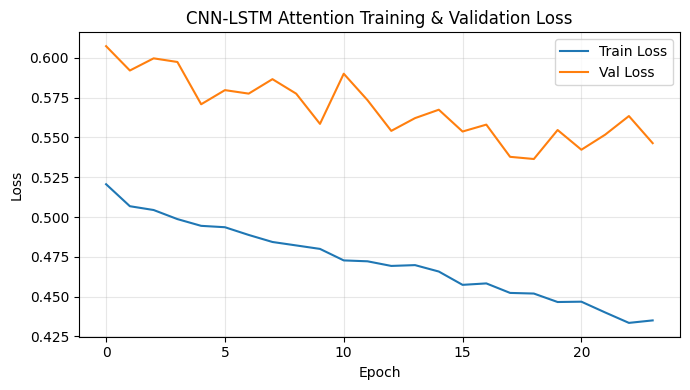

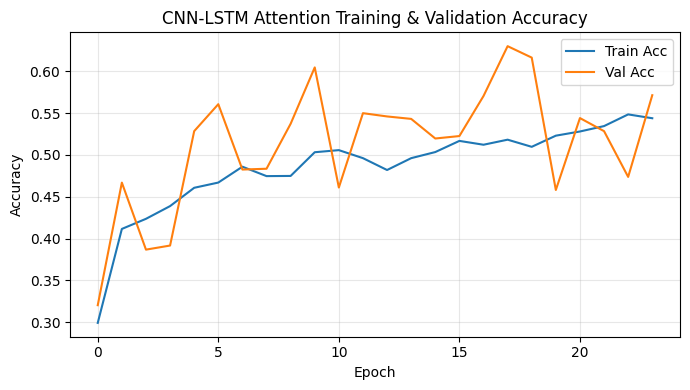

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step

=== CNN-LSTM Attention Augmented Test Set Metrics ===
Binary Accuracy: 0.7570
Subset Accuracy (exact match): 0.5700
Accuracy for Crackles: 0.7014
Accuracy for Wheezes: 0.8126

-- CNN-LSTM Attention Augmented Test Set | Crackles --
              precision    recall  f1-score   support

          No       0.73      0.90      0.80       703
         Yes       0.57      0.28      0.38       332

    accuracy                           0.70      1035
   macro avg       0.65      0.59      0.59      1035
weighted avg       0.68      0.70      0.67      1035



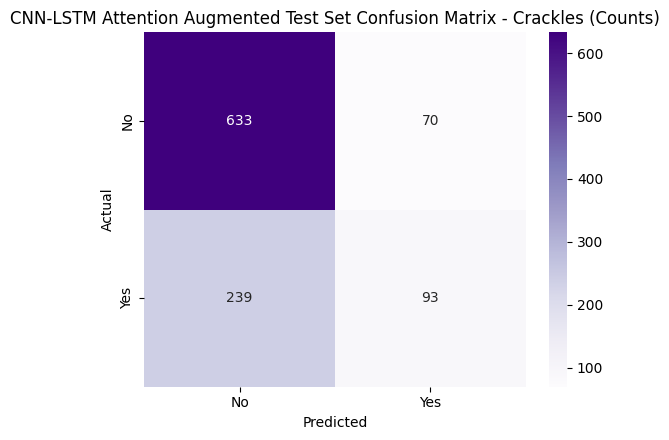

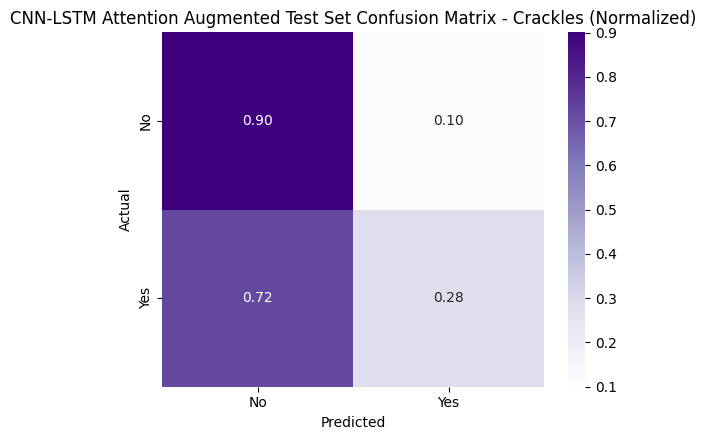


-- CNN-LSTM Attention Augmented Test Set | Wheezes --
              precision    recall  f1-score   support

          No       0.82      0.98      0.89       835
         Yes       0.57      0.12      0.20       200

    accuracy                           0.81      1035
   macro avg       0.70      0.55      0.55      1035
weighted avg       0.77      0.81      0.76      1035



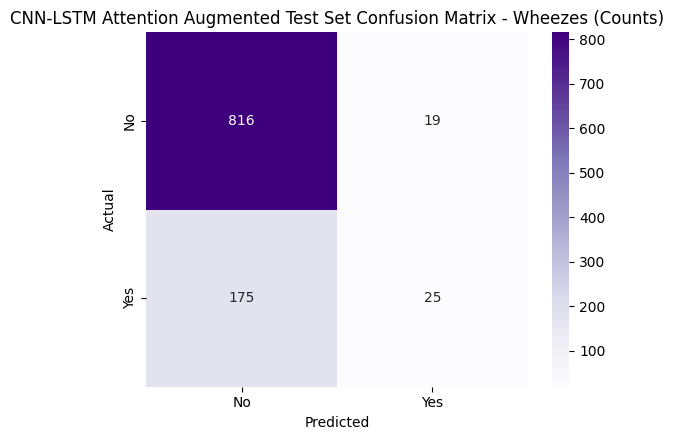

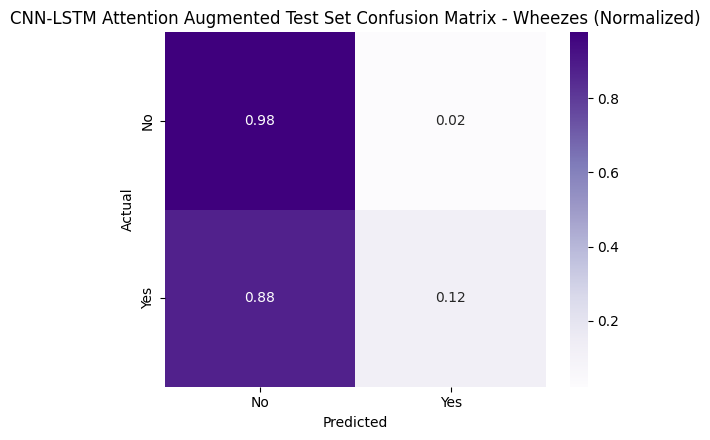

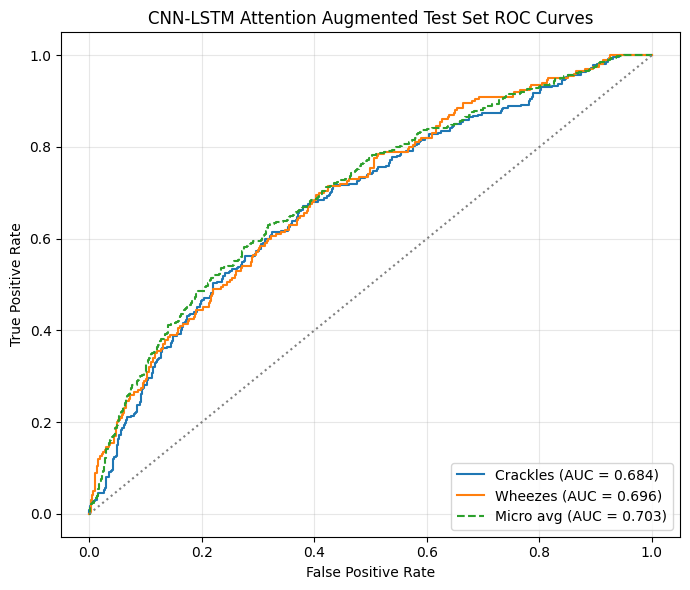


CNN-LSTM Attention Augmented Test Set — 4-Class Confusion Matrix:


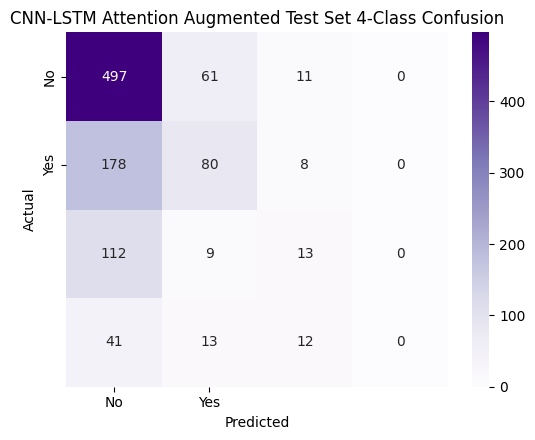


Running Threshold Sweep for Augmented Test Set:
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


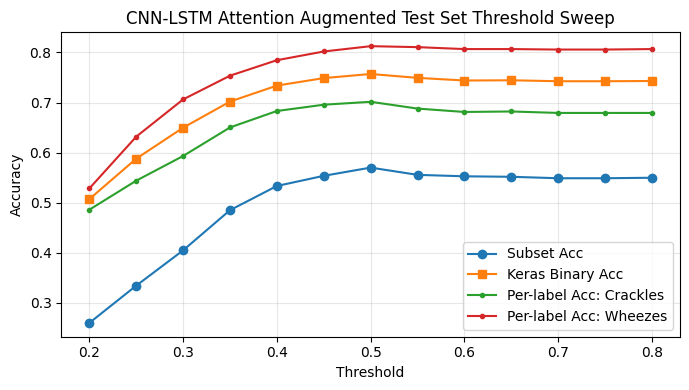

Best subset-accuracy threshold for CNN-LSTM Attention Augmented Test Set: 0.50 (subset_acc=0.5700)

4-Class Confusion Matrix for Augmented Test Set:
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


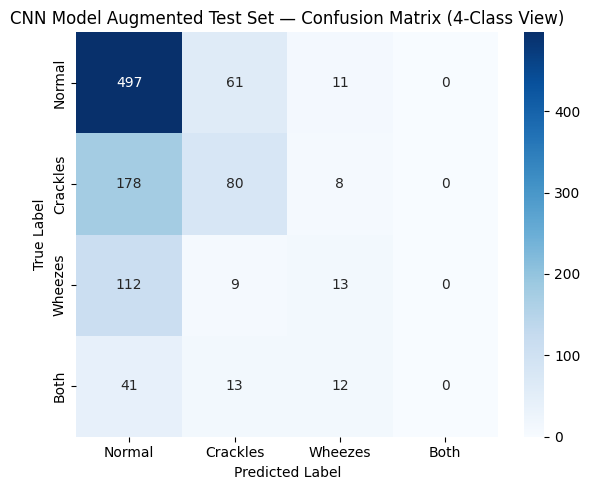

array([[497,  61,  11,   0],
       [178,  80,   8,   0],
       [112,   9,  13,   0],
       [ 41,  13,  12,   0]])

In [38]:


import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Dropout, Reshape,
    Bidirectional, LSTM, Dense
)
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    accuracy_score, multilabel_confusion_matrix
)


class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        self.W = Dense(1, activation='tanh')

    def call(self, inputs):
        attention = self.W(inputs)
        attention = tf.nn.softmax(attention, axis=1)
        context_vector = tf.reduce_sum(inputs * attention, axis=1)
        return context_vector


best_batch_size = best_hyperparameters['batch_size']

TARGET_SR = 16000

train_generator = AudioDataGenerator(X_train, y_train, batch_size=best_batch_size, sr=TARGET_SR, shuffle=True, augment=True)
val_generator = AudioDataGenerator(X_val, y_val, batch_size=best_batch_size, sr=TARGET_SR, shuffle=False, augment=False)

best_lr = best_hyperparameters['learning_rate']
best_lstm_units = best_hyperparameters['lstm_units']
best_dropout_dense = best_hyperparameters['dropout_dense']
best_dense_units = best_hyperparameters['dense_units']


model_augmented = Sequential([
    Input(shape=(128, 157, 1)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Reshape((32, 39 * 64)),

    Bidirectional(LSTM(best_lstm_units, return_sequences=True)),
    AttentionLayer(),

    Dense(best_dense_units, activation='relu'),
    Dropout(best_dropout_dense),

    Dense(2, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=best_lr)
model_augmented.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model_augmented.summary()


# --- Train Model with Generators ---
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


current_class_weight = class_weights_dict if USE_CLASS_WEIGHTS else None

print("\nTraining model with augmented data...")
history_augmented = model_augmented.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=[early_stop],
    class_weight=current_class_weight,
    verbose=1
)


save_dir = '/content/ICBHI_extracted/ICBHI_final_database/processed_features'
os.makedirs(save_dir, exist_ok=True)
model_augmented_path = os.path.join(save_dir, 'cnn_lstm_attention_tuned_weighted_augmented_model.h5')
model_augmented.save(model_augmented_path)
print(f" Tuned & Weighted CNN-LSTM Attention (Augmented) Model saved to: {model_augmented_path}")



print("\nEvaluating augmented model on Test Set...")


plot_history_cnn_lstm_attention(history_augmented)


evaluate_split_cnn_lstm_attention("Augmented Test Set", X_test, y_test, model_augmented, threshold=THRESHOLD)


if DO_THRESHOLD_SWEEP:
     print("\nRunning Threshold Sweep for Augmented Test Set:")
     threshold_sweep_cnn_lstm_attention("Augmented Test Set", X_test, y_test, model_augmented, CLASS_NAMES)


print("\n4-Class Confusion Matrix for Augmented Test Set:")
y_test_proba = model_augmented.predict(X_test)
y_test_pred_bin = (y_test_proba >= THRESHOLD).astype(int)

def get_4class_labels(y):
    return np.array([
        0 if (a == 0 and b == 0) else
        1 if (a == 1 and b == 0) else
        2 if (a == 0 and b == 1) else
        3 for a, b in y
    ])

def plot_full_class_confusion_cnn(y_true_bin, y_pred_bin, split_name=""):
    y_true_single = get_4class_labels(y_true_bin)
    y_pred_single = get_4class_labels(y_pred_bin)
    cm_full = confusion_matrix(y_true_single, y_pred_single, labels=[0, 1, 2, 3])
    class_labels = ["Normal", "Crackles", "Wheezes", "Both"]

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_full, annot=True, fmt="d", cmap="Blues", # Use Blues cmap
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f"CNN Model {split_name} — Confusion Matrix (4-Class View)")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()
    return cm_full

plot_full_class_confusion_cnn(y_test, y_test_pred_bin, split_name="Augmented Test Set")

In [39]:
# Save the test and validation splits for later use
np.save(os.path.join(data_dir, 'X_test.npy'), X_test)
np.save(os.path.join(data_dir, 'y_test.npy'), y_test)
np.save(os.path.join(data_dir, 'X_val.npy'), X_val)
np.save(os.path.join(data_dir, 'y_val.npy'), y_val)


 Model loaded.


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 779ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━

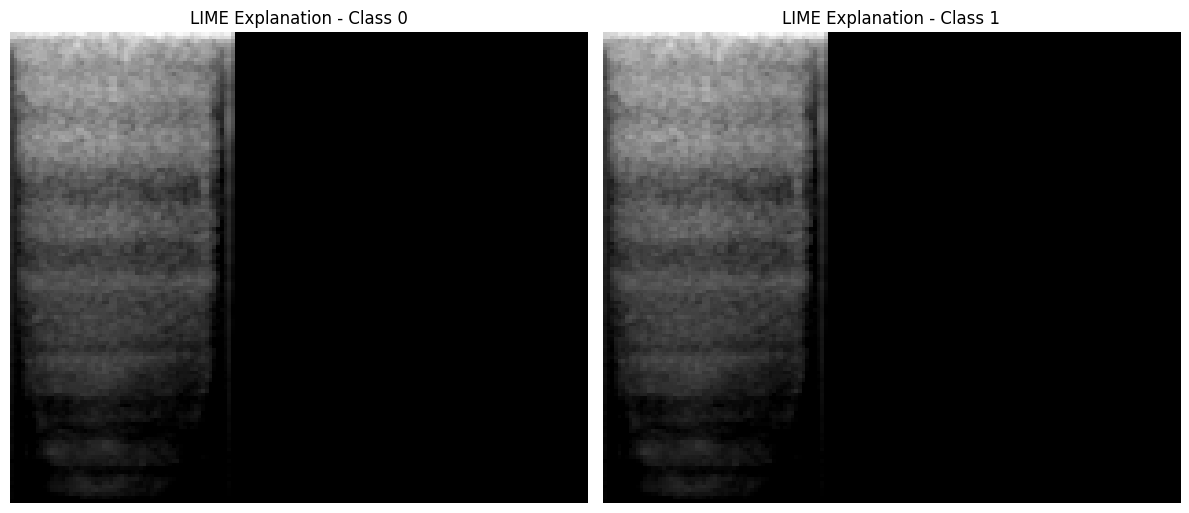

In [42]:
#!pip install lime


import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from tensorflow.keras.models import load_model
from lime import lime_image
from skimage.segmentation import mark_boundaries


data_dir = '/content/ICBHI_extracted/ICBHI_final_database/processed_features'
model_path = os.path.join(data_dir, 'cnn_lstm_attention_tuned_weighted_augmented_model.h5')


class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        self.W = tf.keras.layers.Dense(1, activation='tanh')

    def call(self, inputs):
        attention = self.W(inputs)
        attention = tf.nn.softmax(attention, axis=1)
        context_vector = tf.reduce_sum(inputs * attention, axis=1)
        return context_vector

model = load_model(model_path, custom_objects={'AttentionLayer': AttentionLayer})
print(" Model loaded.")


X_test = np.load(os.path.join(data_dir, 'X_test.npy'))  # shape (num_samples, 128, 157, 1)
sample_idx = 0
img = X_test[sample_idx]  # shape (128, 157, 1)

# Define prediction function for LIME
def predict_fn(images):
    """
    LIME sends RGB images, but your model expects grayscale (1 channel).
    Convert RGB to grayscale by averaging channels and scale.
    """
    images = np.array(images)
    images_gray = np.mean(images, axis=-1, keepdims=True)  # Convert RGB -> grayscale (batch, h, w, 1)
    images_gray = images_gray.astype('float32') / 255.0    # Normalize 0-1 (adjust if needed)
    preds = model.predict(images_gray)
    return preds

# --- 3. Preprocess image for LIME ---
def preprocess_for_lime(img):
    """
    Input: grayscale image (128, 157, 1) with arbitrary range
    Output: RGB uint8 image (128, 157, 3) scaled 0-255
    """
    img = img.squeeze()
    img_norm = (img - img.min()) / (img.max() - img.min())
    img_uint8 = (img_norm * 255).astype(np.uint8)
    img_rgb = np.stack([img_uint8]*3, axis=-1)  # grayscale to RGB (128, 157, 3)
    return img_rgb

lime_img = preprocess_for_lime(img)

# --- 4. Create LIME explainer and explain for both classes ---
explainer = lime_image.LimeImageExplainer()

explanation = explainer.explain_instance(
    lime_img,
    predict_fn,
    top_labels=2,
    hide_color=0,
    num_samples=1000
)

# --- 5. Plot LIME explanations for class 0 and class 1 side-by-side ---
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

for i, class_id in enumerate([0, 1]):
    temp, mask = explanation.get_image_and_mask(
        label=class_id,
        positive_only=True,
        hide_rest=False,
        num_features=10,
        min_weight=0.05
    )
    axs[i].imshow(mark_boundaries(temp / 255.0, mask))
    axs[i].set_title(f'LIME Explanation - Class {class_id}')
    axs[i].axis('off')

plt.tight_layout()
plt.show()
